# Prompt Comparison for Invoice Work Order Number Extraction

## Overview
This notebook compares the effectiveness of different prompt strategies for extracting work order numbers from invoice images using the Pixtral-12B vision-language model. We will test three distinct prompt approaches:

1. **Basic Prompt**: A simple, direct instruction
   ```
   Extract the work order number from this invoice image.
   ```

2. **Detailed Prompt**: Provides additional context and possible field labels
   ```
   This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
   ```

3. **Positioned Prompt**: Includes positional information about where to look
   ```
   Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
   ```

### Objectives
- Evaluate how different prompt formulations affect extraction accuracy
- Identify which prompt strategy yields the highest exact match rate
- Analyze error patterns for each prompt type
- Establish best practices for invoice data extraction

We'll process the same dataset with each prompt type while keeping all other variables constant, allowing for direct comparison of their effectiveness.

## Setup and Environment Verification
### Environment Detection 

In [1]:
# Import Dependencies
import os
import sys
import platform
import torch
import transformers
from pathlib import Path
import logging
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Configure basic logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('invoice_extraction')

In [3]:
# Define function to check if we're in a RunPod environment
def is_runpod():
    """Check if we're running in a RunPod environment"""
    return (
        os.environ.get("RUNPOD_POD_ID") is not None or 
        "A100" in os.environ.get("GPU_NAME", "") or
        "H100" in os.environ.get("GPU_NAME", "")
    )

# Display basic system information
print(f"🔍 Environment Setup and Verification")
print(f"🐍 Python version: {platform.python_version()}")
print(f"📊 PyTorch version: {torch.__version__}")
print(f"🤖 Transformers version: {transformers.__version__}")
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Check for GPU availability
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"🖥️ GPU: {device_name} ({memory:.2f} GB)")
    print(f"🔍 CUDA Version: {torch.version.cuda}")
    
    # Display GPU memory usage
    allocated = torch.cuda.memory_allocated(0) / 1e9
    reserved = torch.cuda.memory_reserved(0) / 1e9
    print(f"💾 GPU Memory: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")
    
    # Basic GPU compatibility check
    if memory < 24:
        print("⚠️ Warning: GPU memory may be insufficient for Pixtral-12B without quantization")
    else:
        print("✅ GPU memory sufficient for model loading")
else:
    print("⚠️ No GPU detected - running in CPU mode")
    print("   Note: Processing will be extremely slow without GPU acceleration")

# Identify environment type
if is_runpod():
    print("☁️ RunPod environment detected")
else:
    print("💻 Local environment detected")

# Display platform details for debugging
print(f"💻 System: {platform.system()} {platform.release()}")
print(f"📂 Working directory: {os.getcwd()}")

🔍 Environment Setup and Verification
🐍 Python version: 3.10.12
📊 PyTorch version: 2.1.0+cu118
🤖 Transformers version: 4.50.0
📅 Date: 2025-03-23 16:31:07
🖥️ GPU: NVIDIA H100 NVL (99.98 GB)
🔍 CUDA Version: 11.8
💾 GPU Memory: 0.00 GB allocated, 0.00 GB reserved
✅ GPU memory sufficient for model loading
☁️ RunPod environment detected
💻 System: Linux 6.8.0-50-generic
📂 Working directory: /workspace/notebooks


### Establish Paths

In [4]:
# Project Path Configuration
# Set up project paths - This cell finds the project root and initializes path configuration

# First, try to find the project root directory
notebook_path = Path().resolve()
project_root = None

# Look for project root markers (traversing upward from the notebook)
for parent in [notebook_path] + list(notebook_path.parents):
    if any((parent / marker).exists() for marker in ['.git', 'setup.py', 'requirements.txt']):
        project_root = parent
        break

if project_root is None:
    # If markers not found, assume we're in a subdirectory of the project
    # and the parent directory is the project root
    project_root = notebook_path.parent
    print("⚠️ Could not definitively locate project root, using parent directory")
else:
    print(f"✅ Found project root: {project_root}")

# Add project root to Python path if not already there
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"📌 Added {project_root} to Python path")

# Set environment variable for project root
os.environ['PROJECT_ROOT'] = str(project_root)
print(f"🔄 Set PROJECT_ROOT environment variable to {project_root}")

# Verify critical directories exist, create if needed
critical_dirs = [
    "configs/environments",
    "configs/prompts",
    "src/config",
    "src/models",
    "src/prompts",
    "src/execution",
    "src/results",
    "src/analysis",
    "data/images",
    "models/cache",
    "results/raw",
    "results/processed",
    "results/visualizations",
    "logs"
]

for dir_path in critical_dirs:
    full_path = project_root / dir_path
    if not full_path.exists():
        print(f"📁 Creating directory: {dir_path}")
        full_path.mkdir(parents=True, exist_ok=True)
    else:
        print(f"✅ Directory exists: {dir_path}")

# Check for ground truth data file
ground_truth_path = project_root / "data" / "ground_truth.csv"
if os.path.exists(ground_truth_path):
    print(f"✅ Ground truth data file found")
else:
    print(f"⚠️ Ground truth data file not found at: {ground_truth_path}")
    print("   This will be needed for comparing extraction results.")

# Check for image files
image_dir = project_root / "data" / "images"
image_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))
if image_files:
    print(f"✅ Found {len(image_files)} image files in {image_dir}")
else:
    print(f"⚠️ No image files found in {image_dir}")
    print("   This will be needed for extraction testing.")

# Set up results directory for this run with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_name = f"prompt_comparison_{timestamp}"
results_dir = project_root / "results" / experiment_name
results_dir.mkdir(parents=True, exist_ok=True)
print(f"📊 Created results directory for this run: {results_dir}")

# Create subdirectories in results directory
for subdir in ["raw", "processed", "visualizations"]:
    (results_dir / subdir).mkdir(exist_ok=True)

# Define path utility functions
def get_results_path(filename):
    """Get full path for a results file"""
    return results_dir / filename

def get_raw_path(filename):
    """Get full path for a raw results file"""
    return results_dir / "raw" / filename

def get_processed_path(filename):
    """Get full path for a processed results file"""
    return results_dir / "processed" / filename

def get_visualization_path(filename):
    """Get full path for a visualization file"""
    return results_dir / "visualizations" / filename

def get_image_paths():
    """Get all image paths from the images directory"""
    return list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))

# Define paths dictionary for easy access
paths = {
    "project_root": project_root,
    "data_dir": project_root / "data",
    "images_dir": image_dir,
    "ground_truth_path": ground_truth_path,
    "models_cache_dir": project_root / "models" / "cache",
    "results_dir": results_dir,
    "raw_results_dir": results_dir / "raw",
    "processed_results_dir": results_dir / "processed",
    "visualizations_dir": results_dir / "visualizations",
    "get_results_path": get_results_path,
    "get_raw_path": get_raw_path,
    "get_processed_path": get_processed_path,
    "get_visualization_path": get_visualization_path,
    "get_image_paths": get_image_paths
}

print(f"\n📋 Path configuration complete!")
print(f"   Project root: {paths['project_root']}")
print(f"   Data directory: {paths['data_dir']}")
print(f"   Results for this run: {paths['results_dir']}")

✅ Found project root: /workspace
📌 Added /workspace to Python path
🔄 Set PROJECT_ROOT environment variable to /workspace
✅ Directory exists: configs/environments
✅ Directory exists: configs/prompts
✅ Directory exists: src/config
✅ Directory exists: src/models
✅ Directory exists: src/prompts
✅ Directory exists: src/execution
✅ Directory exists: src/results
✅ Directory exists: src/analysis
✅ Directory exists: data/images
✅ Directory exists: models/cache
✅ Directory exists: results/raw
✅ Directory exists: results/processed
✅ Directory exists: results/visualizations
✅ Directory exists: logs
✅ Ground truth data file found
✅ Found 20 image files in /workspace/data/images
📊 Created results directory for this run: /workspace/results/prompt_comparison_20250323_163114

📋 Path configuration complete!
   Project root: /workspace
   Data directory: /workspace/data
   Results for this run: /workspace/results/prompt_comparison_20250323_163114


### Import Core Dependencies

In [5]:
# Import Required Libraries

# Standard libraries
import os
import sys
import json
import time
import logging
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional, Union

# Data processing and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from Levenshtein import distance

# Deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoProcessor,
    LlavaForConditionalGeneration,
    AutoModelForVision2Seq,
    AutoTokenizer,
    BitsAndBytesConfig
)

In [6]:
# Configure logging
import os

# Create logs directory if it doesn't exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

log_file = f"{log_dir}/extraction_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),  # Log to console
        logging.FileHandler(log_file)  # Log to file
    ]
)
logger = logging.getLogger('invoice_extraction')
logger.info("Starting invoice extraction experiment")

2025-03-23 16:31:22,904 - invoice_extraction - INFO - Starting invoice extraction experiment


### Import Project Modules

In [7]:
# Import project-specific modules
try:
    # Attempt to import required modules from src directory
    # These imports assume the project root has been added to sys.path in Cell 1
    
    # Configuration modules
    from src.config.environment import get_environment_config
    from src.config.paths import get_path_config, PathConfig
    from src.config.experiment import get_experiment_config, ExperimentConfig
    
    # Model handling modules
    from src.models.loader import load_model_and_processor, get_gpu_memory_info
    from src.models.registry import get_model_config
    from src.models.optimization import optimize_model_memory
    
    # Prompt management modules
    from src.prompts.registry import get_prompt, list_available_prompts, format_prompt
    from src.prompts.prompt_utils import analyze_prompt
    
    # Execution modules
    from src.execution.inference import process_image
    from src.execution.pipeline import ExtractionPipeline
    from src.execution.batch import prepare_batch_items
    
    # Results and analysis modules
    from src.results.collector import ResultsCollector
    from src.results.metrics import calculate_metrics
    from src.analysis.visualization import create_visualizations
    
    logger.info("Successfully imported project modules")
    
except ImportError as e:
    logger.error(f"Error importing project modules: {e}")
    logger.warning("Some functionality may be limited. Check your project structure and path configuration.")
    print(f"⚠️ Warning: Failed to import some project modules: {e}")
    print("   This may happen if you haven't implemented these modules yet.")
    print("   The notebook will attempt to continue, but some cells may need modification.")

2025-03-23 16:31:27,669 - invoice_extraction - ERROR - Error importing project modules: cannot import name 'optimize_model_memory' from 'src.models.optimization' (/workspace/src/models/optimization.py)
2025-03-23 16:31:27,670 - invoice_extraction - WARNING - Some functionality may be limited. Check your project structure and path configuration.


⚠️ Warning: Failed to import some project modules: cannot import name 'optimize_model_memory' from 'src.models.optimization' (/workspace/src/models/optimization.py)
   This may happen if you haven't implemented these modules yet.
   The notebook will attempt to continue, but some cells may need modification.


In [8]:
# Print summary of imported libraries
print("📚 Core Libraries Imported:")
print(f"🔢 NumPy: {np.__version__}")
print(f"📊 Pandas: {pd.__version__}")
print(f"🧠 PyTorch: {torch.__version__}")
print(f"🤖 Transformers: {transformers.__version__}")

📚 Core Libraries Imported:
🔢 NumPy: 1.24.3
📊 Pandas: 2.0.3
🧠 PyTorch: 2.1.0+cu118
🤖 Transformers: 4.50.0


In [9]:
# Check for GPU acceleration
if torch.cuda.is_available():
    print("✅ CUDA is available for GPU acceleration")
    device = torch.device("cuda")
else:
    print("⚠️ CUDA is not available, using CPU (this will be slow)")
    device = torch.device("cpu")

print(f"🔧 Using device: {device}")

✅ CUDA is available for GPU acceleration
🔧 Using device: cuda


## Experiment Configuration
### Environment Configuration

In [10]:
# Environment Configuration

# Import configuration modules if not already imported
try:
    from src.config.environment import get_environment_config, EnvironmentConfig
except ImportError:
    # Fallback implementation if modules aren't available yet
    logger.warning("Using fallback environment configuration")
    
    class EnvironmentConfig:
        """Fallback Environment Configuration class"""
        def __init__(self, env_type="auto"):
            self.environment = "runpod" if is_runpod() else "local"
            self.gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9 if torch.cuda.is_available() else 0
            self.max_batch_size = 1 if self.environment == "local" else 4
            self.optimize_memory = True
            self.use_4bit_quantization = self.environment == "runpod" and self.gpu_memory_gb < 40
            self.use_half_precision = True
            
        def print_summary(self):
            """Print a summary of the environment configuration"""
            print(f"Environment: {self.environment}")
            print(f"GPU Memory: {self.gpu_memory_gb:.2f} GB")
            print(f"Max Batch Size: {self.max_batch_size}")
            print(f"Memory Optimization: {'Enabled' if self.optimize_memory else 'Disabled'}")
            print(f"4-bit Quantization: {'Enabled' if self.use_4bit_quantization else 'Disabled'}")
            print(f"Half Precision: {'Enabled' if self.use_half_precision else 'Disabled'}")
    
    def get_environment_config(env_type="auto"):
        """Fallback function to get environment configuration"""
        return EnvironmentConfig(env_type)

# Detect whether we're in a RunPod or local environment
env_type = "runpod" if is_runpod() else "local"
print(f"🔍 Detected environment type: {env_type}")

# Load appropriate configuration
try:
    # Get environment configuration
    env_config = get_environment_config(env_type)
    print(f"📌 Loaded {env_config.environment} environment configuration")
    
    # Load environment-specific settings from YAML if available
    yaml_config_path = project_root / "configs" / "environments" / f"{env_config.environment}.yaml"
    if os.path.exists(yaml_config_path):
        import yaml
        with open(yaml_config_path, 'r') as f:
            yaml_config = yaml.safe_load(f)
        print(f"📄 Loaded environment settings from {yaml_config_path}")
        
        # Override config settings with YAML values if present
        for key, value in yaml_config.items():
            if hasattr(env_config, key):
                setattr(env_config, key, value)
                print(f"  ↳ Set {key} = {value}")
    else:
        print(f"ℹ️ No environment config file found at {yaml_config_path}, using defaults")
    
except Exception as e:
    print(f"❌ Error loading environment configuration: {e}")
    print("⚠️ Using default environment settings")
    env_config = EnvironmentConfig(env_type)

# Set up GPU memory optimization based on environment config
if torch.cuda.is_available() and hasattr(env_config, 'optimize_memory') and env_config.optimize_memory:
    # Set up memory optimization for better GPU usage
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
        print("🧹 Cleared CUDA cache")
    
    # Set memory configuration based on environment
    if env_config.environment == "runpod":
        # More aggressive optimization for RunPod
        torch.cuda.set_per_process_memory_fraction(0.95)  # Use up to 95% of GPU memory
        print("⚙️ Set GPU memory fraction to 95% for RunPod environment")
    else:
        # More conservative for local environment
        torch.cuda.set_per_process_memory_fraction(0.8)  # Use up to 80% of GPU memory
        print("⚙️ Set GPU memory fraction to 80% for local environment")

# Initialize experiment configuration
experiment_name = f"pixtral_extraction_{timestamp}"
print(f"🧪 Initializing experiment: {experiment_name}")

# Create experiment configuration dictionary
experiment_config = {
    "name": experiment_name,
    "timestamp": timestamp,
    "environment": env_config.environment,
    "model_name": "pixtral-12b",  # Default model
    "model_repo_id": "mistral-community/pixtral-12b",  # Default repo
    "field_to_extract": "work_order",  # What we're extracting from invoices
    "use_4bit_quantization": env_config.use_4bit_quantization if hasattr(env_config, 'use_4bit_quantization') else False,
    "use_half_precision": env_config.use_half_precision if hasattr(env_config, 'use_half_precision') else True,
    "max_batch_size": env_config.max_batch_size if hasattr(env_config, 'max_batch_size') else 1,
    "description": "Comparing prompt strategies for work order number extraction using Pixtral-12B"
}

# Display environment and experiment configuration summary
print("\n📋 Environment Configuration Summary:")
env_config.print_summary()

print("\n🧪 Experiment Configuration Summary:")
for key, value in experiment_config.items():
    print(f"  {key}: {value}")

# Save configurations for reference
config_path = get_results_path("experiment_config.json")
with open(config_path, "w") as f:
    # Create serializable config by converting Path objects to strings
    serializable_config = {
        "experiment": experiment_config,
        "environment": {k: str(v) if isinstance(v, Path) else v 
                        for k, v in vars(env_config).items() 
                        if not k.startswith('_') and not callable(v)},
        "paths": {k: str(v) if isinstance(v, Path) else v 
                 for k, v in paths.items() 
                 if not callable(v)}
    }
    json.dump(serializable_config, f, indent=2)

print(f"\n💾 Configuration saved to: {config_path}")
print("✅ Environment and experiment configuration complete!")

2025-03-23 16:31:46,929 - src.config.environment - INFO - RunPod environment detected via environment variables
2025-03-23 16:31:46,930 - src.config.environment - INFO - Detected environment: runpod
2025-03-23 16:31:46,940 - src.config.environment - INFO - Setting up runpod environment
2025-03-23 16:31:46,941 - src.config.environment - INFO - Project root: /workspace
2025-03-23 16:31:46,942 - src.config.environment - INFO - CUDA version: 11.8
2025-03-23 16:31:46,942 - src.config.environment - INFO - Set cache directories to RunPod persistent storage
2025-03-23 16:31:46,943 - src.config.environment - INFO - Enabled cuDNN benchmark mode for performance


🔍 Detected environment type: runpod
📌 Loaded runpod environment configuration
📄 Loaded environment settings from /workspace/configs/environments/runpod.yaml
  ↳ Set environment = {'name': 'runpod', 'type': 'production'}
🧪 Initializing experiment: pixtral_extraction_20250323_163114

📋 Environment Configuration Summary:
Environment: {'name': 'runpod', 'type': 'production'}
Project root: /workspace

System Information:
  OS: Linux 6.8.0-50-generic
  Python: 3.10.12

GPU Information:
  Device: NVIDIA H100 NVL
  CUDA Version: 11.8
  Memory: 99.98 GB

Hardware Configuration:
  gpu_required: True
  gpu_memory_min: 24GB
  cuda_version: 11.8

Default Model Settings:
  precision: bfloat16
  device: cuda:0
  quantization: 16-bit
  batch_size: 1

Path Configuration:
  base_dir: /workspace
  data_dir: /workspace/data
  images_dir: /workspace/data/images
  ground_truth_path: /workspace/data/ground_truth.csv
  results_dir: /workspace/results/raw
  model_cache_dir: /cache

Dependency Requirements:
  t

### Initialize Prompt System

In [11]:
# Initialize prompt system
try:
    from src.prompts import initialize_prompt_system
    
    # Initialize the prompt system
    prompt_init_result = initialize_prompt_system()
    if prompt_init_result["status"] == "success":
        print(f"✅ Prompt system initialized with {prompt_init_result['prompt_count']} prompts")
    else:
        print(f"⚠️ Prompt system initialization issue: {prompt_init_result.get('error', 'Unknown error')}")
    
except ImportError as e:
    print(f"⚠️ Prompt system initialization module not found: {e}")
    print("📝 Will use fallback prompt implementation")
except Exception as e:
    print(f"⚠️ Error initializing prompt system: {e}")
    print("📝 Will use fallback prompt implementation")

✅ Prompt system initialized with 43 prompts


### Prompt Selection

In [13]:
# Prompt Selection for Comparison
# This cell allows selecting multiple prompts from all available YAML files

try:
    # Import prompt utilities with the correct function names
    from src.prompts.registry import get_prompt, list_all_prompts, list_prompt_categories
    from src.prompts.prompt_utils import analyze_prompt
    import os
    import yaml
    from pathlib import Path
    
    # Get prompts directory
    prompts_dir = project_root / "configs" / "prompts"
    
    # List available YAML files
    yaml_files = list(prompts_dir.glob("*.yaml"))
    print(f"📋 Found {len(yaml_files)} prompt configuration files:")
    for i, yaml_file in enumerate(yaml_files):
        print(f"   {i+1}. {yaml_file.name}")
    
    # List available prompts
    available_prompts = list_all_prompts()
    print(f"\n📋 Found {len(available_prompts)} available prompts")
    
    # List categories for reference
    categories = list_prompt_categories()
    print(f"   Available categories: {', '.join(categories)}")
    
    # Function to list prompts by category
    def list_prompts_by_category():
        """List all prompts organized by category"""
        prompt_by_category = {}
        for prompt_name in available_prompts:
            prompt = get_prompt(prompt_name)
            if prompt:
                category = prompt.category
                if category not in prompt_by_category:
                    prompt_by_category[category] = []
                prompt_by_category[category].append(prompt.name)
        
        # Print organized list
        for category, prompts in prompt_by_category.items():
            print(f"\n📌 Category: {category}")
            for i, prompt_name in enumerate(prompts):
                prompt = get_prompt(prompt_name)
                print(f"   {i+1}. {prompt_name}: \"{prompt.text}\"")
    
    # Show prompts by category
    list_prompts_by_category()
    
    # Allow user to select prompts
    print("\n🔍 Select prompts for comparison:")
    print("   1. Use default selection (one from each category)")
    print("   2. Select specific prompts")
    print("   3. Use all available prompts")
    
    selection_mode = input("Enter selection mode (1-3): ").strip()
    
    if selection_mode == "1":
        # Default selection - one from each category
        prompt_names = []
        for category in categories:
            # Get first prompt of each category
            for prompt_name in available_prompts:
                prompt = get_prompt(prompt_name)
                if prompt and prompt.category == category:
                    prompt_names.append(prompt_name)
                    break
        
        print(f"\n✅ Selected {len(prompt_names)} prompts (one from each category)")
    
    elif selection_mode == "2":
        # User selects specific prompts
        prompt_names = []
        print("\nEnter prompt names (comma separated):")
        print("For example: basic_work_order, detailed_work_order, positioned_work_order")
        prompt_input = input("Enter prompt names: ").strip()
        prompt_names = [name.strip() for name in prompt_input.split(",")]
        print(f"\n✅ Selected {len(prompt_names)} prompts")
    
    elif selection_mode == "3":
        # Use all available prompts
        prompt_names = available_prompts
        print(f"\n✅ Selected all {len(prompt_names)} available prompts")
    
    else:
        # Invalid selection, use default
        prompt_names = ["basic_work_order", "detailed_work_order", "positioned_work_order"]
        print(f"\n⚠️ Invalid selection. Using default prompts: {', '.join(prompt_names)}")
    
    # Container for prompt information
    prompt_collection = []
    
    # Load each prompt
    print("\n🔍 Loading selected prompts:")
    for prompt_name in prompt_names:
        selected_prompt = get_prompt(prompt_name)
        
        if selected_prompt:
            print(f"\n✅ Loaded prompt: \"{selected_prompt.name}\"")
            print(f"   Category: {selected_prompt.category}")
            print(f"   Field: {selected_prompt.field_to_extract}")
            print(f"   Prompt text: \"{selected_prompt.text}\"")
            
            # Format the prompt for the Pixtral model
            model_name = "pixtral-12b"
            formatted_prompt = selected_prompt.format_for_model(model_name)
            
            # Analyze the prompt
            try:
                prompt_analysis = analyze_prompt(selected_prompt)
            except (ImportError, NameError):
                # Simple fallback analysis if function doesn't exist
                word_count = len(selected_prompt.text.split())
                char_count = len(selected_prompt.text)
                prompt_analysis = {
                    "word_count": word_count,
                    "character_count": char_count,
                    "complexity_score": word_count / 10  # Simple metric
                }
            
            # Store prompt info
            prompt_info = {
                "name": selected_prompt.name,
                "text": selected_prompt.text,
                "formatted_text": formatted_prompt,
                "category": selected_prompt.category,
                "field_to_extract": selected_prompt.field_to_extract,
                "analysis": prompt_analysis
            }
            
            # Add to collection
            prompt_collection.append(prompt_info)
        else:
            print(f"❌ Error: Prompt '{prompt_name}' not found in registry")
    
    # Print a summary of loaded prompts
    print(f"\n📊 Loaded {len(prompt_collection)} prompts for comparison")
    
    # Create a table comparing prompt characteristics
    if prompt_collection:
        import pandas as pd
        prompt_df = pd.DataFrame([{
            "Name": p["name"],
            "Category": p["category"],
            "Word Count": p["analysis"]["word_count"],
            "Character Count": p["analysis"]["character_count"],
            "Complexity": p["analysis"].get("complexity_score", "N/A")
        } for p in prompt_collection])
        
        print("\n📋 Prompt Comparison:")
        display(prompt_df)
    
except ImportError as e:
    print(f"❌ Error importing prompt modules: {e}")
    print("   Using direct implementation instead")
    
    # Define fallback prompts if imports fail
    prompt_collection = [
        {
            "name": "basic_work_order",
            "text": "Extract the work order number from this invoice image.",
            "formatted_text": "<s>[INST]Extract the work order number from this invoice image.\n[IMG][/INST]",
            "category": "basic",
            "field_to_extract": "work_order",
            "analysis": {
                "word_count": 8,
                "character_count": 50,
                "complexity_score": 0.8
            }
        },
        {
            "name": "detailed_work_order",
            "text": "This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.",
            "formatted_text": "<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.\n[IMG][/INST]",
            "category": "detailed",
            "field_to_extract": "work_order",
            "analysis": {
                "word_count": 26,
                "character_count": 146,
                "complexity_score": 2.6
            }
        },
        {
            "name": "positioned_work_order",
            "text": "Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.",
            "formatted_text": "<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.\n[IMG][/INST]",
            "category": "positioned",
            "field_to_extract": "work_order",
            "analysis": {
                "word_count": 21,
                "character_count": 118,
                "complexity_score": 2.1
            }
        }
    ]
    
    print("✅ Using fallback prompt collection:")
    for p in prompt_collection:
        print(f"   - {p['name']}: \"{p['text']}\"")
    
except Exception as e:
    print(f"❌ Error during prompt selection: {e}")
    print("   Using fallback basic prompt collection instead")
    # Use same fallback as above

📋 Found 3 prompt configuration files:
   1. positioned.yaml
   2. detailed.yaml
   3. basic.yaml

📋 Found 43 available prompts
   Available categories: basic, detailed, positioned, formatted, contextual, chain_of_thought, fallback

📌 Category: basic
   1. basic_work_order: "Extract the work order number from this invoice image."
   2. work_order_basic: "Extract the work order number from this invoice image."
   3. work_order_brief: "What is the work order number?"
   4. cost_basic: "Extract the total cost from this invoice image."
   5. date_basic: "Extract the invoice date from this document."
   6. basic_work_order_question: "What is the work order number in this invoice?"
   7. basic_work_order_id: "Find the work order ID in this invoice."
   8. basic_cost: "Extract the total cost from this invoice image."
   9. basic_cost_question: "What is the total amount due on this invoice?"
   10. basic_date: "Extract the invoice date from this document."
   11. basic_date_question: "What is t

Enter selection mode (1-3):  2



Enter prompt names (comma separated):
For example: basic_work_order, detailed_work_order, positioned_work_order


Enter prompt names:  basic_work_order, detailed_work_order, positioned_work_order, formatted_work_order, work_order_cot



✅ Selected 5 prompts

🔍 Loading selected prompts:

✅ Loaded prompt: "basic_work_order"
   Category: basic
   Field: work_order
   Prompt text: "Extract the work order number from this invoice image."

✅ Loaded prompt: "detailed_work_order"
   Category: detailed
   Field: work_order
   Prompt text: "This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar."

✅ Loaded prompt: "positioned_work_order"
   Category: positioned
   Field: work_order
   Prompt text: "Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice."

✅ Loaded prompt: "formatted_work_order"
   Category: formatted
   Field: work_order
   Prompt text: "Extract the work order number from this invoice. Return only the numeric value without any additional text."

✅ Loaded prompt: "work_order_cot"
   Category: chain_of_thought
   Field: work_order
   P

,Name,Category,Word Count,Character Count,Complexity
0,basic_work_order,basic,9,54,0.361667
1,detailed_work_order,detailed,28,156,0.612768
2,positioned_work_order,positioned,23,134,0.532609
3,formatted_work_order,formatted,17,107,0.490735
4,work_order_cot,chain_of_thought,36,212,0.744375


### Define Experiment Parameters

In [14]:
# Experiment Parameters for Prompt Comparison

# Import experiment configuration utilities if available
try:
    from src.config.experiment import get_experiment_config, ExperimentConfig
except ImportError:
    logger.warning("Using fallback experiment configuration")
    # Continue with manual configuration

# Define experiment details
print("🧪 Setting up experiment parameters for prompt comparison")

# Define experiment name and basic metadata
experiment_details = {
    "name": f"prompt_comparison_{timestamp}",
    "timestamp": timestamp,
    "description": "Comparing prompt strategies for work order number extraction using Pixtral-12B",
    "version": "1.0.0",
    "owner": os.environ.get("USER", "unknown"),
    "prompts_compared": len(prompt_collection)
}

# Model configuration settings
model_config = {
    "name": "pixtral-12b",
    "repo_id": "mistral-community/pixtral-12b",
    "revision": None,  # Use latest version
    "dtype": "bfloat16" if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else "float16",
    "device_map": "auto",  # Let the library decide the optimal device mapping
    "use_quantization": env_config.use_4bit_quantization if hasattr(env_config, "use_4bit_quantization") else False,
    "quantization_bits": 4 if hasattr(env_config, "use_4bit_quantization") and env_config.use_4bit_quantization else None,
    "cache_dir": str(paths["models_cache_dir"]),
    "trust_remote_code": True,  # Needed for some models
    "use_flash_attention": torch.cuda.is_available() and torch.__version__ >= "2.0.0",
}

# Extraction task parameters - using the field from the first prompt (should be the same for all)
if prompt_collection:
    field_to_extract = prompt_collection[0]["field_to_extract"]
else:
    field_to_extract = "work_order"  # Default if no prompts loaded

extraction_config = {
    "field_to_extract": field_to_extract,
    "field_column_name": "Work Order Number/Numero de Orden",  # Column name in ground truth CSV
    "prompts": [{
        "name": p["name"],
        "category": p["category"],
        "text": p["text"],
        "formatted_text": p["formatted_text"]
    } for p in prompt_collection]
}

# Evaluation metrics configuration
metrics_config = {
    "primary_metric": "exact_match",
    "secondary_metrics": ["character_error_rate", "levenshtein_distance", "processing_time"],
    "exact_match_case_sensitive": False,  # Ignore case when comparing
    "exact_match_strip_whitespace": True,  # Ignore whitespace when comparing
    "cer_normalize": True,  # Normalize character error rate by length
}

# Pipeline execution settings
execution_config = {
    "max_batch_size": env_config.max_batch_size if hasattr(env_config, "max_batch_size") else 1,
    "save_checkpoints": True,
    "checkpoint_frequency": 5,  # Save after every 5 images
    "resume_from_checkpoint": True,
    "timeout_per_image": 60,  # Maximum seconds per image
    "max_retries": 3,  # Retry failed images
    "log_gpu_memory": True,
}

# Simplified comparison configuration
comparison_config = {
    "prompts_compared": len(prompt_collection),
    "image_count": 20,  # Number of images to process
    "metrics_to_compare": ["exact_match_rate", "character_error_rate", "processing_time"]
}

# Combine all configurations into master experiment config
full_experiment_config = {
    "experiment": experiment_details,
    "model": model_config,
    "extraction": extraction_config,
    "metrics": metrics_config,
    "execution": execution_config,
    "comparison": comparison_config,
    "environment": env_config.environment,
    "prompts": prompt_collection  # Add all prompts
}

# Display summary of experiment configuration
print("\n📋 Experiment Details:")
print(f"   Name: {experiment_details['name']}")
print(f"   Description: {experiment_details['description']}")
print(f"   Timestamp: {experiment_details['timestamp']}")
print(f"   Comparing {len(prompt_collection)} different prompts")

print("\n🤖 Model Configuration:")
print(f"   Model: {model_config['name']}")
print(f"   Repository: {model_config['repo_id']}")
print(f"   Data Type: {model_config['dtype']}")
print(f"   Quantization: {'Enabled (' + str(model_config['quantization_bits']) + '-bit)' if model_config['use_quantization'] else 'Disabled'}")
print(f"   Flash Attention: {'Enabled' if model_config['use_flash_attention'] else 'Disabled'}")

print("\n🔍 Extraction Task:")
print(f"   Field to Extract: {extraction_config['field_to_extract']}")
print(f"   Ground Truth Column: {extraction_config['field_column_name']}")
print(f"   Number of Prompts: {len(extraction_config['prompts'])}")

print("\n📝 Prompts to Compare:")
for i, prompt in enumerate(prompt_collection, 1):
    print(f"   {i}. {prompt['name']} ({prompt['category']}): \"{prompt['text']}\"")

print("\n📊 Evaluation Metrics:")
print(f"   Primary Metric: {metrics_config['primary_metric']}")
print(f"   Secondary Metrics: {', '.join(metrics_config['secondary_metrics'])}")

print("\n⚙️ Execution Settings:")
print(f"   Max Batch Size: {execution_config['max_batch_size']}")
print(f"   Checkpointing: {'Enabled' if execution_config['save_checkpoints'] else 'Disabled'}")
if execution_config['save_checkpoints']:
    print(f"   Checkpoint Frequency: Every {execution_config['checkpoint_frequency']} images")

print("\n🔍 Comparison Settings:")
print(f"   Prompts to Compare: {comparison_config['prompts_compared']}")
print(f"   Images per Prompt: {comparison_config['image_count']}")
print(f"   Metrics to Compare: {', '.join(comparison_config['metrics_to_compare'])}")

# Save full experiment configuration to file
exp_config_path = get_results_path("full_experiment_config.json")
with open(exp_config_path, "w") as f:
    json.dump(full_experiment_config, f, indent=2)

print(f"\n💾 Full experiment configuration saved to: {exp_config_path}")
print("✅ Experiment parameters configured successfully!")

# Make config available for other cells
experiment_config = full_experiment_config

🧪 Setting up experiment parameters for prompt comparison

📋 Experiment Details:
   Name: prompt_comparison_20250323_163114
   Description: Comparing prompt strategies for work order number extraction using Pixtral-12B
   Timestamp: 20250323_163114
   Comparing 5 different prompts

🤖 Model Configuration:
   Model: pixtral-12b
   Repository: mistral-community/pixtral-12b
   Data Type: bfloat16
   Quantization: Disabled
   Flash Attention: Enabled

🔍 Extraction Task:
   Field to Extract: work_order
   Ground Truth Column: Work Order Number/Numero de Orden
   Number of Prompts: 5

📝 Prompts to Compare:
   1. basic_work_order (basic): "Extract the work order number from this invoice image."
   2. detailed_work_order (detailed): "This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar."
   3. positioned_work_order (positioned): "Extract the work order number from this invoice image. The work o

### Load Ground Truth

In [15]:
# Ground Truth Data Loading

# Import data handling utilities
import pandas as pd
from pathlib import Path
import os
import random

# Try to import project-specific data utilities
try:
    from src.data.loader import load_ground_truth, map_images_to_ground_truth
    from src.execution.batch import prepare_batch_items
    print("✅ Imported data handling utilities")
    use_project_utils = True
except ImportError:
    print("⚠️ Project data utilities not available, using direct implementation")
    use_project_utils = False

# Load ground truth CSV data
print("\n📊 Loading ground truth data...")

ground_truth_path = paths["ground_truth_path"]
if not os.path.exists(ground_truth_path):
    print(f"❌ Ground truth file not found at: {ground_truth_path}")
    raise FileNotFoundError(f"Ground truth file not found: {ground_truth_path}")

try:
    # Load the CSV file
    ground_truth_df = pd.read_csv(ground_truth_path)
    print(f"✅ Loaded ground truth data: {len(ground_truth_df)} records")
    
    # Display basic information
    print(f"\nFirst few rows of ground truth data:")
    display(ground_truth_df.head())
    
    # Display column information
    print(f"\nColumns in ground truth data:")
    for i, col in enumerate(ground_truth_df.columns):
        print(f"  {i+1}. {col}")
    
    # Check for any missing values in key fields
    field_column = extraction_config["field_column_name"]
    if field_column not in ground_truth_df.columns:
        print(f"❌ Field column '{field_column}' not found in ground truth data")
        print(f"   Available columns: {', '.join(ground_truth_df.columns)}")
        raise ValueError(f"Field column '{field_column}' not found in ground truth data")
    
    missing_values = ground_truth_df[field_column].isna().sum()
    if missing_values > 0:
        print(f"⚠️ Found {missing_values} missing values in {field_column} field")
    
    # Map images to ground truth values
    print("\n🔄 Mapping images to ground truth values...")
    
    # Get image files
    image_dir = paths["images_dir"]
    image_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))
    
    if not image_files:
        print(f"❌ No image files found in {image_dir}")
        raise FileNotFoundError(f"No image files found in {image_dir}")
    
    print(f"📸 Found {len(image_files)} image files")
    
    # Determine the image ID column (typically 'Invoice' or similar)
    # This could be configurable in your extraction_config
    image_id_column = "Invoice"  # Default, adjust if your CSV uses a different column
    
    if image_id_column not in ground_truth_df.columns:
        print(f"⚠️ Image ID column '{image_id_column}' not found, trying alternatives...")
        # Try to find a suitable column
        for candidate in ["invoice", "image", "filename", "file", "id"]:
            matches = [col for col in ground_truth_df.columns if candidate in col.lower()]
            if matches:
                image_id_column = matches[0]
                print(f"✅ Using '{image_id_column}' as image ID column")
                break
        else:
            print(f"❌ Could not find a suitable image ID column")
            print(f"   Please specify the column that contains image identifiers")
            raise ValueError("Image ID column not found")
    
    # Create mapping between images and ground truth
    ground_truth_mapping = {}
    unmatched_images = []
    
    for image_path in image_files:
        image_id = image_path.stem  # Get filename without extension
        
        # Find matching row in ground truth
        # Converting to string to ensure matching works with numeric IDs
        matching_row = ground_truth_df[ground_truth_df[image_id_column].astype(str) == image_id]
        
        if len(matching_row) > 0:
            row = matching_row.iloc[0]
            ground_truth_mapping[image_id] = {
                'image_path': str(image_path),
                'work_order': str(row[field_column]).strip(),
                'image_id': image_id
            }
        else:
            unmatched_images.append(image_id)
            print(f"⚠️ No matching ground truth found for image {image_id}")
    
    print(f"✅ Successfully mapped {len(ground_truth_mapping)} images to ground truth data")
    
    if unmatched_images:
        print(f"⚠️ Found {len(unmatched_images)} images without ground truth data")
        if len(unmatched_images) < 10:
            print(f"   Unmatched images: {', '.join(unmatched_images)}")
        else:
            print(f"   First 10 unmatched images: {', '.join(unmatched_images[:10])}...")
    
    # Create structured batch items for processing
    print("\n🔄 Creating structured batch items for processing...")
    
    batch_items = []
    for image_id, data in ground_truth_mapping.items():
        batch_items.append({
            "image_id": image_id,
            "image_path": data["image_path"],
            "ground_truth": data["work_order"],
            "field_type": extraction_config["field_to_extract"]
        })
    
    print(f"✅ Created {len(batch_items)} batch items")
    
    # Display statistics and sample mapping
    print("\n📊 Ground Truth Statistics:")
    
    # Count unique work order values
    unique_work_orders = len(set(data["work_order"] for data in ground_truth_mapping.values()))
    print(f"   Total Images: {len(ground_truth_mapping)}")
    print(f"   Unique Work Orders: {unique_work_orders}")
    
    # Calculate average work order length
    work_order_lengths = [len(data["work_order"]) for data in ground_truth_mapping.values()]
    avg_length = sum(work_order_lengths) / len(work_order_lengths) if work_order_lengths else 0
    print(f"   Average Work Order Length: {avg_length:.2f} characters")
    print(f"   Min Length: {min(work_order_lengths) if work_order_lengths else 0} characters")
    print(f"   Max Length: {max(work_order_lengths) if work_order_lengths else 0} characters")
    
    # Display sample of the mapping
    print("\n📋 Sample of Ground Truth Mapping:")
    random_samples = random.sample(list(ground_truth_mapping.items()), min(5, len(ground_truth_mapping)))
    for i, (img_id, data) in enumerate(random_samples, 1):
        print(f"   {i}. Image: {img_id}")
        print(f"      ↳ Path: {data['image_path']}")
        print(f"      ↳ Work Order: '{data['work_order']}'")
    
    # Save the ground truth mapping for reference
    mapping_path = get_results_path("ground_truth_mapping.json")
    with open(mapping_path, "w") as f:
        # Convert to serializable format (paths need to be strings)
        serializable_mapping = {
            img_id: {k: v for k, v in data.items()}
            for img_id, data in ground_truth_mapping.items()
        }
        json.dump(serializable_mapping, f, indent=2)
    
    print(f"\n💾 Ground truth mapping saved to: {mapping_path}")
    print("✅ Ground truth data loading complete!")
    
except Exception as e:
    print(f"❌ Error loading ground truth data: {e}")
    ground_truth_df = None
    ground_truth_mapping = {}
    batch_items = []
    raise

✅ Imported data handling utilities

📊 Loading ground truth data...
✅ Loaded ground truth data: 29 records

First few rows of ground truth data:


,Invoice,Type,Timestamp,Name,Work Order Number/Numero de Orden,Total
0,1017,Invoice,10/17/2024,Edgar,20502,950.00
1,1018,Invoice,10/17/2024,Edgar,20558,550.00
2,1019,Invoice,10/17/2024,Edgar,20509,150.00
3,1020,Invoice,10/17/2024,Edgar,20479,140.00
4,1021,Invoice,10/17/2024,Edgar,20516,190.00



Columns in ground truth data:
  1. Invoice
  2. Type
  3. Timestamp
  4. Name
  5. Work Order Number/Numero de Orden
  6. Total

🔄 Mapping images to ground truth values...
📸 Found 20 image files
✅ Successfully mapped 20 images to ground truth data

🔄 Creating structured batch items for processing...
✅ Created 20 batch items

📊 Ground Truth Statistics:
   Total Images: 20
   Unique Work Orders: 19
   Average Work Order Length: 5.00 characters
   Min Length: 5 characters
   Max Length: 5 characters

📋 Sample of Ground Truth Mapping:
   1. Image: 1019
      ↳ Path: /workspace/data/images/1019.jpg
      ↳ Work Order: '20509'
   2. Image: 1025
      ↳ Path: /workspace/data/images/1025.jpg
      ↳ Work Order: '20570'
   3. Image: 1039
      ↳ Path: /workspace/data/images/1039.jpg
      ↳ Work Order: '20662'
   4. Image: 1030
      ↳ Path: /workspace/data/images/1030.jpg
      ↳ Work Order: '20628'
   5. Image: 1022
      ↳ Path: /workspace/data/images/1022.jpg
      ↳ Work Order: '20525'

💾

## Model Loading
### GPU Verification & Memory Check / Cleaning

In [16]:
# GPU Verification

# Import required libraries
import torch
import gc
from pathlib import Path
import os

# Try to import project-specific utilities
try:
    from src.models.loader import get_gpu_memory_info, verify_gpu_compatibility
    print("✅ Imported GPU verification utilities")
    use_project_utils = True
except ImportError:
    print("⚠️ Project GPU utilities not available, using direct implementation")
    use_project_utils = False
    
    # Implement fallback functions
    def get_gpu_memory_info():
        """Get GPU memory information"""
        if not torch.cuda.is_available():
            return {
                "total_memory_gb": 0,
                "allocated_memory_gb": 0,
                "free_memory_gb": 0,
                "utilization": 0
            }
        
        total_memory = torch.cuda.get_device_properties(0).total_memory
        allocated_memory = torch.cuda.memory_allocated(0)
        reserved_memory = torch.cuda.memory_reserved(0)
        free_memory = total_memory - allocated_memory
        
        # Convert to GB
        total_memory_gb = total_memory / 1e9
        allocated_memory_gb = allocated_memory / 1e9
        free_memory_gb = free_memory / 1e9
        utilization = (allocated_memory / total_memory) * 100
        
        return {
            "total_memory_gb": total_memory_gb,
            "allocated_memory_gb": allocated_memory_gb,
            "free_memory_gb": free_memory_gb,
            "utilization": utilization
        }
    
    def verify_gpu_compatibility(model_name):
        """Check if GPU is compatible with model requirements"""
        if not torch.cuda.is_available():
            return {
                "compatible": False,
                "reason": "No GPU available",
                "model_requirements": {"minimum_memory_gb": 24},
                "current_gpu": {"name": "None", "memory_gb": 0}
            }
        
        # Get GPU info
        gpu_name = torch.cuda.get_device_name(0)
        total_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
        
        # Define model requirements
        # Pixtral-12B typically needs around 24GB without quantization
        model_requirements = {
            "pixtral-12b": {"minimum_memory_gb": 24},
            "pixtral-7b": {"minimum_memory_gb": 16},
            "default": {"minimum_memory_gb": 12}
        }
        
        # Get requirements for this model
        req = model_requirements.get(model_name.lower(), model_requirements["default"])
        
        # Check compatibility
        compatible = total_memory_gb >= req["minimum_memory_gb"]
        
        return {
            "compatible": compatible,
            "reason": None if compatible else f"Insufficient GPU memory: {total_memory_gb:.1f}GB available, {req['minimum_memory_gb']}GB required",
            "model_requirements": req,
            "current_gpu": {
                "name": gpu_name,
                "memory_gb": total_memory_gb
            }
        }

# Check for GPU availability
if not torch.cuda.is_available():
    print("❌ No GPU detected!")
    print("   This model requires a GPU for reasonable processing times.")
    print("   If you're on RunPod, verify that the GPU is properly allocated.")
    raise RuntimeError("No GPU available for model loading")

# Get model name from experiment configuration
model_name = model_config["name"]
print(f"🔍 Checking GPU compatibility for {model_name}...")

# Check GPU compatibility
compatibility = verify_gpu_compatibility(model_name)

# Debug the compatibility object structure
print(f"DEBUG - Compatibility object structure: {compatibility}")

# Use defensively coded approach to handle different structures
if compatibility.get("compatible", False):
    print(f"✅ GPU is compatible with {model_name}")
    
    # Get GPU info, using direct access if keys don't exist
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    
    # Try to get from compatibility if available
    if isinstance(compatibility.get("current_gpu"), dict):
        gpu_name = compatibility["current_gpu"].get("name", gpu_name)
        gpu_memory = compatibility["current_gpu"].get("memory_gb", gpu_memory)
    
    print(f"   GPU: {gpu_name}")
    print(f"   Memory: {gpu_memory:.1f} GB")
    
    # Get requirements
    req_memory = 24  # Default
    if isinstance(compatibility.get("model_requirements"), dict):
        req_memory = compatibility["model_requirements"].get("minimum_memory_gb", req_memory)
    
    print(f"   Required: {req_memory} GB")
else:
    print(f"⚠️ Warning: {compatibility.get('reason', 'GPU may not be compatible')}")
    print(f"   Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"   Proceeding with quantization enabled to reduce memory requirements")
    
    # Enable quantization if not already enabled
    if not model_config["use_quantization"]:
        print("🔄 Automatically enabling 4-bit quantization to fit model in memory")
        model_config["use_quantization"] = True
        model_config["quantization_bits"] = 4

# Display pre-loading memory state
print("\n🧠 Pre-loading GPU memory state:")
pre_memory = get_gpu_memory_info()
print(f"   Total memory: {pre_memory['total_memory_gb']:.2f} GB")
print(f"   Allocated memory: {pre_memory['allocated_memory_gb']:.2f} GB")
print(f"   Free memory: {pre_memory['free_memory_gb']:.2f} GB")
print(f"   Utilization: {pre_memory.get('utilization', pre_memory.get('utilization_percent', 0)):.1f}%")

# Clear memory before loading
print("\n🧹 Cleaning up GPU memory before model loading...")
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

# Verify memory after cleanup
post_cleanup_memory = get_gpu_memory_info()
print(f"   Memory after cleanup: {post_cleanup_memory['allocated_memory_gb']:.2f} GB allocated")
print(f"   Free memory: {post_cleanup_memory['free_memory_gb']:.2f} GB")

# Configure model loading parameters based on compatibility check
print("\n⚙️ Configuring model loading parameters...")

# Set up quantization configuration if enabled
quantization_config = None
if model_config["use_quantization"]:
    try:
        from transformers import BitsAndBytesConfig
        
        bits = model_config["quantization_bits"]
        print(f"   Using {bits}-bit quantization")
        
        if bits == 4:
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4"
            )
            print("   Configured 4-bit NormalFloat quantization")
        elif bits == 8:
            quantization_config = BitsAndBytesConfig(
                load_in_8bit=True
            )
            print("   Configured 8-bit quantization")
    except ImportError:
        print("⚠️ BitsAndBytesConfig not available, quantization will be limited")
        quantization_config = {"load_in_4bit": True}

# Determine precision (dtype)
if torch.cuda.is_available():
    if torch.cuda.get_device_capability()[0] >= 8:  # Ampere or newer
        dtype = torch.bfloat16
        print("   Using bfloat16 precision (optimal for Ampere+ GPUs)")
    else:
        dtype = torch.float16
        print("   Using float16 precision (for older GPUs)")
else:
    dtype = torch.float32
    print("   Using float32 precision (CPU mode)")

# Set up model loading configuration
model_loading_config = {
    "model_name": model_config["repo_id"],
    "revision": model_config["revision"],
    "device_map": model_config["device_map"],
    "torch_dtype": dtype,
    "quantization_config": quantization_config,
    "cache_dir": Path(model_config["cache_dir"]),
    "trust_remote_code": model_config["trust_remote_code"]
}

# Save pre-loading state for comparison
pre_loading_info = {
    "timestamp": datetime.now().isoformat(),
    "model_name": model_name,
    "gpu_info": {
        "name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None",
        "total_memory_gb": pre_memory["total_memory_gb"],
        "allocated_memory_gb": pre_memory["allocated_memory_gb"],
        "free_memory_gb": pre_memory["free_memory_gb"]
    },
    "quantization_enabled": model_config["use_quantization"],
    "quantization_bits": model_config["quantization_bits"],
    "precision": str(dtype)
}

# Save to file
pre_loading_path = get_results_path("pre_loading_gpu_state.json")
with open(pre_loading_path, "w") as f:
    # Convert non-serializable types
    serializable_info = {**pre_loading_info}
    serializable_info["precision"] = str(serializable_info["precision"])
    json.dump(serializable_info, f, indent=2)

print(f"\n💾 Pre-loading GPU state saved to: {pre_loading_path}")
print("✅ GPU verification complete and model loading configured!")

# Make model loading configuration available to next cell
model_load_params = model_loading_config

2025-03-23 16:34:40,152 - src.config.paths - INFO - Path configuration initialized for experiment: experiment_20250323_163440
2025-03-23 16:34:40,154 - src.models.registry - INFO - Model registry initialized with config dir: /workspace/configs/models
2025-03-23 16:34:40,160 - src.models.registry - INFO - Loaded configuration for model: pixtral-12b


✅ Imported GPU verification utilities
🔍 Checking GPU compatibility for pixtral-12b...
DEBUG - Compatibility object structure: {'compatible': True, 'model_requirements': {'gpu_required': True, 'gpu_memory_min': '24GB', 'recommended_gpu': 'A4000 or better'}, 'current_gpu': {'gpu_available': True, 'device_name': 'NVIDIA H100 NVL', 'total_memory_gb': 99.977658368, 'allocated_memory_gb': 0.0, 'reserved_memory_gb': 0.0, 'free_memory_gb': 99.977658368, 'utilization_percent': 0.0}}
✅ GPU is compatible with pixtral-12b
   GPU: NVIDIA H100 NVL
   Memory: 100.0 GB
   Required: 24 GB

🧠 Pre-loading GPU memory state:
   Total memory: 99.98 GB
   Allocated memory: 0.00 GB
   Free memory: 99.98 GB
   Utilization: 0.0%

🧹 Cleaning up GPU memory before model loading...
   Memory after cleanup: 0.00 GB allocated
   Free memory: 99.98 GB

⚙️ Configuring model loading parameters...
   Using bfloat16 precision (optimal for Ampere+ GPUs)

💾 Pre-loading GPU state saved to: /workspace/results/prompt_compariso

## Load Model

In [17]:
# Model Loading

# Import required libraries
import torch
import time
import gc
from transformers import AutoProcessor, LlavaForConditionalGeneration, AutoModelForVision2Seq
from datetime import datetime

# Try to import project-specific model loading utilities
try:
    from src.models.loader import load_model_and_processor, get_gpu_memory_info
    print("✅ Imported model loading utilities")
    use_project_utils = True
except ImportError:
    print("⚠️ Project model utilities not available, using direct implementation")
    use_project_utils = False

# Record start time for loading
start_time = time.time()

# Display loading message
model_name = model_config["name"]
repo_id = model_config["repo_id"]
print(f"⏳ Loading {model_name} from {repo_id}...")
print(f"   This may take several minutes depending on your internet connection and GPU speed.")

try:
    # Method 1: Use project utility if available
    if use_project_utils:
        print("Using project model loading utility...")
        # Remove model_name from model_load_params to avoid duplicate
        model_params = model_load_params.copy()
        if 'model_name' in model_params:
            del model_params['model_name']  # Remove to avoid duplication
        
        model, processor = load_model_and_processor(
            model_name=model_name,  # Pass this directly
            **model_params  # Pass remaining parameters
        )
    
    # Method 2: Direct loading if project utility not available
    else:
        print("Using direct model loading...")
        
        # Clear memory before loading
        gc.collect()
        torch.cuda.empty_cache()
        
        # Load the model with appropriate configuration
        print(f"Loading model: {repo_id}")
        model = LlavaForConditionalGeneration.from_pretrained(
            repo_id,
            torch_dtype=model_load_params["torch_dtype"],
            device_map=model_load_params["device_map"],
            quantization_config=model_load_params["quantization_config"],
            cache_dir=model_load_params["cache_dir"],
            trust_remote_code=model_load_params["trust_remote_code"]
        )
        
        # Load the processor
        print(f"Loading processor for: {repo_id}")
        processor = AutoProcessor.from_pretrained(
            repo_id,
            cache_dir=model_load_params["cache_dir"],
            trust_remote_code=model_load_params["trust_remote_code"]
        )
    
    # Calculate loading time
    loading_time = time.time() - start_time
    print(f"✅ Model loaded successfully in {loading_time:.2f} seconds!")
    
    # Get model device information
    if hasattr(model, "device"):
        model_device = model.device
    elif hasattr(model, "hf_device_map"):
        model_device = str(model.hf_device_map)
    else:
        model_device = "Unknown"
    
    print(f"📍 Model loaded on device: {model_device}")
    
    # Get model dtype information
    if hasattr(model, "dtype"):
        model_dtype = str(model.dtype)
    else:
        # Try to infer from parameters
        for param in model.parameters():
            model_dtype = str(param.dtype)
            break
    
    print(f"🔢 Model data type: {model_dtype}")
    
    # Display post-loading memory state
    print("\n🧠 Post-loading GPU memory state:")
    post_memory = get_gpu_memory_info()
    print(f"   Total memory: {post_memory['total_memory_gb']:.2f} GB")
    print(f"   Allocated memory: {post_memory['allocated_memory_gb']:.2f} GB")
    print(f"   Free memory: {post_memory['free_memory_gb']:.2f} GB")
    print(f"   Utilization: {post_memory.get('utilization', post_memory.get('utilization_percent', 0)):.1f}%")
    
    # Calculate memory usage for the model
    memory_used = post_memory['allocated_memory_gb'] - pre_memory['allocated_memory_gb']
    print(f"🔍 Model memory usage: {memory_used:.2f} GB")
    
    # Store model metadata
    model_metadata = {
        "name": model_name,
        "repo_id": repo_id,
        "loading_time_seconds": loading_time,
        "device": str(model_device),
        "dtype": model_dtype,
        "loaded_at": datetime.now().isoformat(),
        "memory_usage_gb": memory_used,
        "quantization": {
            "enabled": model_config["use_quantization"],
            "bits": model_config["quantization_bits"] if model_config["use_quantization"] else None
        },
        "gpu_info": {
            "name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None",
            "pre_loading_memory_gb": pre_memory["allocated_memory_gb"],
            "post_loading_memory_gb": post_memory["allocated_memory_gb"],
            "total_memory_gb": post_memory["total_memory_gb"]
        }
    }
    
    # Save model metadata
    model_metadata_path = get_results_path("model_metadata.json")
    with open(model_metadata_path, "w") as f:
        json.dump(model_metadata, f, indent=2)
    
    print(f"\n💾 Model metadata saved to: {model_metadata_path}")
    
    # Verify processor functionality
    print("\n🔍 Verifying processor functionality...")
    
    # Simple test to verify processor
    sample_text = "Extract the work order number from this invoice image."
    try:
        # Just verify it can process a simple example without running inference
        sample_input = processor(text=sample_text, return_tensors="pt")
        print("✅ Processor verified: Can process text inputs")
    except Exception as e:
        print(f"⚠️ Processor test failed for text processing: {e}")
    
    print("✅ Model and processor loaded successfully and ready for inference!")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    # Attempt to free memory in case of loading failure
    if 'model' in locals():
        del model
    if 'processor' in locals():
        del processor
    gc.collect()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # Raise the exception to halt execution
    raise RuntimeError(f"Failed to load model: {e}")

2025-03-23 16:34:47,213 - src.models.registry - INFO - Applied default quantization (bfloat16) for pixtral-12b
2025-03-23 16:34:47,215 - src.models.registry - INFO - Removed 'default_strategy' from loading parameters (not for model constructor)
2025-03-23 16:34:47,215 - src.models.loader - INFO - Loading model pixtral-12b from mistral-community/pixtral-12b
2025-03-23 16:34:47,216 - src.models.loader - INFO - Loading parameters: {'torch_dtype': torch.bfloat16, 'device_map': 'auto', 'use_auth_token': False, 'use_flash_attention_2': False, 'attn_implementation': 'eager', 'cache_dir': PosixPath('/workspace/models/cache'), 'revision': None, 'quantization_config': None, 'trust_remote_code': True}
2025-03-23 16:34:47,217 - src.models.loader - INFO - Initial GPU memory usage: 0.00 GB
2025-03-23 16:34:47,217 - src.models.loader - INFO - GPU: NVIDIA H100 NVL
2025-03-23 16:34:47,218 - src.models.loader - INFO - CUDA version: 11.8
2025-03-23 16:34:47,221 - src.models.loader - INFO - Flash Attentio

✅ Imported model loading utilities
⏳ Loading pixtral-12b from mistral-community/pixtral-12b...
   This may take several minutes depending on your internet connection and GPU speed.
Using project model loading utility...


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4112: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
2025-03-23 16:34:47,752 - accelerate.utils.modeling - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
2025-03-23 16:34:47,811 - accelerate.utils.modeling - WARNING - The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
2025-03-23 16:34:55,502 - src.models.loader - INFO - Model loaded successfully using 25.37 GB of GPU memory
2025-03-23 16:34:55,504 - src.models.loader - INFO - Total GPU memory usage: 25.37 GB
2025-03-23 16:34:55,504 - src.models.loader - INFO - Model device: cuda:0
2025-03-23 16:34:55,505 - src.models.loader - INFO - Model loading completed in 8.29 seconds


✅ Model loaded successfully in 8.29 seconds!
📍 Model loaded on device: cuda:0
🔢 Model data type: torch.bfloat16

🧠 Post-loading GPU memory state:
   Total memory: 99.98 GB
   Allocated memory: 25.37 GB
   Free memory: 74.61 GB
   Utilization: 25.4%
🔍 Model memory usage: 25.37 GB

💾 Model metadata saved to: /workspace/results/prompt_comparison_20250323_163114/model_metadata.json

🔍 Verifying processor functionality...
✅ Processor verified: Can process text inputs
✅ Model and processor loaded successfully and ready for inference!


## Execution Pipeline
### Pipeline Initialization

In [18]:
# Pipeline Initialization for Prompt Comparison

# Import required libraries
import os
import json
import time
from pathlib import Path
import torch
from datetime import datetime

# Try to import project-specific pipeline utilities
try:
    from src.execution.pipeline import ExtractionPipeline
    print("✅ Imported extraction pipeline")
    use_project_pipeline = True
except ImportError:
    print("⚠️ Project pipeline not available, using direct implementation")
    use_project_pipeline = False
    
    # Define a simple pipeline class if the project one isn't available
    class ExtractionPipeline:
        """Basic extraction pipeline implementation with support for prompt comparison"""
        def __init__(self, experiment_name):
            self.experiment_name = experiment_name
            self.config = {}
            self.model = None
            self.processor = None
            self.ground_truth_mapping = {}
            self.results = {}  # Results organized by prompt
            self.batch_size = 1
            self.checkpoints = {}
            self.current_batch = 0
            self.current_prompt_index = 0
            self.prompts = []
            
        def configure(self, config):
            """Configure the pipeline with settings"""
            self.config.update(config)
            return self
            
        def setup_model(self, model=None, processor=None):
            """Set up model and processor"""
            if model is not None:
                self.model = model
            if processor is not None:
                self.processor = processor
            return self
            
        def load_ground_truth(self, ground_truth_mapping=None, field_column=None):
            """Load ground truth data"""
            if ground_truth_mapping is not None:
                self.ground_truth_mapping = ground_truth_mapping
            return self
            
        def set_prompts(self, prompts):
            """Set the prompts to be used for comparison"""
            self.prompts = prompts
            # Initialize results dictionary with keys for each prompt
            for prompt in prompts:
                prompt_key = prompt["name"]
                if prompt_key not in self.results:
                    self.results[prompt_key] = []
            return self
            
        def determine_optimal_batch_size(self, start_size=1, max_size=8):
            """Determine the optimal batch size for the GPU"""
            # In a real implementation, this would test different batch sizes
            # For this fallback, we'll just use the config value or default to 1
            self.batch_size = self.config.get("batch_processing", {}).get("batch_size", 1)
            return self.batch_size
        
        def get_current_prompt(self):
            """Get the current prompt being processed"""
            if 0 <= self.current_prompt_index < len(self.prompts):
                return self.prompts[self.current_prompt_index]
            return None
        
        def next_prompt(self):
            """Move to the next prompt for processing"""
            if self.current_prompt_index < len(self.prompts) - 1:
                self.current_prompt_index += 1
                return self.get_current_prompt()
            return None
        
        def reset_prompt_index(self):
            """Reset to the first prompt"""
            self.current_prompt_index = 0
            return self.get_current_prompt()

# Initialize pipeline
print("🚀 Initializing prompt comparison pipeline...")
experiment_name = experiment_config["experiment"]["name"]

# Create pipeline instance
pipeline = ExtractionPipeline(experiment_name=experiment_name)

# Set up batch processing configuration
print("\n⚙️ Setting up pipeline configuration...")
batch_config = {
    "auto_batch_size": True,  # Determine optimal batch size automatically
    "max_batch_size": 8,      # Maximum batch size to consider
    "default_batch_size": 1,  # Default if auto-estimation fails
    "optimize_memory": True   # Clean up memory between batches
}

# Set up checkpointing configuration
checkpoint_config = {
    "enable_checkpoints": True,
    "checkpoint_frequency": 5,  # Save checkpoint after every 5 batches
    "checkpoint_path": str(get_results_path("extraction_checkpoint.json")),
    "resume_from_checkpoint": True  # Resume from checkpoint if available
}

# Set up metrics configuration
metrics_config = {
    "metrics": ["exact_match", "character_error_rate", "levenshtein_distance", "processing_time"],
    "case_sensitive": False,
    "strip_whitespace": True
}

# Set up prompt comparison configuration
comparison_config = {
    "prompt_count": len(prompt_collection),
    "prompt_names": [p["name"] for p in prompt_collection],
    "prompt_categories": [p["category"] for p in prompt_collection],
    "image_count": comparison_config["image_count"],  # From experiment config
    "metrics_to_compare": comparison_config["metrics_to_compare"]  # From experiment config
}

# Create complete pipeline configuration dict
pipeline_config = {
    "experiment_name": experiment_name,
    "model_name": model_config["name"],
    "field_to_extract": extraction_config["field_to_extract"],
    "description": experiment_config["experiment"]["description"],
    "batch_processing": batch_config,
    "checkpointing": checkpoint_config,
    "metrics": metrics_config,
    "comparison": comparison_config,
    "environment": env_config.environment,
    "timestamp": timestamp
}

# Update pipeline's config dictionary directly
for key, value in pipeline_config.items():
    pipeline.config[key] = value

print(f"✅ Updated pipeline configuration with {len(pipeline_config)} parameters")

# Set up the model and processor in the pipeline
print("\n🔄 Setting up model and processor in pipeline...")
pipeline.setup_model(model=model, processor=processor)

# Load ground truth data
print("\n📊 Loading ground truth data into pipeline...")
pipeline.load_ground_truth(field_column=extraction_config["field_to_extract"])

# Set the prompts for comparison
print(f"\n📝 Loading {len(prompt_collection)} prompts for comparison...")
pipeline.set_prompts(prompt_collection)

# Determine optimal batch size if auto-batch is enabled
if batch_config["auto_batch_size"]:
    print("\n🧮 Determining optimal batch size...")
    try:
        # Prepare a sample task to estimate batch size
        if hasattr(pipeline, "prepare_extraction_task"):
            sample_items = pipeline.prepare_extraction_task(limit=1)
        
        if hasattr(pipeline, "determine_optimal_batch_size"):
            optimal_batch_size = pipeline.determine_optimal_batch_size(
                start_size=1,
                max_size=batch_config["max_batch_size"]
            )
            print(f"✅ Determined optimal batch size: {optimal_batch_size}")
        else:
            # Fallback to default
            optimal_batch_size = batch_config["default_batch_size"]
            print(f"ℹ️ Using default batch size: {optimal_batch_size}")
    except Exception as e:
        print(f"⚠️ Error determining batch size: {e}")
        print(f"ℹ️ Falling back to default batch size: {batch_config['default_batch_size']}")
        optimal_batch_size = batch_config["default_batch_size"]
    
    # Update config with determined batch size
    pipeline.config["batch_processing"]["batch_size"] = optimal_batch_size
else:
    print(f"ℹ️ Using fixed batch size: {batch_config.get('batch_size', batch_config['default_batch_size'])}")

# Check for existing checkpoint
checkpoint_path = checkpoint_config["checkpoint_path"]
if os.path.exists(checkpoint_path) and checkpoint_config["resume_from_checkpoint"]:
    print(f"\n🔄 Found existing checkpoint at: {checkpoint_path}")
    try:
        with open(checkpoint_path, 'r') as f:
            checkpoint = json.load(f)
        if isinstance(checkpoint, dict) and "prompt_index" in checkpoint:
            print(f"ℹ️ Checkpoint from: {datetime.fromtimestamp(checkpoint.get('timestamp', 0)).strftime('%Y-%m-%d %H:%M:%S')}")
            
            # Get completed prompts
            completed_prompts = checkpoint.get("completed_prompts", [])
            if completed_prompts:
                print(f"ℹ️ Completed prompts: {', '.join(completed_prompts)}")
            
            # Get current prompt progress
            current_prompt = checkpoint.get("current_prompt")
            current_prompt_progress = len(checkpoint.get("results", {}).get(current_prompt, []))
            print(f"ℹ️ Current prompt: {current_prompt} ({current_prompt_progress} images processed)")
            
            # Set pipeline state from checkpoint
            pipeline.current_prompt_index = checkpoint.get("prompt_index", 0)
            pipeline.current_batch = checkpoint.get("batch_idx", 0)
            pipeline.results = checkpoint.get("results", {})
            
            print(f"ℹ️ Will resume from prompt {pipeline.current_prompt_index + 1}/{len(prompt_collection)}, batch {pipeline.current_batch}")
        else:
            print("ℹ️ Checkpoint format is different, will start from beginning")
    except Exception as e:
        print(f"⚠️ Error loading checkpoint: {e}")
        print("ℹ️ Will start processing from the beginning")
else:
    print("\nℹ️ No existing checkpoint found or resume disabled")
    print("ℹ️ Will start processing from the beginning")

# Prepare for extraction
print("\n📋 Pipeline initialization summary:")
print(f"   Experiment: {pipeline.config['experiment_name']}")
print(f"   Model: {pipeline.config['model_name']}")
print(f"   Field to extract: {pipeline.config['field_to_extract']}")
print(f"   Prompts to compare: {len(pipeline.prompts)}")
for i, prompt in enumerate(pipeline.prompts, 1):
    print(f"      {i}. {prompt['name']} ({prompt['category']})")
print(f"   Batch size: {pipeline.config['batch_processing'].get('batch_size', batch_config['default_batch_size'])}")
print(f"   Checkpointing: {'Enabled' if checkpoint_config['enable_checkpoints'] else 'Disabled'}")
print(f"   Images to process: {len(pipeline.ground_truth_mapping) if hasattr(pipeline, 'ground_truth_mapping') and pipeline.ground_truth_mapping else len(batch_items)}")
print(f"   Total comparisons: {len(pipeline.prompts) * comparison_config['image_count']}")

# Save pipeline configuration
pipeline_config_path = get_results_path("pipeline_config.json")
with open(pipeline_config_path, "w") as f:
    # Convert any non-serializable objects to strings
    serializable_config = json.loads(json.dumps(pipeline.config, default=str))
    json.dump(serializable_config, f, indent=2)

print(f"\n💾 Pipeline configuration saved to: {pipeline_config_path}")
print("✅ Prompt comparison pipeline initialized and ready for extraction!")

2025-03-23 16:35:18,943 - src.config.paths - INFO - Creating directory: /workspace/results/raw/prompt_comparison_20250323_163114
2025-03-23 16:35:18,945 - src.config.paths - INFO - Creating directory: /workspace/results/raw/prompt_comparison_20250323_163114/raw
2025-03-23 16:35:18,946 - src.config.paths - INFO - Creating directory: /workspace/results/raw/prompt_comparison_20250323_163114/processed
2025-03-23 16:35:18,947 - src.config.paths - INFO - Creating directory: /workspace/results/raw/prompt_comparison_20250323_163114/visualizations
2025-03-23 16:35:18,948 - src.config.paths - INFO - Path configuration initialized for experiment: prompt_comparison_20250323_163114
2025-03-23 16:35:18,949 - src.execution.pipeline - INFO - Extraction pipeline initialized for experiment: prompt_comparison_20250323_163114
2025-03-23 16:35:18,949 - src.execution.pipeline - INFO - Results will be stored in: /workspace/results/raw/prompt_comparison_20250323_163114
2025-03-23 16:35:18,949 - src.execution.

✅ Imported extraction pipeline
🚀 Initializing prompt comparison pipeline...

⚙️ Setting up pipeline configuration...
✅ Updated pipeline configuration with 10 parameters

🔄 Setting up model and processor in pipeline...


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

2025-03-23 16:35:23,432 - src.models.loader - INFO - Model loaded successfully using 25.37 GB of GPU memory
2025-03-23 16:35:23,434 - src.models.loader - INFO - Total GPU memory usage: 50.73 GB
2025-03-23 16:35:23,435 - src.models.loader - INFO - Model device: cuda:0
2025-03-23 16:35:23,435 - src.models.loader - INFO - Model loading completed in 4.48 seconds
2025-03-23 16:35:23,436 - src.execution.pipeline - INFO - Model loaded on NVIDIA H100 NVL
2025-03-23 16:35:23,437 - src.execution.pipeline - INFO - GPU memory: 50.73 GB / 99.98 GB
2025-03-23 16:35:23,445 - src.execution.pipeline - INFO - Loaded ground truth data: 29 records
2025-03-23 16:35:23,446 - src.execution.pipeline - WARNING - Field column 'work_order' not found in row
2025-03-23 16:35:23,446 - src.execution.pipeline - WARNING - Field column 'work_order' not found in row
2025-03-23 16:35:23,447 - src.execution.pipeline - WARNING - Field column 'work_order' not found in row
2025-03-23 16:35:23,447 - src.execution.pipeline - W


📊 Loading ground truth data into pipeline...

📝 Loading 5 prompts for comparison...

🧮 Determining optimal batch size...


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4112: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

2025-03-23 16:35:28,119 - src.models.loader - INFO - Model loaded successfully using 25.37 GB of GPU memory
2025-03-23 16:35:28,120 - src.models.loader - INFO - Total GPU memory usage: 76.10 GB
2025-03-23 16:35:28,121 - src.models.loader - INFO - Model device: cuda:0
2025-03-23 16:35:28,121 - src.models.loader - INFO - Model loading completed in 4.64 seconds
2025-03-23 16:35:28,122 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-23 16:35:29,959 - src.execution.batch - INFO - Memory for single image: 0.0336 GB
2025-03-23 16:35:29,961 - src.execution.batch - INFO - Current GPU memory usage: 76.1395 GB
2025-03-23 16:35:29,961 - src.execution.batch - INFO - Estimated optimal batch size: 16
2025-03-23 16:35:30,168 - src.models.loader - INFO - Cleared CUDA cache
2025-03-23 16:35:30,188 - src.execution.pipeline - INFO - Determine

✅ Determined optimal batch size: 16

ℹ️ No existing checkpoint found or resume disabled
ℹ️ Will start processing from the beginning

📋 Pipeline initialization summary:
   Experiment: prompt_comparison_20250323_163114
   Model: pixtral-12b
   Field to extract: work_order
   Prompts to compare: 5
      1. basic_work_order (basic)
      2. detailed_work_order (detailed)
      3. positioned_work_order (positioned)
      4. formatted_work_order (formatted)
      5. work_order_cot (chain_of_thought)
   Batch size: 16
   Checkpointing: Enabled
   Images to process: 29
   Total comparisons: 100

💾 Pipeline configuration saved to: /workspace/results/prompt_comparison_20250323_163114/pipeline_config.json
✅ Prompt comparison pipeline initialized and ready for extraction!


### Single Image Test

✅ Imported inference utilities
🧪 Running a test on a single image with 5 different prompts...

🔍 Selecting a test image...
✅ Selected test image: 1026.jpg
📋 Ground truth value: '20590'

📸 Test Image:


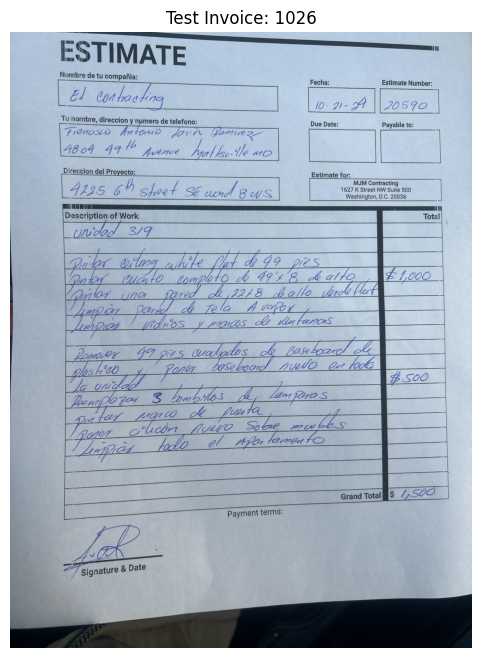

2025-03-23 16:36:10,380 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



⏳ Processing test image with 5 prompts...

🔄 Testing Prompt 1/5: basic_work_order (basic)
   Prompt text: "Extract the work order number from this invoice image."


2025-03-23 16:36:12,533 - src.execution.inference - INFO - Image 1026: ✗ | Extracted: '205' | GT: '20590' | Time: 2.15s
2025-03-23 16:36:12,534 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Raw Extraction: 'Extract the work order number from this invoice image.
Certainly! Here is the extracted information from the invoice image:

### Invoice Details:
- **Company Name:** El Contracting
- **Date:** 10-21-24
- **Estimate Number:** 205'
   Processed Extraction: '205'
   Exact Match: False
   Character Error Rate: 0.4000
   Processing Time: 2.15 seconds
   Total Time: 2.15 seconds

🔄 Testing Prompt 2/5: detailed_work_order (detailed)
   Prompt text: "This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar."


2025-03-23 16:36:14,478 - src.execution.inference - INFO - Image 1026: ✓ | Extracted: '20590' | GT: '20590' | Time: 1.94s
2025-03-23 16:36:14,481 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'


   Raw Extraction: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
It appears that the image you provided is an estimate document rather than an invoice. The document does not contain a work order number, as typically found on invoices. Instead, it includes an estimate number, which is "20590."'
   Processed Extraction: '20590'
   Exact Match: True
   Character Error Rate: 0.0000
   Processing Time: 1.94 seconds
   Total Time: 1.95 seconds

🔄 Testing Prompt 3/5: positioned_work_order (positioned)
   Prompt text: "Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice."


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-23 16:36:16,265 - src.execution.inference - INFO - Image 1026: ✓ | Extracted: '20590' | GT: '20590' | Time: 1.78s
2025-03-23 16:36:16,269 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Raw Extraction: 'Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
The work order number from the provided invoice image is **20590**. This number is located in the upper portion of the invoice under the "Estimate Number" section.'
   Processed Extraction: '20590'
   Exact Match: True
   Character Error Rate: 0.0000
   Processing Time: 1.78 seconds
   Total Time: 1.79 seconds

🔄 Testing Prompt 4/5: formatted_work_order (formatted)
   Prompt text: "Extract the work order number from this invoice. Return only the numeric value without any additional text."


2025-03-23 16:36:17,425 - src.execution.inference - INFO - Image 1026: ✓ | Extracted: '20590' | GT: '20590' | Time: 1.16s
2025-03-23 16:36:17,426 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Raw Extraction: 'Extract the work order number from this invoice. Return only the numeric value without any additional text.
The work order number from the invoice is **20590**.'
   Processed Extraction: '20590'
   Exact Match: True
   Character Error Rate: 0.0000
   Processing Time: 1.16 seconds
   Total Time: 1.16 seconds

🔄 Testing Prompt 5/5: work_order_cot (chain_of_thought)
   Prompt text: "To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number."


2025-03-23 16:36:19,424 - src.execution.inference - INFO - Image 1026: ✗ | Extracted: '1' | GT: '20590' | Time: 2.00s


   Raw Extraction: 'To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
To extract the work order number from the provided invoice, follow these steps:

1. **Scan the document for fields labeled as work order, order number, or similar.**
   - Look for any text that indicates a work order number, order number,'
   Processed Extraction: '1'
   Exact Match: False
   Character Error Rate: 1.0000
   Processing Time: 2.00 seconds
   Total Time: 2.00 seconds

📊 Prompt Comparison Results:


,Prompt Name,Category,Extracted Text,Exact Match,CER,Time (s)
0,basic_work_order,basic,205,False,0.4,2.152936
1,detailed_work_order,detailed,20590,True,0.0,1.943443
2,positioned_work_order,positioned,20590,True,0.0,1.783240
3,formatted_work_order,formatted,20590,True,0.0,1.156173
4,work_order_cot,chain_of_thought,1,False,1.0,1.997406



✅ Successful extractions: 3/5 (60.0%)
   Best performing prompts: detailed_work_order, positioned_work_order, formatted_work_order

💾 Test results saved to: /workspace/results/prompt_comparison_20250323_163114/single_image_prompt_comparison.json
⏱️ Total testing time: 9.05 seconds


In [19]:
# Single Image Test for All Prompts

# Import required libraries
import torch
import time
from PIL import Image
from Levenshtein import distance
import matplotlib.pyplot as plt
import random
import pandas as pd

# Try to import project-specific inference utilities
try:
    from src.execution.inference import process_image_with_metrics
    print("✅ Imported inference utilities")
    use_project_utils = True
except ImportError:
    print("⚠️ Project inference utilities not available, using direct implementation")
    use_project_utils = False
    
    # Define a direct implementation for single image processing
    def process_image_with_metrics(image_path, ground_truth, prompt, model_name, field_type, model, processor, metrics=None):
        """Process a single image and calculate metrics against ground truth"""
        start_time = time.time()
        
        try:
            # Load the image
            image = Image.open(image_path).convert("RGB")
            
            # Format the prompt with instruction tags
            formatted_prompt = prompt["formatted_text"]
            
            # Process using processor
            inputs = processor(
                text=formatted_prompt,
                images=[image],  # Notice we're passing a list here
                return_tensors="pt"
            )
            
            # Convert inputs to appropriate dtypes
            for key in inputs:
                if key == "pixel_values":
                    inputs[key] = inputs[key].to(dtype=next(model.parameters()).dtype, device=model.device)
                else:
                    inputs[key] = inputs[key].to(device=model.device)
            
            # Generate response
            with torch.no_grad():
                outputs = model.generate(**inputs, max_new_tokens=50, do_sample=False)
            
            # Decode the output
            raw_extraction = processor.batch_decode(
                outputs, 
                skip_special_tokens=True, 
                clean_up_tokenization_spaces=False
            )[0]
            
            # Process the output - clean up whitespace and extract just numbers if needed
            processed_extraction = raw_extraction.strip()
            
            # Calculate processing time
            processing_time = time.time() - start_time
            
            # Calculate metrics
            result = {
                "raw_extraction": raw_extraction,
                "processed_extraction": processed_extraction,
                "ground_truth": ground_truth,
                "processing_time": processing_time,
                "prompt_name": prompt["name"],
                "prompt_category": prompt["category"],
                "prompt_text": prompt["text"]
            }
            
            # Calculate exact match
            exact_match = processed_extraction.lower() == ground_truth.lower()
            result["exact_match"] = exact_match
            
            # Calculate character error rate (Levenshtein distance normalized by length)
            if len(ground_truth) > 0:
                cer = distance(processed_extraction, ground_truth) / len(ground_truth)
            else:
                cer = 1.0 if len(processed_extraction) > 0 else 0.0
            result["character_error_rate"] = cer
            
            return result
            
        except Exception as e:
            processing_time = time.time() - start_time
            return {
                "error": str(e),
                "processing_time": processing_time,
                "ground_truth": ground_truth,
                "raw_extraction": "ERROR",
                "processed_extraction": "ERROR",
                "exact_match": False,
                "character_error_rate": 1.0,
                "prompt_name": prompt["name"],
                "prompt_category": prompt["category"],
                "prompt_text": prompt["text"]
            }

# Verify we have the pipeline, model, and ground truth data
if 'pipeline' not in locals():
    print("❌ Pipeline not initialized. Run the pipeline initialization cell first.")
    raise RuntimeError("Pipeline not initialized")
    
if 'model' not in locals() or model is None:
    print("❌ Model not loaded. Run the model loading cell first.")
    raise RuntimeError("Model not loaded")
    
if len(ground_truth_mapping) == 0:
    print("❌ No ground truth data available. Run the ground truth data loading cell first.")
    raise RuntimeError("No ground truth data available")

if 'prompt_collection' not in locals() or not prompt_collection:
    print("❌ No prompts available. Run the prompt selection cell first.")
    raise RuntimeError("No prompts available")

print(f"🧪 Running a test on a single image with {len(prompt_collection)} different prompts...")

# Select a sample image
print("\n🔍 Selecting a test image...")
try:
    # Get all image paths
    image_paths = list(Path(paths["images_dir"]).glob("*.jpg")) + list(Path(paths["images_dir"]).glob("*.png"))
    
    if not image_paths:
        raise FileNotFoundError("No image files found")
    
    # Choose a random image that has ground truth data
    valid_images = [img for img in image_paths if img.stem in ground_truth_mapping]
    
    if not valid_images:
        print("⚠️ No images with ground truth found, using a random image")
        test_image = random.choice(image_paths)
    else:
        test_image = random.choice(valid_images)
    
    # Get ground truth for the test image
    test_image_id = test_image.stem
    ground_truth = ground_truth_mapping.get(test_image_id, {}).get('work_order', 'Unknown')
    
    print(f"✅ Selected test image: {test_image.name}")
    print(f"📋 Ground truth value: '{ground_truth}'")
    
    # Display the test image
    print("\n📸 Test Image:")
    img = Image.open(test_image)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Test Invoice: {test_image_id}")
    plt.show()
    
    # Initialize collection for test results
    test_results = []
    overall_start_time = time.time()
    
    # Test each prompt against the image
    print(f"\n⏳ Processing test image with {len(prompt_collection)} prompts...")
    
    for i, prompt in enumerate(prompt_collection, 1):
        print(f"\n🔄 Testing Prompt {i}/{len(prompt_collection)}: {prompt['name']} ({prompt['category']})")
        print(f"   Prompt text: \"{prompt['text']}\"")
        
        prompt_start_time = time.time()
        
        # Run the test using the pipeline or direct implementation
        if hasattr(pipeline, "process_single_image") and callable(getattr(pipeline, "process_single_image")):
            # Use pipeline's method if available
            result = pipeline.process_single_image(
                image_path=str(test_image),
                ground_truth=ground_truth,
                prompt=prompt,
                metrics=["exact_match", "character_error_rate"]
            )
        else:
            # Use direct implementation
            result = process_image_with_metrics(
                image_path=str(test_image),
                ground_truth=ground_truth,
                prompt=prompt,
                model_name=model_config["name"],
                field_type=extraction_config["field_to_extract"],
                model=model,
                processor=processor,
                metrics=["exact_match", "character_error_rate"]
            )
        
        # Calculate total time including setup
        prompt_total_time = time.time() - prompt_start_time
        result["total_test_time"] = prompt_total_time
        
        # Display prompt results
        print(f"   Raw Extraction: '{result.get('raw_extraction', 'ERROR')}'")
        print(f"   Processed Extraction: '{result.get('processed_extraction', 'ERROR')}'")
        print(f"   Exact Match: {result.get('exact_match', False)}")
        print(f"   Character Error Rate: {result.get('character_error_rate', 1.0):.4f}")
        print(f"   Processing Time: {result.get('processing_time', 0):.2f} seconds")
        print(f"   Total Time: {prompt_total_time:.2f} seconds")
        
        # Add to results collection
        result["prompt_name"] = prompt["name"]
        result["prompt_category"] = prompt["category"]
        result["prompt_text"] = prompt["text"]
        test_results.append(result)
    
    # Calculate overall time
    overall_time = time.time() - overall_start_time
    
    # Create a summary table of results
    results_df = pd.DataFrame([
        {
            "Prompt Name": r["prompt_name"],
            "Category": r["prompt_category"],
            "Extracted Text": r.get("processed_extraction", "ERROR"),
            "Exact Match": r.get("exact_match", False),
            "CER": r.get("character_error_rate", 1.0),
            "Time (s)": r.get("processing_time", 0)
        }
        for r in test_results
    ])
    
    # Display summary table
    print("\n📊 Prompt Comparison Results:")
    display(results_df)
    
    # Count successful extractions
    successful = sum(1 for r in test_results if r.get("exact_match", False))
    print(f"\n✅ Successful extractions: {successful}/{len(prompt_collection)} ({successful/len(prompt_collection)*100:.1f}%)")
    
    # Show the most successful prompts
    if successful > 0:
        best_prompts = [r["prompt_name"] for r in test_results if r.get("exact_match", False)]
        print(f"   Best performing prompts: {', '.join(best_prompts)}")
    
    # If none are exact matches, show the ones with lowest CER
    if successful == 0:
        # Sort by character error rate (ascending)
        sorted_results = sorted(test_results, key=lambda r: r.get("character_error_rate", 1.0))
        best_prompt = sorted_results[0]["prompt_name"]
        best_cer = sorted_results[0].get("character_error_rate", 1.0)
        print(f"   No exact matches. Best prompt: {best_prompt} (CER: {best_cer:.4f})")
    
    # Save test results
    test_results_path = get_results_path("single_image_prompt_comparison.json")
    with open(test_results_path, "w") as f:
        # Add image and test metadata
        test_summary = {
            "image_id": test_image_id,
            "image_path": str(test_image),
            "ground_truth": ground_truth,
            "test_timestamp": datetime.now().isoformat(),
            "total_test_time": overall_time,
            "prompt_count": len(prompt_collection),
            "successful_extractions": successful,
            "results": test_results
        }
        
        # Convert to serializable format
        import json
        json.dump(test_summary, f, indent=2)
    
    print(f"\n💾 Test results saved to: {test_results_path}")
    print(f"⏱️ Total testing time: {overall_time:.2f} seconds")
    
    # Store the results for reference
    test_summary_results = test_summary
    
except Exception as e:
    print(f"❌ Error during single image test: {e}")
    test_summary_results = {"error": str(e)}
    raise

### Full Extraction Test

In [20]:
# Full Extraction for All Prompts

# Import required libraries
import time
import torch
import gc
import json
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import math
import numpy as np
import os
import pandas as pd

# Verify pipeline, model, and other requirements are available
if 'pipeline' not in locals():
    print("❌ Pipeline not initialized. Run the pipeline initialization cell first.")
    raise RuntimeError("Pipeline not initialized")
    
if 'model' not in locals() or model is None:
    print("❌ Model not loaded. Run the model loading cell first.")
    raise RuntimeError("Model not loaded")
    
if 'batch_items' not in locals() or len(batch_items) == 0:
    print("❌ No batch items available. Run the ground truth data loading cell first.")
    raise RuntimeError("No batch items available")

if 'prompt_collection' not in locals() or not prompt_collection:
    print("❌ No prompts available. Run the prompt selection cell first.")
    raise RuntimeError("No prompts available")

# Verify test was successful before proceeding
if 'test_summary_results' not in locals() or 'error' in test_summary_results:
    print("⚠️ Warning: Single image test did not complete successfully.")
    proceed = input("Do you want to proceed with full extraction anyway? (y/n): ").strip().lower()
    if proceed != 'y':
        raise RuntimeError("Full extraction aborted by user. Run the single image test first.")

# Define utility functions for the extraction run
def format_eta(seconds):
    """Format seconds into a human-readable ETA string"""
    if seconds < 60:
        return f"{seconds:.0f} seconds"
    elif seconds < 3600:
        minutes = seconds / 60
        return f"{minutes:.1f} minutes"
    else:
        hours = seconds / 3600
        return f"{hours:.2f} hours"

def estimate_completion_time(current, total, elapsed_time):
    """Estimate completion time based on progress"""
    if current == 0 or elapsed_time <= 0:
        return "Calculating..."
    
    items_per_second = current / elapsed_time
    remaining_items = total - current
    
    if items_per_second > 0:
        remaining_seconds = remaining_items / items_per_second
        eta = format_eta(remaining_seconds)
        completion_time = datetime.now() + timedelta(seconds=remaining_seconds)
        formatted_time = completion_time.strftime("%H:%M:%S")
        return f"{eta} (completion around {formatted_time})"
    else:
        return "Unable to estimate"

def log_memory_usage(step, info=None):
    """Log GPU memory usage for monitoring"""
    if not torch.cuda.is_available():
        return None
    
    memory_info = {
        "step": step,
        "timestamp": time.time(),
        "total_memory_gb": torch.cuda.get_device_properties(0).total_memory / 1e9,
        "allocated_memory_gb": torch.cuda.memory_allocated(0) / 1e9,
        "reserved_memory_gb": torch.cuda.memory_reserved(0) / 1e9,
        "info": info
    }
    
    # Calculate free memory (total - allocated)
    memory_info["free_memory_gb"] = memory_info["total_memory_gb"] - memory_info["allocated_memory_gb"]
    
    return memory_info

# Set up checkpoint path for resuming
checkpoint_path = get_results_path("prompt_comparison_checkpoint.json")
checkpoint_frequency = pipeline_config["checkpointing"]["checkpoint_frequency"]
enable_checkpoints = pipeline_config["checkpointing"]["enable_checkpoints"]

# Limit the number of images to process (if specified in comparison config)
image_limit = comparison_config.get("image_count", len(batch_items))
if image_limit < len(batch_items):
    print(f"⚙️ Limiting extraction to first {image_limit} images (out of {len(batch_items)})")
    batch_items = batch_items[:image_limit]
else:
    print(f"⚙️ Processing all {len(batch_items)} images with each prompt")

# Initialize result storage dictionary - organized by prompt
results_by_prompt = {}
for prompt in prompt_collection:
    prompt_name = prompt["name"]
    results_by_prompt[prompt_name] = []

# Initialize tracking
current_prompt_idx = 0
prompt_states = {p["name"]: "pending" for p in prompt_collection}  # pending, in_progress, completed
completed_prompts = []

# Check for existing checkpoint if resuming is enabled
if os.path.exists(checkpoint_path) and enable_checkpoints:
    try:
        with open(checkpoint_path, "r") as f:
            checkpoint = json.load(f)
        
        if "results_by_prompt" in checkpoint:
            # Load results from checkpoint
            results_by_prompt = checkpoint["results_by_prompt"]
            completed_prompts = checkpoint.get("completed_prompts", [])
            current_prompt_idx = checkpoint.get("current_prompt_index", 0)
            prompt_states = checkpoint.get("prompt_states", prompt_states)
            
            # Count results
            total_results = sum(len(results) for results in results_by_prompt.values())
            print(f"📂 Resuming from checkpoint: {total_results} total results already processed")
            print(f"   Completed prompts: {', '.join(completed_prompts)}")
            if current_prompt_idx < len(prompt_collection):
                current_prompt = prompt_collection[current_prompt_idx]["name"]
                print(f"   Current prompt: {current_prompt} ({len(results_by_prompt.get(current_prompt, []))} images processed)")
    except Exception as e:
        print(f"⚠️ Error loading checkpoint: {e}")
        print("   Starting from the beginning")

# Determine batch size to use
batch_size = pipeline_config["batch_processing"].get("batch_size", 1)
print(f"🔢 Using batch size: {batch_size}")

# Calculate total operations
total_prompts = len(prompt_collection)
total_images = len(batch_items)
total_operations = total_prompts * total_images
completed_operations = sum(len(results) for results in results_by_prompt.values())
remaining_operations = total_operations - completed_operations

print(f"\n📊 Experiment Scale:")
print(f"   Prompts to compare: {total_prompts}")
print(f"   Images per prompt: {total_images}")
print(f"   Total operations: {total_operations}")
print(f"   Already completed: {completed_operations}")
print(f"   Remaining: {remaining_operations}")

# Display confirmation and execution plan
print("\n🚀 Starting prompt comparison pipeline...")
print(f"💾 Checkpointing: {'Enabled' if enable_checkpoints else 'Disabled'}")
if enable_checkpoints:
    print(f"   Saving checkpoint every {checkpoint_frequency} batches to: {checkpoint_path}")

# Ask for confirmation before proceeding
proceed = input("\n💬 Proceed with full prompt comparison? This may take a while. (y/n): ").strip().lower()
if proceed != 'y':
    print("❌ Extraction canceled by user.")
    raise RuntimeError("Extraction canceled by user.")

# Record start time for the full extraction
full_start_time = time.time()
memory_log = []
memory_log.append(log_memory_usage("start", "Before extraction starts"))

# Create master results tracking
all_results = {
    "timestamp": datetime.now().isoformat(),
    "model": model_config["name"],
    "total_prompts": total_prompts,
    "total_images": total_images,
    "results_by_prompt": results_by_prompt,
    "prompt_summaries": {},
    "comparison_metrics": {}
}

# Main execution loop - process each prompt
try:
    # Start from the current prompt (for resuming)
    for prompt_idx in range(current_prompt_idx, len(prompt_collection)):
        prompt = prompt_collection[prompt_idx]
        prompt_name = prompt["name"]
        prompt_category = prompt["category"]
        
        # Skip if this prompt is already completed
        if prompt_name in completed_prompts:
            print(f"\n✅ Prompt {prompt_idx+1}/{len(prompt_collection)}: '{prompt_name}' already completed, skipping...")
            continue
        
        # Set up for this prompt
        print(f"\n🔄 Processing Prompt {prompt_idx+1}/{len(prompt_collection)}: '{prompt_name}' ({prompt_category})")
        print(f"   Prompt text: \"{prompt['text']}\"")
        print(f"   Formatted: \"{prompt['formatted_text']}\"")
        
        # Update prompt state
        prompt_states[prompt_name] = "in_progress"
        
        # Get already processed results for this prompt
        processed_items = results_by_prompt.get(prompt_name, [])
        processed_ids = [item["image_id"] for item in processed_items]
        
        # Filter out already processed images for this prompt
        current_batch_items = [item for item in batch_items if item["image_id"] not in processed_ids]
        
        # If all images for this prompt are already processed, skip to next prompt
        if not current_batch_items:
            print(f"✅ All images already processed for prompt '{prompt_name}', marking as completed")
            completed_prompts.append(prompt_name)
            prompt_states[prompt_name] = "completed"
            current_prompt_idx = prompt_idx + 1
            
            # Save checkpoint
            if enable_checkpoints:
                checkpoint = {
                    "timestamp": time.time(),
                    "current_prompt_index": current_prompt_idx,
                    "completed_prompts": completed_prompts,
                    "prompt_states": prompt_states,
                    "results_by_prompt": results_by_prompt
                }
                with open(checkpoint_path, "w") as f:
                    json.dump(checkpoint, f)
                print(f"💾 Checkpoint saved after completing prompt '{prompt_name}'")
            
            continue
        
        # Process images for this prompt
        prompt_start_time = time.time()
        num_batches = math.ceil(len(current_batch_items) / batch_size)
        
        print(f"\n⏳ Processing {len(current_batch_items)} images with prompt '{prompt_name}'...")
        print(f"   Divided into {num_batches} batches of size {batch_size}")
        
        # Process in batches
        for batch_idx in range(num_batches):
            batch_start_time = time.time()
            
            # Get current batch
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(current_batch_items))
            current_batch = current_batch_items[start_idx:end_idx]
            
            # Skip if batch is empty
            if not current_batch:
                print(f"⚠️ Batch {batch_idx+1}/{num_batches} is empty, skipping")
                continue
            
            print(f"\n🔄 Processing Batch {batch_idx+1}/{num_batches} ({len(current_batch)} images)")
            
            # Log memory before batch
            memory_log.append(log_memory_usage(f"prompt_{prompt_idx}_batch_{batch_idx}_start", 
                                               f"Before prompt '{prompt_name}' batch {batch_idx+1}"))
            
            # Process each item in the batch
            batch_results = []
            for i, item in enumerate(current_batch):
                item_start_time = time.time()
                
                # Display progress
                current_prompt_progress = len(processed_items) + len(batch_results) + 1
                total_prompt_items = len(current_batch_items) + len(processed_items)
                
                # Calculate overall progress across all prompts
                overall_completed = completed_operations + current_prompt_progress
                overall_percentage = (overall_completed / total_operations) * 100
                
                # Calculate ETA
                elapsed_time = time.time() - full_start_time
                eta = estimate_completion_time(overall_completed, total_operations, elapsed_time)
                
                print(f"\n⏳ Prompt {prompt_idx+1}/{total_prompts}: '{prompt_name}' | "
                      f"Image {current_prompt_progress}/{total_prompt_items} | "
                      f"Overall: {overall_percentage:.1f}% complete | ETA: {eta}")
                
                # Process the item
                try:
                    if hasattr(pipeline, "process_single_image") and callable(getattr(pipeline, "process_single_image")):
                        # Use pipeline's method if available
                        result = pipeline.process_single_image(
                            image_path=item["image_path"],
                            ground_truth=item["ground_truth"],
                            prompt=prompt,
                            metrics=["exact_match", "character_error_rate"]
                        )
                    else:
                        # Use direct implementation
                        result = process_image_with_metrics(
                            image_path=item["image_path"],
                            ground_truth=item["ground_truth"],
                            prompt=prompt,
                            model_name=model_config["name"],
                            field_type=extraction_config["field_to_extract"],
                            model=model,
                            processor=processor,
                            metrics=["exact_match", "character_error_rate"]
                        )
                    
                    # Add metadata to result
                    result["image_id"] = item["image_id"]
                    result["prompt_name"] = prompt_name
                    result["prompt_category"] = prompt_category
                    result["prompt_text"] = prompt["text"]
                    result["processing_timestamp"] = datetime.now().isoformat()
                    result["batch_idx"] = batch_idx
                    result["item_idx"] = i
                    
                    # Display result
                    exact_match = result.get("exact_match", False)
                    match_symbol = "✓" if exact_match else "✗"
                    print(f"   Result: {match_symbol} | Extracted: '{result.get('processed_extraction', 'ERROR')}' | "
                          f"GT: '{result.get('ground_truth', 'Unknown')}' | "
                          f"CER: {result.get('character_error_rate', 1.0):.4f} | "
                          f"Time: {result.get('processing_time', 0):.2f}s")
                    
                    # Add to batch results
                    batch_results.append(result)
                    
                except Exception as e:
                    print(f"❌ Error processing item {item['image_id']} with prompt '{prompt_name}': {e}")
                    # Add error result
                    error_result = {
                        "image_id": item["image_id"],
                        "prompt_name": prompt_name,
                        "prompt_category": prompt_category,
                        "prompt_text": prompt["text"],
                        "error": str(e),
                        "processing_timestamp": datetime.now().isoformat(),
                        "batch_idx": batch_idx,
                        "item_idx": i,
                        "ground_truth": item["ground_truth"],
                        "exact_match": False,
                        "character_error_rate": 1.0
                    }
                    batch_results.append(error_result)
            
            # Add batch results to results for this prompt
            results_by_prompt[prompt_name].extend(batch_results)
            
            # Update completed operations count
            completed_operations += len(batch_results)
            
            # Log memory after batch
            memory_log.append(log_memory_usage(f"prompt_{prompt_idx}_batch_{batch_idx}_end", 
                                              f"After prompt '{prompt_name}' batch {batch_idx+1}"))
            
            # Calculate batch statistics
            batch_time = time.time() - batch_start_time
            avg_item_time = batch_time / len(current_batch) if current_batch else 0
            exact_matches = sum(1 for r in batch_results if r.get("exact_match", False))
            accuracy = (exact_matches / len(current_batch) * 100) if current_batch else 0
            
            print(f"\n📊 Batch {batch_idx+1} Summary:")
            print(f"   Processed {len(current_batch)} items in {batch_time:.2f}s ({avg_item_time:.2f}s per item)")
            print(f"   Exact Match: {exact_matches}/{len(current_batch)} ({accuracy:.1f}%)")
            
            # Clean up memory between batches if configured
            if pipeline_config["batch_processing"].get("optimize_memory", True):
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    print("   🧹 Cleaned up memory")
            
            # Save checkpoint if enabled
            if enable_checkpoints and (batch_idx + 1) % checkpoint_frequency == 0:
                checkpoint = {
                    "timestamp": time.time(),
                    "current_prompt_index": prompt_idx,
                    "completed_prompts": completed_prompts,
                    "prompt_states": prompt_states,
                    "results_by_prompt": results_by_prompt
                }
                with open(checkpoint_path, "w") as f:
                    json.dump(checkpoint, f)
                
                print(f"   💾 Saved checkpoint after batch {batch_idx+1}")
        
        # Calculate prompt summary statistics
        prompt_time = time.time() - prompt_start_time
        prompt_results = results_by_prompt[prompt_name]
        prompt_exact_matches = sum(1 for r in prompt_results if r.get("exact_match", False))
        prompt_accuracy = (prompt_exact_matches / len(prompt_results) * 100) if prompt_results else 0
        avg_cer = sum(r.get("character_error_rate", 1.0) for r in prompt_results) / len(prompt_results) if prompt_results else 0
        avg_time = sum(r.get("processing_time", 0) for r in prompt_results) / len(prompt_results) if prompt_results else 0
        
        # Store prompt summary
        prompt_summary = {
            "prompt_name": prompt_name,
            "prompt_category": prompt_category,
            "total_images": len(prompt_results),
            "exact_matches": prompt_exact_matches,
            "accuracy": prompt_accuracy,
            "avg_character_error_rate": avg_cer,
            "avg_processing_time": avg_time,
            "total_processing_time": prompt_time
        }
        
        # Add to master results
        all_results["prompt_summaries"][prompt_name] = prompt_summary
        
        # Display prompt summary
        print(f"\n📊 Prompt '{prompt_name}' Summary:")
        print(f"   Processed {len(prompt_results)} images in {prompt_time:.2f}s")
        print(f"   Exact Match Accuracy: {prompt_exact_matches}/{len(prompt_results)} ({prompt_accuracy:.1f}%)")
        print(f"   Average Character Error Rate: {avg_cer:.4f}")
        print(f"   Average Processing Time: {avg_time:.2f}s per image")
        
        # Mark prompt as completed
        completed_prompts.append(prompt_name)
        prompt_states[prompt_name] = "completed"
        current_prompt_idx = prompt_idx + 1
        
        # Save checkpoint after completing a prompt
        if enable_checkpoints:
            checkpoint = {
                "timestamp": time.time(),
                "current_prompt_index": current_prompt_idx,
                "completed_prompts": completed_prompts,
                "prompt_states": prompt_states,
                "results_by_prompt": results_by_prompt
            }
            with open(checkpoint_path, "w") as f:
                json.dump(checkpoint, f)
            print(f"💾 Checkpoint saved after completing prompt '{prompt_name}'")
    
    # All prompts completed!
    
    # Log final memory usage
    memory_log.append(log_memory_usage("end", "After all prompts complete"))
    
    # Calculate overall completion time
    total_time = time.time() - full_start_time
    
    # Add comparison metrics
    prompt_summaries = list(all_results["prompt_summaries"].values())
    
    # Create sorted list of prompts by accuracy
    sorted_by_accuracy = sorted(prompt_summaries, key=lambda x: x["accuracy"], reverse=True)
    best_prompt = sorted_by_accuracy[0]["prompt_name"] if sorted_by_accuracy else "None"
    
    # Create sorted list of prompts by CER
    sorted_by_cer = sorted(prompt_summaries, key=lambda x: x["avg_character_error_rate"])
    best_cer_prompt = sorted_by_cer[0]["prompt_name"] if sorted_by_cer else "None"
    
    # Create sorted list of prompts by speed
    sorted_by_speed = sorted(prompt_summaries, key=lambda x: x["avg_processing_time"])
    fastest_prompt = sorted_by_speed[0]["prompt_name"] if sorted_by_speed else "None"
    
    # Store comparison metrics
    all_results["comparison_metrics"] = {
        "best_accuracy_prompt": best_prompt,
        "best_cer_prompt": best_cer_prompt,
        "fastest_prompt": fastest_prompt,
        "total_processing_time": total_time,
        "total_operations": total_operations
    }
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame([
        {
            "Prompt": p["prompt_name"],
            "Category": p["prompt_category"],
            "Accuracy (%)": p["accuracy"],
            "CER": p["avg_character_error_rate"],
            "Avg Time (s)": p["avg_processing_time"]
        }
        for p in prompt_summaries
    ]).sort_values("Accuracy (%)", ascending=False)
    
    # Display final comparison table
    print("\n📊 Prompt Comparison Results:")
    display(comparison_df)
    
    # Save all results
    results_path = get_results_path("prompt_comparison_results.json")
    with open(results_path, "w") as f:
        json.dump(all_results, f, indent=2)
    
    # Save individual prompt results
    for prompt_name, results in results_by_prompt.items():
        prompt_results_path = get_results_path(f"prompt_{prompt_name}_results.json")
        with open(prompt_results_path, "w") as f:
            json.dump(results, f, indent=2)
    
    # Save memory log
    memory_log_path = get_results_path("memory_usage_log.json")
    with open(memory_log_path, "w") as f:
        json.dump(memory_log, f, indent=2)
    
    print(f"\n💾 Results saved to: {results_path}")
    print(f"💾 Memory usage log saved to: {memory_log_path}")
    
    # Print final summary
    print("\n🎉 Prompt Comparison Complete!")
    print(f"   Compared {len(prompt_collection)} prompts across {total_images} images")
    print(f"   Total processing time: {total_time:.2f}s ({format_eta(total_time)})")
    print(f"   Best accuracy: {best_prompt} ({sorted_by_accuracy[0]['accuracy']:.1f}%)")
    print(f"   Best character error rate: {best_cer_prompt} ({sorted_by_cer[0]['avg_character_error_rate']:.4f})")
    print(f"   Fastest processing: {fastest_prompt} ({sorted_by_speed[0]['avg_processing_time']:.2f}s per image)")
    
    # Store results for analysis
    prompt_comparison_results = all_results
    
except Exception as e:
    print(f"\n❌ Error during prompt comparison: {e}")
    
    # Try to save partial results
    try:
        partial_results_path = get_results_path("partial_prompt_comparison_results.json")
        with open(partial_results_path, "w") as f:
            json.dump({
                "timestamp": datetime.now().isoformat(),
                "error": str(e),
                "results_by_prompt": results_by_prompt,
                "completed_prompts": completed_prompts,
                "prompt_states": prompt_states
            }, f, indent=2)
        
        print(f"💾 Partial results saved to: {partial_results_path}")
    except Exception as save_error:
        print(f"❌ Error saving partial results: {save_error}")
    
    # Try to save memory log
    if memory_log:
        try:
            memory_log.append(log_memory_usage("error", f"Error: {str(e)}"))
            memory_log_path = get_results_path("error_memory_usage_log.json")
            with open(memory_log_path, "w") as f:
                json.dump(memory_log, f, indent=2)
            
            print(f"💾 Memory usage log saved to: {memory_log_path}")
        except Exception as log_error:
            print(f"❌ Error saving memory log: {log_error}")
    
    raise

finally:
    # Clean up memory regardless of success or failure
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

⚙️ Processing all 20 images with each prompt
🔢 Using batch size: 16

📊 Experiment Scale:
   Prompts to compare: 5
   Images per prompt: 20
   Total operations: 100
   Already completed: 0
   Remaining: 100

🚀 Starting prompt comparison pipeline...
💾 Checkpointing: Enabled
   Saving checkpoint every 5 batches to: /workspace/results/prompt_comparison_20250323_163114/prompt_comparison_checkpoint.json



💬 Proceed with full prompt comparison? This may take a while. (y/n):  y


2025-03-23 16:41:07,901 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'



🔄 Processing Prompt 1/5: 'basic_work_order' (basic)
   Prompt text: "Extract the work order number from this invoice image."
   Formatted: "<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]"

⏳ Processing 20 images with prompt 'basic_work_order'...
   Divided into 2 batches of size 16

🔄 Processing Batch 1/2 (16 images)

⏳ Prompt 1/5: 'basic_work_order' | Image 1/20 | Overall: 1.0% complete | ETA: 0 seconds (completion around 16:41:08)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-23 16:41:09,235 - src.execution.inference - INFO - Image 1043: ✓ | Extracted: '20458' | GT: '20458' | Time: 1.33s
2025-03-23 16:41:09,240 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20458' | GT: '20458' | CER: 0.0000 | Time: 1.33s

⏳ Prompt 1/5: 'basic_work_order' | Image 2/20 | Overall: 2.0% complete | ETA: 1.1 minutes (completion around 16:42:14)


2025-03-23 16:41:10,468 - src.execution.inference - INFO - Image 1042: ✓ | Extracted: '20455' | GT: '20455' | Time: 1.23s
2025-03-23 16:41:10,469 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20455' | GT: '20455' | CER: 0.0000 | Time: 1.23s

⏳ Prompt 1/5: 'basic_work_order' | Image 3/20 | Overall: 3.0% complete | ETA: 1.4 minutes (completion around 16:42:33)


2025-03-23 16:41:12,532 - src.execution.inference - INFO - Image 1041: ✗ | Extracted: 'Extract the work order number from this invoice image.
The image you provided appears to be an estimate form for a contracting job. However, it does not explicitly show a "work order number." Typically, a work order number is a unique identifier assigned to a specific job or task. In this case,' | GT: 'Aston' | Time: 2.06s
2025-03-23 16:41:12,534 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: 'Extract the work order number from this invoice image.
The image you provided appears to be an estimate form for a contracting job. However, it does not explicitly show a "work order number." Typically, a work order number is a unique identifier assigned to a specific job or task. In this case,' | GT: 'Aston' | CER: 58.2000 | Time: 2.06s

⏳ Prompt 1/5: 'basic_work_order' | Image 4/20 | Overall: 4.0% complete | ETA: 1.9 minutes (completion around 16:43:03)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-23 16:41:14,762 - src.execution.inference - INFO - Image 1040: ✗ | Extracted: 'Extract the work order number from this invoice image.
To extract the work order number from the provided invoice image, we need to identify the specific section or field that typically contains this information. Invoices often have designated fields for work order numbers, which might be labeled as "Work Order Number," "Order' | GT: 'Aston' | Time: 2.23s
2025-03-23 16:41:14,766 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'Extract the work order number from this invoice image.
To extract the work order number from the provided invoice image, we need to identify the specific section or field that typically contains this information. Invoices often have designated fields for work order numbers, which might be labeled as "Work Order Number," "Order' | GT: 'Aston' | CER: 64.8000 | Time: 2.23s

⏳ Prompt 1/5: 'basic_work_order' | Image 5/20 | Overall: 5.0% complete | ETA: 2.2 minutes (completion around 16:43:25)


2025-03-23 16:41:16,100 - src.execution.inference - INFO - Image 1039: ✗ | Extracted: '24' | GT: '20662' | Time: 1.33s
2025-03-23 16:41:16,102 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '24' | GT: '20662' | CER: 0.8000 | Time: 1.33s

⏳ Prompt 1/5: 'basic_work_order' | Image 6/20 | Overall: 6.0% complete | ETA: 2.1 minutes (completion around 16:43:24)


2025-03-23 16:41:17,435 - src.execution.inference - INFO - Image 1038: ✗ | Extracted: '24' | GT: '20591' | Time: 1.33s
2025-03-23 16:41:17,437 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '24' | GT: '20591' | CER: 0.8000 | Time: 1.33s

⏳ Prompt 1/5: 'basic_work_order' | Image 7/20 | Overall: 7.0% complete | ETA: 2.1 minutes (completion around 16:43:24)


2025-03-23 16:41:18,697 - src.execution.inference - INFO - Image 1031: ✗ | Extracted: '20609' | GT: '20604' | Time: 1.26s
2025-03-23 16:41:18,699 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20609' | GT: '20604' | CER: 0.2000 | Time: 1.26s

⏳ Prompt 1/5: 'basic_work_order' | Image 8/20 | Overall: 8.0% complete | ETA: 2.1 minutes (completion around 16:43:22)


2025-03-23 16:41:19,920 - src.execution.inference - INFO - Image 1030: ✓ | Extracted: '20628' | GT: '20628' | Time: 1.22s
2025-03-23 16:41:19,921 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20628' | GT: '20628' | CER: 0.0000 | Time: 1.22s

⏳ Prompt 1/5: 'basic_work_order' | Image 9/20 | Overall: 9.0% complete | ETA: 2.0 minutes (completion around 16:43:21)


2025-03-23 16:41:21,911 - src.execution.inference - INFO - Image 1029: ✗ | Extracted: '500' | GT: '20677' | Time: 1.99s
2025-03-23 16:41:21,913 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '500' | GT: '20677' | CER: 0.8000 | Time: 1.99s

⏳ Prompt 1/5: 'basic_work_order' | Image 10/20 | Overall: 10.0% complete | ETA: 2.1 minutes (completion around 16:43:28)


2025-03-23 16:41:23,910 - src.execution.inference - INFO - Image 1028: ✗ | Extracted: '6' | GT: '20658' | Time: 2.00s
2025-03-23 16:41:23,912 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '6' | GT: '20658' | CER: 0.8000 | Time: 2.00s

⏳ Prompt 1/5: 'basic_work_order' | Image 11/20 | Overall: 11.0% complete | ETA: 2.2 minutes (completion around 16:43:33)


2025-03-23 16:41:25,124 - src.execution.inference - INFO - Image 1027: ✗ | Extracted: '20683' | GT: '20633' | Time: 1.21s
2025-03-23 16:41:25,125 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20683' | GT: '20633' | CER: 0.2000 | Time: 1.21s

⏳ Prompt 1/5: 'basic_work_order' | Image 12/20 | Overall: 12.0% complete | ETA: 2.1 minutes (completion around 16:43:31)


2025-03-23 16:41:27,130 - src.execution.inference - INFO - Image 1026: ✗ | Extracted: '205' | GT: '20590' | Time: 2.00s
2025-03-23 16:41:27,131 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '205' | GT: '20590' | CER: 0.4000 | Time: 2.00s

⏳ Prompt 1/5: 'basic_work_order' | Image 13/20 | Overall: 13.0% complete | ETA: 2.1 minutes (completion around 16:43:35)


2025-03-23 16:41:28,325 - src.execution.inference - INFO - Image 1025: ✗ | Extracted: '019' | GT: '20570' | Time: 1.19s
2025-03-23 16:41:28,327 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '019' | GT: '20570' | CER: 0.8000 | Time: 1.19s

⏳ Prompt 1/5: 'basic_work_order' | Image 14/20 | Overall: 14.0% complete | ETA: 2.1 minutes (completion around 16:43:33)


2025-03-23 16:41:30,317 - src.execution.inference - INFO - Image 1023: ✗ | Extracted: '801' | GT: '20548' | Time: 1.99s
2025-03-23 16:41:30,319 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '801' | GT: '20548' | CER: 0.8000 | Time: 1.99s

⏳ Prompt 1/5: 'basic_work_order' | Image 15/20 | Overall: 15.0% complete | ETA: 2.1 minutes (completion around 16:43:37)


2025-03-23 16:41:32,323 - src.execution.inference - INFO - Image 1022: ✗ | Extracted: '2023' | GT: '20525' | Time: 2.00s
2025-03-23 16:41:32,324 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '2023' | GT: '20525' | CER: 0.4000 | Time: 2.00s

⏳ Prompt 1/5: 'basic_work_order' | Image 16/20 | Overall: 16.0% complete | ETA: 2.1 minutes (completion around 16:43:40)


2025-03-23 16:41:33,587 - src.execution.inference - INFO - Image 1021: ✓ | Extracted: '20516' | GT: '20516' | Time: 1.26s
2025-03-23 16:41:33,866 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20516' | GT: '20516' | CER: 0.0000 | Time: 1.26s

📊 Batch 1 Summary:
   Processed 16 items in 25.69s (1.61s per item)
   Exact Match: 4/16 (25.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 2/2 (4 images)

⏳ Prompt 1/5: 'basic_work_order' | Image 17/36 | Overall: 33.0% complete | ETA: 53 seconds (completion around 16:42:26)


2025-03-23 16:41:35,129 - src.execution.inference - INFO - Image 1020: ✗ | Extracted: '20179' | GT: '20479' | Time: 1.26s
2025-03-23 16:41:35,131 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20179' | GT: '20479' | CER: 0.2000 | Time: 1.26s

⏳ Prompt 1/5: 'basic_work_order' | Image 18/36 | Overall: 34.0% complete | ETA: 53 seconds (completion around 16:42:27)


2025-03-23 16:41:37,061 - src.execution.inference - INFO - Image 1019: ✓ | Extracted: '20509' | GT: '20509' | Time: 1.93s
2025-03-23 16:41:37,063 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20509' | GT: '20509' | CER: 0.0000 | Time: 1.93s

⏳ Prompt 1/5: 'basic_work_order' | Image 19/36 | Overall: 35.0% complete | ETA: 54 seconds (completion around 16:42:31)


2025-03-23 16:41:38,303 - src.execution.inference - INFO - Image 1018: ✓ | Extracted: '20558' | GT: '20558' | Time: 1.24s
2025-03-23 16:41:38,304 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20558' | GT: '20558' | CER: 0.0000 | Time: 1.24s

⏳ Prompt 1/5: 'basic_work_order' | Image 20/36 | Overall: 36.0% complete | ETA: 54 seconds (completion around 16:42:32)


2025-03-23 16:41:39,569 - src.execution.inference - INFO - Image 1017: ✓ | Extracted: '20502' | GT: '20502' | Time: 1.26s
2025-03-23 16:41:39,786 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'


   Result: ✓ | Extracted: '20502' | GT: '20502' | CER: 0.0000 | Time: 1.26s

📊 Batch 2 Summary:
   Processed 4 items in 5.70s (1.43s per item)
   Exact Match: 3/4 (75.0%)
   🧹 Cleaned up memory

📊 Prompt 'basic_work_order' Summary:
   Processed 20 images in 31.88s
   Exact Match Accuracy: 7/20 (35.0%)
   Average Character Error Rate: 6.4600
   Average Processing Time: 1.57s per image
💾 Checkpoint saved after completing prompt 'basic_work_order'

🔄 Processing Prompt 2/5: 'detailed_work_order' (detailed)
   Prompt text: "This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar."
   Formatted: "<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]"

⏳ Processing 20 images with prompt 'detailed_work_order'...
   Divided into 2 batches of size 16

🔄 Processing Batch 1/2 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-23 16:41:41,785 - src.execution.inference - INFO - Image 1043: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
The image you provided appears to be an estimate document, not an invoice. However, I can help you identify the relevant information. In the provided image, there is no explicit label for "Work Order Number," "Numero de Orden," "Order #' | GT: '20458' | Time: 2.00s
2025-03-23 16:41:41,787 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
The image you provided appears to be an estimate document, not an invoice. However, I can help you identify the relevant information. In the provided image, there is no explicit label for "Work Order Number," "Numero de Orden," "Order #' | GT: '20458' | CER: 78.6000 | Time: 2.00s

⏳ Prompt 2/5: 'detailed_work_order' | Image 2/20 | Overall: 22.0% complete | ETA: 2.0 minutes (completion around 16:43:41)


2025-03-23 16:41:43,721 - src.execution.inference - INFO - Image 1042: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
The image you provided appears to be an estimate or invoice document. However, it does not contain any of the labels you mentioned for the work order number, such as "Work Order Number," "Numero de Orden," "Order #," or similar.' | GT: '20455' | Time: 1.93s
2025-03-23 16:41:43,723 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
The image you provided appears to be an estimate or invoice document. However, it does not contain any of the labels you mentioned for the work order number, such as "Work Order Number," "Numero de Orden," "Order #," or similar.' | GT: '20455' | CER: 77.0000 | Time: 1.93s

⏳ Prompt 2/5: 'detailed_work_order' | Image 3/20 | Overall: 23.0% complete | ETA: 2.0 minutes (completion around 16:43:43)


2025-03-23 16:41:45,300 - src.execution.inference - INFO - Image 1041: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
I'm sorry, but I can't find any information about a work order number in the image you provided. Could you please check the image again or provide more details?' | GT: 'Aston' | Time: 1.58s
2025-03-23 16:41:45,301 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
I'm sorry, but I can't find any information about a work order number in the image you provided. Could you please check the image again or provide more details?' | GT: 'Aston' | CER: 62.6000 | Time: 1.58s

⏳ Prompt 2/5: 'detailed_work_order' | Image 4/20 | Overall: 24.0% complete | ETA: 2.0 minutes (completion around 16:43:43)


2025-03-23 16:41:46,873 - src.execution.inference - INFO - Image 1040: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
I'm sorry, but I can't find any information about a work order number on the provided invoice image. Could you please check the image again or provide more details?' | GT: 'Aston' | Time: 1.57s
2025-03-23 16:41:46,874 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
I'm sorry, but I can't find any information about a work order number on the provided invoice image. Could you please check the image again or provide more details?' | GT: 'Aston' | CER: 63.4000 | Time: 1.57s

⏳ Prompt 2/5: 'detailed_work_order' | Image 5/20 | Overall: 25.0% complete | ETA: 1.9 minutes (completion around 16:43:43)


2025-03-23 16:41:48,821 - src.execution.inference - INFO - Image 1039: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
The image you provided appears to be an estimate document, but it does not contain any of the labels you mentioned for a work order number, such as "Work Order Number," "Numero de Orden," "Order #," or similar. The document includes' | GT: '20662' | Time: 1.95s
2025-03-23 16:41:48,823 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
The image you provided appears to be an estimate document, but it does not contain any of the labels you mentioned for a work order number, such as "Work Order Number," "Numero de Orden," "Order #," or similar. The document includes' | GT: '20662' | CER: 77.8000 | Time: 1.95s

⏳ Prompt 2/5: 'detailed_work_order' | Image 6/20 | Overall: 26.0% complete | ETA: 1.9 minutes (completion around 16:43:45)


2025-03-23 16:41:50,804 - src.execution.inference - INFO - Image 1038: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
The image you provided appears to be an estimate form, but it does not contain any of the labels you mentioned for a work order number, such as "Work Order Number," "Numero de Orden," "Order #," or similar. The form includes' | GT: '20591' | Time: 1.98s
2025-03-23 16:41:50,805 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
The image you provided appears to be an estimate form, but it does not contain any of the labels you mentioned for a work order number, such as "Work Order Number," "Numero de Orden," "Order #," or similar. The form includes' | GT: '20591' | CER: 76.2000 | Time: 1.98s

⏳ Prompt 2/5: 'detailed_work_order' | Image 7/20 | Overall: 27.0% complete | ETA: 1.9 minutes (completion around 16:43:46)


2025-03-23 16:41:52,742 - src.execution.inference - INFO - Image 1031: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
I'm sorry, but I can't find any information about a "work order number" or similar labels such as "Numero de Orden" or "Order #" in the provided image. Could you please check the image again or provide more details?' | GT: '20604' | Time: 1.94s
2025-03-23 16:41:52,744 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
I'm sorry, but I can't find any information about a "work order number" or similar labels such as "Numero de Orden" or "Order #" in the provided image. Could you please check the image again or provide more details?' | GT: '20604' | CER: 74.4000 | Time: 1.94s

⏳ Prompt 2/5: 'detailed_work_order' | Image 8/20 | Overall: 28.0% complete | ETA: 1.9 minutes (completion around 16:43:48)


2025-03-23 16:41:54,677 - src.execution.inference - INFO - Image 1030: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
I'm sorry, but I can't find any information about a work order number in the image you provided. Could you please check the image again and make sure it contains the work order number? If you have any other questions or need further assistance,' | GT: '20628' | Time: 1.93s
2025-03-23 16:41:54,678 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
I'm sorry, but I can't find any information about a work order number in the image you provided. Could you please check the image again and make sure it contains the work order number? If you have any other questions or need further assistance,' | GT: '20628' | CER: 80.2000 | Time: 1.93s

⏳ Prompt 2/5: 'detailed_work_order' | Image 9/20 | Overall: 29.0% complete | ETA: 1.9 minutes (completion around 16:43:49)


2025-03-23 16:41:56,606 - src.execution.inference - INFO - Image 1029: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
It appears that the image you provided is an estimate document rather than an invoice. The document does not contain a work order number, as typically found on invoices. Instead, it includes details such as the date, estimate number, and description of work' | GT: '20677' | Time: 1.93s
2025-03-23 16:41:56,607 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
It appears that the image you provided is an estimate document rather than an invoice. The document does not contain a work order number, as typically found on invoices. Instead, it includes details such as the date, estimate number, and description of work' | GT: '20677' | CER: 82.8000 | Time: 1.93s

⏳ Prompt 2/5: 'detailed_work_order' | Image 10/20 | Overall: 30.0% complete | ETA: 1.9 minutes (completion around 16:43:50)


2025-03-23 16:41:58,533 - src.execution.inference - INFO - Image 1028: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
It appears that the image you provided is an invoice or estimate document, but the work order number is not explicitly labeled as "Work Order Number," "Numero de Orden," "Order #," or similar terms. The document does contain an "Estimate' | GT: '20658' | Time: 1.93s
2025-03-23 16:41:58,534 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
It appears that the image you provided is an invoice or estimate document, but the work order number is not explicitly labeled as "Work Order Number," "Numero de Orden," "Order #," or similar terms. The document does contain an "Estimate' | GT: '20658' | CER: 78.8000 | Time: 1.93s

⏳ Prompt 2/5: 'detailed_work_order' | Image 11/20 | Overall: 31.0% complete | ETA: 1.9 minutes (completion around 16:43:51)


2025-03-23 16:42:00,458 - src.execution.inference - INFO - Image 1027: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
The image you provided appears to be an invoice or estimate document. However, it does not contain any of the labels you mentioned for the work order number, such as "Work Order Number," "Numero de Orden," "Order #," or similar.' | GT: '20633' | Time: 1.92s
2025-03-23 16:42:00,459 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
The image you provided appears to be an invoice or estimate document. However, it does not contain any of the labels you mentioned for the work order number, such as "Work Order Number," "Numero de Orden," "Order #," or similar.' | GT: '20633' | CER: 77.0000 | Time: 1.92s

⏳ Prompt 2/5: 'detailed_work_order' | Image 12/20 | Overall: 32.0% complete | ETA: 1.9 minutes (completion around 16:43:52)


2025-03-23 16:42:02,389 - src.execution.inference - INFO - Image 1026: ✓ | Extracted: '20590' | GT: '20590' | Time: 1.93s
2025-03-23 16:42:02,390 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20590' | GT: '20590' | CER: 0.0000 | Time: 1.93s

⏳ Prompt 2/5: 'detailed_work_order' | Image 13/20 | Overall: 33.0% complete | ETA: 1.8 minutes (completion around 16:43:53)


2025-03-23 16:42:04,325 - src.execution.inference - INFO - Image 1025: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
It appears that the image you provided is an estimate document rather than an invoice. The document does not contain a work order number, as typically found on invoices. However, it does include various details such as the company name, contact information, and' | GT: '20570' | Time: 1.93s
2025-03-23 16:42:04,326 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
It appears that the image you provided is an estimate document rather than an invoice. The document does not contain a work order number, as typically found on invoices. However, it does include various details such as the company name, contact information, and' | GT: '20570' | CER: 83.6000 | Time: 1.93s

⏳ Prompt 2/5: 'detailed_work_order' | Image 14/20 | Overall: 34.0% complete | ETA: 1.8 minutes (completion around 16:43:53)


2025-03-23 16:42:06,256 - src.execution.inference - INFO - Image 1023: ✗ | Extracted: '801' | GT: '20548' | Time: 1.93s
2025-03-23 16:42:06,257 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '801' | GT: '20548' | CER: 0.8000 | Time: 1.93s

⏳ Prompt 2/5: 'detailed_work_order' | Image 15/20 | Overall: 35.0% complete | ETA: 1.8 minutes (completion around 16:43:54)


2025-03-23 16:42:07,413 - src.execution.inference - INFO - Image 1022: ✓ | Extracted: '20525' | GT: '20525' | Time: 1.16s
2025-03-23 16:42:07,414 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20525' | GT: '20525' | CER: 0.0000 | Time: 1.16s

⏳ Prompt 2/5: 'detailed_work_order' | Image 16/20 | Overall: 36.0% complete | ETA: 1.8 minutes (completion around 16:43:53)


2025-03-23 16:42:08,559 - src.execution.inference - INFO - Image 1021: ✓ | Extracted: '20516' | GT: '20516' | Time: 1.15s
2025-03-23 16:42:08,749 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20516' | GT: '20516' | CER: 0.0000 | Time: 1.15s

📊 Batch 1 Summary:
   Processed 16 items in 28.77s (1.80s per item)
   Exact Match: 3/16 (18.8%)
   🧹 Cleaned up memory

🔄 Processing Batch 2/2 (4 images)

⏳ Prompt 2/5: 'detailed_work_order' | Image 17/36 | Overall: 53.0% complete | ETA: 54 seconds (completion around 16:43:02)


2025-03-23 16:42:09,951 - src.execution.inference - INFO - Image 1020: ✗ | Extracted: '20179' | GT: '20479' | Time: 1.20s
2025-03-23 16:42:09,952 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20179' | GT: '20479' | CER: 0.2000 | Time: 1.20s

⏳ Prompt 2/5: 'detailed_work_order' | Image 18/36 | Overall: 54.0% complete | ETA: 53 seconds (completion around 16:43:02)


2025-03-23 16:42:11,124 - src.execution.inference - INFO - Image 1019: ✓ | Extracted: '20509' | GT: '20509' | Time: 1.17s
2025-03-23 16:42:11,126 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20509' | GT: '20509' | CER: 0.0000 | Time: 1.17s

⏳ Prompt 2/5: 'detailed_work_order' | Image 19/36 | Overall: 55.0% complete | ETA: 52 seconds (completion around 16:43:02)


2025-03-23 16:42:12,268 - src.execution.inference - INFO - Image 1018: ✓ | Extracted: '20558' | GT: '20558' | Time: 1.14s
2025-03-23 16:42:12,269 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]This is an invoice image. Please find and extract the work order number. It may be labeled as 'Work Order Number', 'Numero de Orden', 'Order #', or similar.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20558' | GT: '20558' | CER: 0.0000 | Time: 1.14s

⏳ Prompt 2/5: 'detailed_work_order' | Image 20/36 | Overall: 56.0% complete | ETA: 51 seconds (completion around 16:43:02)


2025-03-23 16:42:13,416 - src.execution.inference - INFO - Image 1017: ✓ | Extracted: '20502' | GT: '20502' | Time: 1.15s
2025-03-23 16:42:13,567 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20502' | GT: '20502' | CER: 0.0000 | Time: 1.15s

📊 Batch 2 Summary:
   Processed 4 items in 4.67s (1.17s per item)
   Exact Match: 3/4 (75.0%)
   🧹 Cleaned up memory

📊 Prompt 'detailed_work_order' Summary:
   Processed 20 images in 33.78s
   Exact Match Accuracy: 6/20 (30.0%)
   Average Character Error Rate: 45.6700
   Average Processing Time: 1.67s per image
💾 Checkpoint saved after completing prompt 'detailed_work_order'

🔄 Processing Prompt 3/5: 'positioned_work_order' (positioned)
   Prompt text: "Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice."
   Formatted: "<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]"

⏳ Processing 20 images with prompt 'positioned_work_order'...
   Divided into 2 batches of size 16

🔄 Processing Batch 1/2 (16 images)

⏳ Prompt 3/5: 'pos

2025-03-23 16:42:15,250 - src.execution.inference - INFO - Image 1043: ✓ | Extracted: '20458' | GT: '20458' | Time: 1.68s
2025-03-23 16:42:15,251 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20458' | GT: '20458' | CER: 0.0000 | Time: 1.68s

⏳ Prompt 3/5: 'positioned_work_order' | Image 2/20 | Overall: 42.0% complete | ETA: 1.6 minutes (completion around 16:43:48)


2025-03-23 16:42:16,932 - src.execution.inference - INFO - Image 1042: ✓ | Extracted: '20455' | GT: '20455' | Time: 1.68s
2025-03-23 16:42:16,933 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20455' | GT: '20455' | CER: 0.0000 | Time: 1.68s

⏳ Prompt 3/5: 'positioned_work_order' | Image 3/20 | Overall: 43.0% complete | ETA: 1.5 minutes (completion around 16:43:48)


2025-03-23 16:42:18,688 - src.execution.inference - INFO - Image 1041: ✗ | Extracted: 'Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
The work order number is not explicitly mentioned in the provided image. However, if you can provide more details or another section of the invoice, I can help you identify the work order number more accurately.' | GT: 'Aston' | Time: 1.75s
2025-03-23 16:42:18,689 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
The work order number is not explicitly mentioned in the provided image. However, if you can provide more details or another section of the invoice, I can help you identify the work order number more accurately.' | GT: 'Aston' | CER: 68.4000 | Time: 1.75s

⏳ Prompt 3/5: 'positioned_work_order' | Image 4/20 | Overall: 44.0% complete | ETA: 1.5 minutes (completion around 16:43:48)


2025-03-23 16:42:20,664 - src.execution.inference - INFO - Image 1040: ✗ | Extracted: 'Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
The work order number is not explicitly mentioned in the provided image. However, typically, the work order number can be found in the upper portion of the invoice. If you can provide more details or another section of the invoice, I can help you locate' | GT: 'Aston' | Time: 1.97s
2025-03-23 16:42:20,665 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
The work order number is not explicitly mentioned in the provided image. However, typically, the work order number can be found in the upper portion of the invoice. If you can provide more details or another section of the invoice, I can help you locate' | GT: 'Aston' | CER: 76.8000 | Time: 1.97s

⏳ Prompt 3/5: 'positioned_work_order' | Image 5/20 | Overall: 45.0% complete | ETA: 1.5 minutes (completion around 16:43:49)


2025-03-23 16:42:22,626 - src.execution.inference - INFO - Image 1039: ✗ | Extracted: 'Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
The work order number is not explicitly mentioned in the provided image. However, typically, work order numbers are found in the upper portion of an invoice. If you can provide more details or another section of the invoice, I can help you locate the work' | GT: '20662' | Time: 1.96s
2025-03-23 16:42:22,626 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: 'Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
The work order number is not explicitly mentioned in the provided image. However, typically, work order numbers are found in the upper portion of an invoice. If you can provide more details or another section of the invoice, I can help you locate the work' | GT: '20662' | CER: 78.0000 | Time: 1.96s

⏳ Prompt 3/5: 'positioned_work_order' | Image 6/20 | Overall: 46.0% complete | ETA: 1.5 minutes (completion around 16:43:50)


2025-03-23 16:42:24,271 - src.execution.inference - INFO - Image 1038: ✗ | Extracted: '24' | GT: '20591' | Time: 1.65s
2025-03-23 16:42:24,272 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '24' | GT: '20591' | CER: 0.8000 | Time: 1.65s

⏳ Prompt 3/5: 'positioned_work_order' | Image 7/20 | Overall: 47.0% complete | ETA: 1.4 minutes (completion around 16:43:50)


2025-03-23 16:42:25,999 - src.execution.inference - INFO - Image 1031: ✗ | Extracted: '20609' | GT: '20604' | Time: 1.73s
2025-03-23 16:42:26,000 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20609' | GT: '20604' | CER: 0.2000 | Time: 1.73s

⏳ Prompt 3/5: 'positioned_work_order' | Image 8/20 | Overall: 48.0% complete | ETA: 1.4 minutes (completion around 16:43:50)


2025-03-23 16:42:27,753 - src.execution.inference - INFO - Image 1030: ✓ | Extracted: '20628' | GT: '20628' | Time: 1.75s
2025-03-23 16:42:27,755 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20628' | GT: '20628' | CER: 0.0000 | Time: 1.75s

⏳ Prompt 3/5: 'positioned_work_order' | Image 9/20 | Overall: 49.0% complete | ETA: 1.4 minutes (completion around 16:43:50)


2025-03-23 16:42:29,497 - src.execution.inference - INFO - Image 1029: ✗ | Extracted: '20679' | GT: '20677' | Time: 1.74s
2025-03-23 16:42:29,498 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20679' | GT: '20677' | CER: 0.2000 | Time: 1.74s

⏳ Prompt 3/5: 'positioned_work_order' | Image 10/20 | Overall: 50.0% complete | ETA: 1.4 minutes (completion around 16:43:51)


2025-03-23 16:42:31,194 - src.execution.inference - INFO - Image 1028: ✓ | Extracted: '20658' | GT: '20658' | Time: 1.70s
2025-03-23 16:42:31,195 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20658' | GT: '20658' | CER: 0.0000 | Time: 1.70s

⏳ Prompt 3/5: 'positioned_work_order' | Image 11/20 | Overall: 51.0% complete | ETA: 1.3 minutes (completion around 16:43:51)


2025-03-23 16:42:32,775 - src.execution.inference - INFO - Image 1027: ✗ | Extracted: '20683' | GT: '20633' | Time: 1.58s
2025-03-23 16:42:32,776 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20683' | GT: '20633' | CER: 0.2000 | Time: 1.58s

⏳ Prompt 3/5: 'positioned_work_order' | Image 12/20 | Overall: 52.0% complete | ETA: 1.3 minutes (completion around 16:43:51)


2025-03-23 16:42:34,457 - src.execution.inference - INFO - Image 1026: ✓ | Extracted: '20590' | GT: '20590' | Time: 1.68s
2025-03-23 16:42:34,459 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20590' | GT: '20590' | CER: 0.0000 | Time: 1.68s

⏳ Prompt 3/5: 'positioned_work_order' | Image 13/20 | Overall: 53.0% complete | ETA: 1.3 minutes (completion around 16:43:51)


2025-03-23 16:42:35,681 - src.execution.inference - INFO - Image 1025: ✗ | Extracted: '019' | GT: '20570' | Time: 1.22s
2025-03-23 16:42:35,683 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '019' | GT: '20570' | CER: 0.8000 | Time: 1.22s

⏳ Prompt 3/5: 'positioned_work_order' | Image 14/20 | Overall: 54.0% complete | ETA: 1.2 minutes (completion around 16:43:50)


2025-03-23 16:42:36,951 - src.execution.inference - INFO - Image 1023: ✗ | Extracted: '07' | GT: '20548' | Time: 1.27s
2025-03-23 16:42:36,952 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '07' | GT: '20548' | CER: 0.8000 | Time: 1.27s

⏳ Prompt 3/5: 'positioned_work_order' | Image 15/20 | Overall: 55.0% complete | ETA: 1.2 minutes (completion around 16:43:49)


2025-03-23 16:42:38,128 - src.execution.inference - INFO - Image 1022: ✓ | Extracted: '20525' | GT: '20525' | Time: 1.18s
2025-03-23 16:42:38,129 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20525' | GT: '20525' | CER: 0.0000 | Time: 1.18s

⏳ Prompt 3/5: 'positioned_work_order' | Image 16/20 | Overall: 56.0% complete | ETA: 1.2 minutes (completion around 16:43:49)


2025-03-23 16:42:39,329 - src.execution.inference - INFO - Image 1021: ✓ | Extracted: '20516' | GT: '20516' | Time: 1.20s
2025-03-23 16:42:39,464 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20516' | GT: '20516' | CER: 0.0000 | Time: 1.20s

📊 Batch 1 Summary:
   Processed 16 items in 25.76s (1.61s per item)
   Exact Match: 7/16 (43.8%)
   🧹 Cleaned up memory

🔄 Processing Batch 2/2 (4 images)

⏳ Prompt 3/5: 'positioned_work_order' | Image 17/36 | Overall: 73.0% complete | ETA: 34 seconds (completion around 16:43:13)


2025-03-23 16:42:40,670 - src.execution.inference - INFO - Image 1020: ✗ | Extracted: '20179' | GT: '20479' | Time: 1.21s
2025-03-23 16:42:40,672 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20179' | GT: '20479' | CER: 0.2000 | Time: 1.21s

⏳ Prompt 3/5: 'positioned_work_order' | Image 18/36 | Overall: 74.0% complete | ETA: 33 seconds (completion around 16:43:13)


2025-03-23 16:42:41,867 - src.execution.inference - INFO - Image 1019: ✓ | Extracted: '20509' | GT: '20509' | Time: 1.20s
2025-03-23 16:42:41,869 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20509' | GT: '20509' | CER: 0.0000 | Time: 1.20s

⏳ Prompt 3/5: 'positioned_work_order' | Image 19/36 | Overall: 75.0% complete | ETA: 31 seconds (completion around 16:43:13)


2025-03-23 16:42:43,073 - src.execution.inference - INFO - Image 1018: ✓ | Extracted: '20558' | GT: '20558' | Time: 1.20s
2025-03-23 16:42:43,074 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image. The work order number is typically located in the upper portion of the invoice.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20558' | GT: '20558' | CER: 0.0000 | Time: 1.20s

⏳ Prompt 3/5: 'positioned_work_order' | Image 20/36 | Overall: 76.0% complete | ETA: 30 seconds (completion around 16:43:13)


2025-03-23 16:42:44,255 - src.execution.inference - INFO - Image 1017: ✓ | Extracted: '20502' | GT: '20502' | Time: 1.18s
2025-03-23 16:42:44,382 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20502' | GT: '20502' | CER: 0.0000 | Time: 1.18s

📊 Batch 2 Summary:
   Processed 4 items in 4.79s (1.20s per item)
   Exact Match: 3/4 (75.0%)
   🧹 Cleaned up memory

📊 Prompt 'positioned_work_order' Summary:
   Processed 20 images in 30.81s
   Exact Match Accuracy: 10/20 (50.0%)
   Average Character Error Rate: 11.3200
   Average Processing Time: 1.53s per image
💾 Checkpoint saved after completing prompt 'positioned_work_order'

🔄 Processing Prompt 4/5: 'formatted_work_order' (formatted)
   Prompt text: "Extract the work order number from this invoice. Return only the numeric value without any additional text."
   Formatted: "<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]"

⏳ Processing 20 images with prompt 'formatted_work_order'...
   Divided into 2 batches of size 16

🔄 Processing Batch 1/2 (16 images)

⏳ Prompt 4/5: 'formatted_work_order' | Image 1/20 | Overall: 61.0% com

2025-03-23 16:42:45,544 - src.execution.inference - INFO - Image 1043: ✓ | Extracted: '20458' | GT: '20458' | Time: 1.16s
2025-03-23 16:42:45,545 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20458' | GT: '20458' | CER: 0.0000 | Time: 1.16s

⏳ Prompt 4/5: 'formatted_work_order' | Image 2/20 | Overall: 62.0% complete | ETA: 60 seconds (completion around 16:43:45)


2025-03-23 16:42:46,703 - src.execution.inference - INFO - Image 1042: ✓ | Extracted: '20455' | GT: '20455' | Time: 1.16s
2025-03-23 16:42:46,704 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20455' | GT: '20455' | CER: 0.0000 | Time: 1.16s

⏳ Prompt 4/5: 'formatted_work_order' | Image 3/20 | Overall: 63.0% complete | ETA: 58 seconds (completion around 16:43:44)


2025-03-23 16:42:47,938 - src.execution.inference - INFO - Image 1041: ✗ | Extracted: '04' | GT: 'Aston' | Time: 1.23s
2025-03-23 16:42:47,940 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '04' | GT: 'Aston' | CER: 1.0000 | Time: 1.23s

⏳ Prompt 4/5: 'formatted_work_order' | Image 4/20 | Overall: 64.0% complete | ETA: 56 seconds (completion around 16:43:44)


2025-03-23 16:42:49,169 - src.execution.inference - INFO - Image 1040: ✗ | Extracted: '24' | GT: 'Aston' | Time: 1.23s
2025-03-23 16:42:49,170 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '24' | GT: 'Aston' | CER: 1.0000 | Time: 1.23s

⏳ Prompt 4/5: 'formatted_work_order' | Image 5/20 | Overall: 65.0% complete | ETA: 55 seconds (completion around 16:43:43)


2025-03-23 16:42:50,326 - src.execution.inference - INFO - Image 1039: ✗ | Extracted: '26662' | GT: '20662' | Time: 1.16s
2025-03-23 16:42:50,327 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '26662' | GT: '20662' | CER: 0.2000 | Time: 1.16s

⏳ Prompt 4/5: 'formatted_work_order' | Image 6/20 | Overall: 66.0% complete | ETA: 53 seconds (completion around 16:43:43)


2025-03-23 16:42:51,551 - src.execution.inference - INFO - Image 1038: ✗ | Extracted: '24' | GT: '20591' | Time: 1.22s
2025-03-23 16:42:51,552 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '24' | GT: '20591' | CER: 0.8000 | Time: 1.22s

⏳ Prompt 4/5: 'formatted_work_order' | Image 7/20 | Overall: 67.0% complete | ETA: 51 seconds (completion around 16:43:42)


2025-03-23 16:42:52,706 - src.execution.inference - INFO - Image 1031: ✗ | Extracted: '20609' | GT: '20604' | Time: 1.15s
2025-03-23 16:42:52,707 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20609' | GT: '20604' | CER: 0.2000 | Time: 1.15s

⏳ Prompt 4/5: 'formatted_work_order' | Image 8/20 | Overall: 68.0% complete | ETA: 49 seconds (completion around 16:43:42)


2025-03-23 16:42:53,860 - src.execution.inference - INFO - Image 1030: ✓ | Extracted: '20628' | GT: '20628' | Time: 1.15s
2025-03-23 16:42:53,862 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20628' | GT: '20628' | CER: 0.0000 | Time: 1.15s

⏳ Prompt 4/5: 'formatted_work_order' | Image 9/20 | Overall: 69.0% complete | ETA: 48 seconds (completion around 16:43:41)


2025-03-23 16:42:55,016 - src.execution.inference - INFO - Image 1029: ✗ | Extracted: '20679' | GT: '20677' | Time: 1.15s
2025-03-23 16:42:55,017 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20679' | GT: '20677' | CER: 0.2000 | Time: 1.15s

⏳ Prompt 4/5: 'formatted_work_order' | Image 10/20 | Overall: 70.0% complete | ETA: 46 seconds (completion around 16:43:40)


2025-03-23 16:42:56,171 - src.execution.inference - INFO - Image 1028: ✓ | Extracted: '20658' | GT: '20658' | Time: 1.15s
2025-03-23 16:42:56,172 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20658' | GT: '20658' | CER: 0.0000 | Time: 1.15s

⏳ Prompt 4/5: 'formatted_work_order' | Image 11/20 | Overall: 71.0% complete | ETA: 44 seconds (completion around 16:43:40)


2025-03-23 16:42:57,325 - src.execution.inference - INFO - Image 1027: ✗ | Extracted: '20683' | GT: '20633' | Time: 1.15s
2025-03-23 16:42:57,327 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20683' | GT: '20633' | CER: 0.2000 | Time: 1.15s

⏳ Prompt 4/5: 'formatted_work_order' | Image 12/20 | Overall: 72.0% complete | ETA: 43 seconds (completion around 16:43:39)


2025-03-23 16:42:58,483 - src.execution.inference - INFO - Image 1026: ✓ | Extracted: '20590' | GT: '20590' | Time: 1.16s
2025-03-23 16:42:58,485 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20590' | GT: '20590' | CER: 0.0000 | Time: 1.16s

⏳ Prompt 4/5: 'formatted_work_order' | Image 13/20 | Overall: 73.0% complete | ETA: 41 seconds (completion around 16:43:39)


2025-03-23 16:42:59,589 - src.execution.inference - INFO - Image 1025: ✗ | Extracted: '019' | GT: '20570' | Time: 1.10s
2025-03-23 16:42:59,590 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '019' | GT: '20570' | CER: 0.8000 | Time: 1.10s

⏳ Prompt 4/5: 'formatted_work_order' | Image 14/20 | Overall: 74.0% complete | ETA: 39 seconds (completion around 16:43:38)


2025-03-23 16:43:00,691 - src.execution.inference - INFO - Image 1023: ✗ | Extracted: '07' | GT: '20548' | Time: 1.10s
2025-03-23 16:43:00,692 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '07' | GT: '20548' | CER: 0.8000 | Time: 1.10s

⏳ Prompt 4/5: 'formatted_work_order' | Image 15/20 | Overall: 75.0% complete | ETA: 38 seconds (completion around 16:43:38)


2025-03-23 16:43:01,846 - src.execution.inference - INFO - Image 1022: ✓ | Extracted: '20525' | GT: '20525' | Time: 1.15s
2025-03-23 16:43:01,847 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20525' | GT: '20525' | CER: 0.0000 | Time: 1.15s

⏳ Prompt 4/5: 'formatted_work_order' | Image 16/20 | Overall: 76.0% complete | ETA: 36 seconds (completion around 16:43:37)


2025-03-23 16:43:02,997 - src.execution.inference - INFO - Image 1021: ✓ | Extracted: '20516' | GT: '20516' | Time: 1.15s
2025-03-23 16:43:03,120 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20516' | GT: '20516' | CER: 0.0000 | Time: 1.15s

📊 Batch 1 Summary:
   Processed 16 items in 18.62s (1.16s per item)
   Exact Match: 7/16 (43.8%)
   🧹 Cleaned up memory

🔄 Processing Batch 2/2 (4 images)

⏳ Prompt 4/5: 'formatted_work_order' | Image 17/36 | Overall: 93.0% complete | ETA: 9 seconds (completion around 16:43:11)


2025-03-23 16:43:04,277 - src.execution.inference - INFO - Image 1020: ✓ | Extracted: '20479' | GT: '20479' | Time: 1.16s
2025-03-23 16:43:04,278 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20479' | GT: '20479' | CER: 0.0000 | Time: 1.16s

⏳ Prompt 4/5: 'formatted_work_order' | Image 18/36 | Overall: 94.0% complete | ETA: 7 seconds (completion around 16:43:11)


2025-03-23 16:43:05,432 - src.execution.inference - INFO - Image 1019: ✓ | Extracted: '20509' | GT: '20509' | Time: 1.15s
2025-03-23 16:43:05,433 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20509' | GT: '20509' | CER: 0.0000 | Time: 1.15s

⏳ Prompt 4/5: 'formatted_work_order' | Image 19/36 | Overall: 95.0% complete | ETA: 6 seconds (completion around 16:43:11)


2025-03-23 16:43:06,593 - src.execution.inference - INFO - Image 1018: ✓ | Extracted: '20558' | GT: '20558' | Time: 1.16s
2025-03-23 16:43:06,594 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice. Return only the numeric value without any additional text.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20558' | GT: '20558' | CER: 0.0000 | Time: 1.16s

⏳ Prompt 4/5: 'formatted_work_order' | Image 20/36 | Overall: 96.0% complete | ETA: 5 seconds (completion around 16:43:11)


2025-03-23 16:43:07,752 - src.execution.inference - INFO - Image 1017: ✓ | Extracted: '20502' | GT: '20502' | Time: 1.16s
2025-03-23 16:43:07,873 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✓ | Extracted: '20502' | GT: '20502' | CER: 0.0000 | Time: 1.16s

📊 Batch 2 Summary:
   Processed 4 items in 4.63s (1.16s per item)
   Exact Match: 4/4 (100.0%)
   🧹 Cleaned up memory

📊 Prompt 'formatted_work_order' Summary:
   Processed 20 images in 23.48s
   Exact Match Accuracy: 11/20 (55.0%)
   Average Character Error Rate: 0.2600
   Average Processing Time: 1.16s per image
💾 Checkpoint saved after completing prompt 'formatted_work_order'

🔄 Processing Prompt 5/5: 'work_order_cot' (chain_of_thought)
   Prompt text: "To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number."
   Formatted: "<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST

2025-03-23 16:43:09,855 - src.execution.inference - INFO - Image 1043: ✗ | Extracted: '1' | GT: '20458' | Time: 1.98s
2025-03-23 16:43:09,856 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20458' | CER: 1.0000 | Time: 1.98s

⏳ Prompt 5/5: 'work_order_cot' | Image 2/20 | Overall: 82.0% complete | ETA: 27 seconds (completion around 16:43:36)


2025-03-23 16:43:11,831 - src.execution.inference - INFO - Image 1042: ✗ | Extracted: '1' | GT: '20455' | Time: 1.97s
2025-03-23 16:43:11,832 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20455' | CER: 1.0000 | Time: 1.97s

⏳ Prompt 5/5: 'work_order_cot' | Image 3/20 | Overall: 83.0% complete | ETA: 25 seconds (completion around 16:43:37)


2025-03-23 16:43:13,813 - src.execution.inference - INFO - Image 1041: ✗ | Extracted: '1' | GT: 'Aston' | Time: 1.98s
2025-03-23 16:43:13,814 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: 'Aston' | CER: 1.0000 | Time: 1.98s

⏳ Prompt 5/5: 'work_order_cot' | Image 4/20 | Overall: 84.0% complete | ETA: 24 seconds (completion around 16:43:37)


2025-03-23 16:43:15,800 - src.execution.inference - INFO - Image 1040: ✗ | Extracted: '1' | GT: 'Aston' | Time: 1.99s
2025-03-23 16:43:15,801 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: 'Aston' | CER: 1.0000 | Time: 1.99s

⏳ Prompt 5/5: 'work_order_cot' | Image 5/20 | Overall: 85.0% complete | ETA: 23 seconds (completion around 16:43:38)


2025-03-23 16:43:17,814 - src.execution.inference - INFO - Image 1039: ✗ | Extracted: '1' | GT: '20662' | Time: 2.01s
2025-03-23 16:43:17,815 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20662' | CER: 1.0000 | Time: 2.01s

⏳ Prompt 5/5: 'work_order_cot' | Image 6/20 | Overall: 86.0% complete | ETA: 21 seconds (completion around 16:43:38)


2025-03-23 16:43:19,790 - src.execution.inference - INFO - Image 1038: ✗ | Extracted: '1' | GT: '20591' | Time: 1.97s
2025-03-23 16:43:19,791 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20591' | CER: 0.8000 | Time: 1.97s

⏳ Prompt 5/5: 'work_order_cot' | Image 7/20 | Overall: 87.0% complete | ETA: 20 seconds (completion around 16:43:39)


2025-03-23 16:43:21,767 - src.execution.inference - INFO - Image 1031: ✗ | Extracted: '1' | GT: '20604' | Time: 1.98s
2025-03-23 16:43:21,768 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20604' | CER: 1.0000 | Time: 1.98s

⏳ Prompt 5/5: 'work_order_cot' | Image 8/20 | Overall: 88.0% complete | ETA: 18 seconds (completion around 16:43:40)


2025-03-23 16:43:23,743 - src.execution.inference - INFO - Image 1030: ✗ | Extracted: '1' | GT: '20628' | Time: 1.97s
2025-03-23 16:43:23,745 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20628' | CER: 1.0000 | Time: 1.97s

⏳ Prompt 5/5: 'work_order_cot' | Image 9/20 | Overall: 89.0% complete | ETA: 17 seconds (completion around 16:43:40)


2025-03-23 16:43:25,721 - src.execution.inference - INFO - Image 1029: ✗ | Extracted: '1' | GT: '20677' | Time: 1.98s
2025-03-23 16:43:25,722 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20677' | CER: 1.0000 | Time: 1.98s

⏳ Prompt 5/5: 'work_order_cot' | Image 10/20 | Overall: 90.0% complete | ETA: 15 seconds (completion around 16:43:41)


2025-03-23 16:43:27,693 - src.execution.inference - INFO - Image 1028: ✗ | Extracted: '1' | GT: '20658' | Time: 1.97s
2025-03-23 16:43:27,695 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20658' | CER: 1.0000 | Time: 1.97s

⏳ Prompt 5/5: 'work_order_cot' | Image 11/20 | Overall: 91.0% complete | ETA: 14 seconds (completion around 16:43:41)


2025-03-23 16:43:29,671 - src.execution.inference - INFO - Image 1027: ✗ | Extracted: '1' | GT: '20633' | Time: 1.98s
2025-03-23 16:43:29,672 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20633' | CER: 1.0000 | Time: 1.98s

⏳ Prompt 5/5: 'work_order_cot' | Image 12/20 | Overall: 92.0% complete | ETA: 12 seconds (completion around 16:43:42)


2025-03-23 16:43:31,654 - src.execution.inference - INFO - Image 1026: ✗ | Extracted: '1' | GT: '20590' | Time: 1.98s
2025-03-23 16:43:31,655 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20590' | CER: 1.0000 | Time: 1.98s

⏳ Prompt 5/5: 'work_order_cot' | Image 13/20 | Overall: 93.0% complete | ETA: 11 seconds (completion around 16:43:42)


2025-03-23 16:43:33,640 - src.execution.inference - INFO - Image 1025: ✗ | Extracted: '1' | GT: '20570' | Time: 1.99s
2025-03-23 16:43:33,641 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20570' | CER: 1.0000 | Time: 1.99s

⏳ Prompt 5/5: 'work_order_cot' | Image 14/20 | Overall: 94.0% complete | ETA: 9 seconds (completion around 16:43:42)


2025-03-23 16:43:35,622 - src.execution.inference - INFO - Image 1023: ✗ | Extracted: '1' | GT: '20548' | Time: 1.98s
2025-03-23 16:43:35,623 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20548' | CER: 1.0000 | Time: 1.98s

⏳ Prompt 5/5: 'work_order_cot' | Image 15/20 | Overall: 95.0% complete | ETA: 8 seconds (completion around 16:43:43)


2025-03-23 16:43:37,608 - src.execution.inference - INFO - Image 1022: ✗ | Extracted: '1' | GT: '20525' | Time: 1.99s
2025-03-23 16:43:37,609 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20525' | CER: 1.0000 | Time: 1.99s

⏳ Prompt 5/5: 'work_order_cot' | Image 16/20 | Overall: 96.0% complete | ETA: 6 seconds (completion around 16:43:43)


2025-03-23 16:43:39,622 - src.execution.inference - INFO - Image 1021: ✗ | Extracted: '1' | GT: '20516' | Time: 2.01s
2025-03-23 16:43:39,775 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20516' | CER: 0.8000 | Time: 2.01s

📊 Batch 1 Summary:
   Processed 16 items in 31.75s (1.98s per item)
   Exact Match: 0/16 (0.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 2/2 (4 images)

⏳ Prompt 5/5: 'work_order_cot' | Image 17/36 | Overall: 113.0% complete | ETA: -17 seconds (completion around 16:43:22)


2025-03-23 16:43:40,992 - src.execution.inference - INFO - Image 1020: ✗ | Extracted: '20179' | GT: '20479' | Time: 1.22s
2025-03-23 16:43:40,994 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '20179' | GT: '20479' | CER: 0.2000 | Time: 1.22s

⏳ Prompt 5/5: 'work_order_cot' | Image 18/36 | Overall: 114.0% complete | ETA: -19 seconds (completion around 16:43:22)


2025-03-23 16:43:42,976 - src.execution.inference - INFO - Image 1019: ✗ | Extracted: '1' | GT: '20509' | Time: 1.98s
2025-03-23 16:43:42,978 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20509' | CER: 1.0000 | Time: 1.98s

⏳ Prompt 5/5: 'work_order_cot' | Image 19/36 | Overall: 115.0% complete | ETA: -20 seconds (completion around 16:43:22)


2025-03-23 16:43:44,968 - src.execution.inference - INFO - Image 1018: ✗ | Extracted: '1' | GT: '20558' | Time: 1.99s
2025-03-23 16:43:44,970 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]To extract the work order number from this invoice: 1. Scan the document for fields labeled as work order, order number, or similar. 2. Identify the associated numeric value. 3. Return only the work order number.
[IMG][/INST]'
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


   Result: ✗ | Extracted: '1' | GT: '20558' | CER: 1.0000 | Time: 1.99s

⏳ Prompt 5/5: 'work_order_cot' | Image 20/36 | Overall: 116.0% complete | ETA: -22 seconds (completion around 16:43:23)


2025-03-23 16:43:46,951 - src.execution.inference - INFO - Image 1017: ✗ | Extracted: '1' | GT: '20502' | Time: 1.98s


   Result: ✗ | Extracted: '1' | GT: '20502' | CER: 1.0000 | Time: 1.98s

📊 Batch 2 Summary:
   Processed 4 items in 7.18s (1.79s per item)
   Exact Match: 0/4 (0.0%)
   🧹 Cleaned up memory

📊 Prompt 'work_order_cot' Summary:
   Processed 20 images in 39.23s
   Exact Match Accuracy: 0/20 (0.0%)
   Average Character Error Rate: 0.9400
   Average Processing Time: 1.95s per image
💾 Checkpoint saved after completing prompt 'work_order_cot'

📊 Prompt Comparison Results:


,Prompt,Category,Accuracy (%),CER,Avg Time (s)
3,formatted_work_order,formatted,55.0,0.26,1.161287
2,positioned_work_order,positioned,50.0,11.32,1.526665
0,basic_work_order,basic,35.0,6.46,1.567877
1,detailed_work_order,detailed,30.0,45.67,1.670961
4,work_order_cot,chain_of_thought,0.0,0.94,1.945190



💾 Results saved to: /workspace/results/prompt_comparison_20250323_163114/prompt_comparison_results.json
💾 Memory usage log saved to: /workspace/results/prompt_comparison_20250323_163114/memory_usage_log.json

🎉 Prompt Comparison Complete!
   Compared 5 prompts across 20 images
   Total processing time: 159.21s (2.7 minutes)
   Best accuracy: formatted_work_order (55.0%)
   Best character error rate: formatted_work_order (0.2600)
   Fastest processing: formatted_work_order (1.16s per image)


## Results / Analysis
### Basic Metrics

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
📊 Calculating metrics for prompt comparison results...
✅ Found results for 5 prompts with 100 total extractions

📋 Overall Results Information:
   Total extractions: 100
   Columns: image_id, ground_truth, raw_extraction, processed_extraction, field_type, processing_time, model_name, metadata, exact_match, character_error_rate, prompt_name, prompt_category, prompt_text, processing_timestamp, batch_idx, item_idx

📊 Analyzing results for prompt: basic_work_order
   Exact Match Accuracy: 7/20 (35.00%)
   CER: min=0.0000, max=64.8000, mean=6.4600, median=0.3000
   Time: min=1.19s, max=2.23s, mean=1.57s, total=31.36s
   Categories: 7 successes, 13 failures, 0 errors

📊 Analyzing results for prompt: detailed_work_order
   Exact Match Accuracy: 6/20 (30.00%)
   CER: min=0.0000, max=83.6000, m

,Prompt,Category,Accuracy (%),CER,Avg Time (s),Success #,Fail #,Error #,Total
3,formatted_work_order,formatted,55.0,0.26,1.161287,11,9,0,20
2,positioned_work_order,positioned,50.0,11.32,1.526665,10,10,0,20
0,basic_work_order,basic,35.0,6.46,1.567877,7,13,0,20
1,detailed_work_order,detailed,30.0,45.67,1.670961,6,14,0,20
4,work_order_cot,chain_of_thought,0.0,0.94,1.945190,0,20,0,20



🏆 Best Performing Prompts:
   Best Accuracy: formatted_work_order (55.0%)
   Lowest CER: formatted_work_order (0.2600)
   Fastest: formatted_work_order (1.16s)

💾 Comparison metrics saved to: /workspace/results/prompt_comparison_20250323_163114/prompt_comparison_metrics.json

📈 Generating visualizations...


/tmp/ipykernel_10883/2217513805.py:249: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 2)
/tmp/ipykernel_10883/2217513805.py:260: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 3)
/tmp/ipykernel_10883/2217513805.py:271: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 4)


   ✅ Summary chart saved to: /workspace/results/prompt_comparison_20250323_163114/visualizations/prompt_comparison_summary.png

📊 Category Comparison:


,Category,Accuracy (%),CER,Avg Time (s),Success #,Fail #,Error #,Total
0,basic,35.0,6.46,1.567877,7,13,0,20
1,chain_of_thought,0.0,0.94,1.945190,0,20,0,20
2,detailed,30.0,45.67,1.670961,6,14,0,20
3,formatted,55.0,0.26,1.161287,11,9,0,20
4,positioned,50.0,11.32,1.526665,10,10,0,20


   ✅ Category comparison chart saved to: /workspace/results/prompt_comparison_20250323_163114/visualizations/category_comparison.png
✅ Prompt comparison metrics calculation and visualization complete!


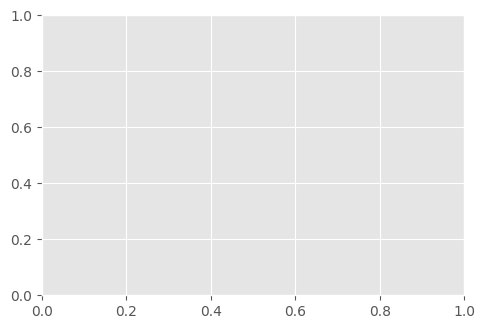

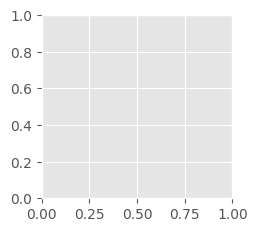

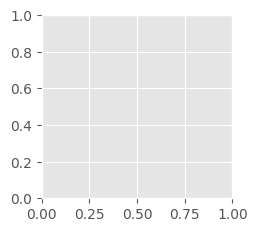

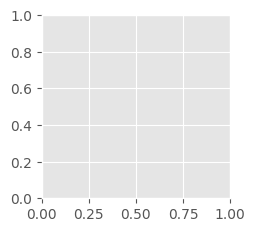

In [22]:
# Prompt Comparison Metrics Calculation
! pip install seaborn
# Import required libraries
import json
import numpy as np
import pandas as pd
from datetime import datetime
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Verify we have prompt comparison results
if 'prompt_comparison_results' not in locals() or not prompt_comparison_results:
    print("❌ No prompt comparison results found. Run the prompt comparison extraction cell first.")
    raise RuntimeError("No prompt comparison results available for analysis")

print("📊 Calculating metrics for prompt comparison results...")

# Get results by prompt
results_by_prompt = prompt_comparison_results.get("results_by_prompt", {})
prompt_summaries = prompt_comparison_results.get("prompt_summaries", {})

# Count prompts and total results
prompt_count = len(results_by_prompt)
total_results = sum(len(results) for results in results_by_prompt.values())

print(f"✅ Found results for {prompt_count} prompts with {total_results} total extractions")

# Combine all results into a single dataframe for overall analysis
all_results = []
for prompt_name, results in results_by_prompt.items():
    for result in results:
        # Ensure result has prompt information
        if "prompt_name" not in result:
            result["prompt_name"] = prompt_name
        all_results.append(result)

# Convert to DataFrame
all_results_df = pd.DataFrame(all_results)

# Display overall dataframe info
print("\n📋 Overall Results Information:")
print(f"   Total extractions: {len(all_results_df)}")
print(f"   Columns: {', '.join(all_results_df.columns)}")

# Create per-prompt metrics
prompt_metrics = {}

# Verify columns needed for analysis
required_columns = ["exact_match", "character_error_rate", "processing_time", "ground_truth", "processed_extraction"]
missing_columns = [col for col in required_columns if col not in all_results_df.columns]

if missing_columns:
    print(f"⚠️ Warning: Missing required columns: {', '.join(missing_columns)}")
    print("   Some metrics may not be calculated correctly")

# Process each prompt
for prompt_name, results in results_by_prompt.items():
    print(f"\n📊 Analyzing results for prompt: {prompt_name}")
    
    # Convert to DataFrame
    prompt_df = pd.DataFrame(results)
    
    # Basic cleaning
    if 'exact_match' in prompt_df.columns:
        prompt_df['exact_match'] = prompt_df['exact_match'].astype(bool)
    
    if 'processing_time' in prompt_df.columns:
        prompt_df['processing_time'] = pd.to_numeric(prompt_df['processing_time'], errors='coerce')
    
    # Get prompt category
    prompt_category = prompt_df['prompt_category'].iloc[0] if 'prompt_category' in prompt_df.columns else "Unknown"
    
    # Check for error cases
    error_cases = prompt_df[prompt_df['error'].notna()] if 'error' in prompt_df.columns else pd.DataFrame()
    valid_results = prompt_df[~prompt_df.index.isin(error_cases.index)] if not error_cases.empty else prompt_df
    
    # Calculate accuracy metrics
    if 'exact_match' in valid_results.columns:
        exact_matches = valid_results['exact_match'].sum()
        total_valid = len(valid_results)
        exact_match_rate = exact_matches / total_valid if total_valid > 0 else 0
        
        print(f"   Exact Match Accuracy: {exact_matches}/{total_valid} ({exact_match_rate:.2%})")
    else:
        exact_matches = 0
        total_valid = len(valid_results)
        exact_match_rate = 0
    
    # Calculate character error rate
    if 'character_error_rate' in valid_results.columns:
        cer_values = valid_results['character_error_rate'].dropna()
        
        if len(cer_values) > 0:
            min_cer = cer_values.min()
            max_cer = cer_values.max()
            mean_cer = cer_values.mean()
            median_cer = cer_values.median()
            
            print(f"   CER: min={min_cer:.4f}, max={max_cer:.4f}, mean={mean_cer:.4f}, median={median_cer:.4f}")
        else:
            min_cer = max_cer = mean_cer = median_cer = 0
    else:
        min_cer = max_cer = mean_cer = median_cer = 0
    
    # Calculate timing metrics
    if 'processing_time' in valid_results.columns:
        time_values = valid_results['processing_time'].dropna()
        
        if len(time_values) > 0:
            min_time = time_values.min()
            max_time = time_values.max()
            mean_time = time_values.mean()
            median_time = time_values.median()
            total_time = time_values.sum()
            
            print(f"   Time: min={min_time:.2f}s, max={max_time:.2f}s, mean={mean_time:.2f}s, total={total_time:.2f}s")
        else:
            min_time = max_time = mean_time = median_time = total_time = 0
    else:
        min_time = max_time = mean_time = median_time = total_time = 0
    
    # Categorize results
    if 'exact_match' in valid_results.columns:
        successes = len(valid_results[valid_results['exact_match'] == True])
        failures = len(valid_results[valid_results['exact_match'] == False])
        errors = len(error_cases)
        
        print(f"   Categories: {successes} successes, {failures} failures, {errors} errors")
    else:
        successes = failures = 0
        errors = len(error_cases)
    
    # Store metrics for this prompt
    prompt_metrics[prompt_name] = {
        "category": prompt_category,
        "total_extractions": len(prompt_df),
        "valid_extractions": total_valid,
        "error_count": len(error_cases),
        "accuracy": {
            "exact_match_count": int(exact_matches),
            "exact_match_rate": float(exact_match_rate)
        },
        "character_error_rate": {
            "min": float(min_cer),
            "max": float(max_cer),
            "mean": float(mean_cer),
            "median": float(median_cer)
        },
        "timing": {
            "min_seconds": float(min_time),
            "max_seconds": float(max_time),
            "mean_seconds": float(mean_time),
            "median_seconds": float(median_time),
            "total_seconds": float(total_time)
        },
        "categories": {
            "successful_count": int(successes),
            "failed_count": int(failures),
            "error_count": int(errors)
        }
    }

# Create comparative metrics
print("\n🔍 Generating comparative metrics...")

# Create comparison DataFrame
comparison_data = []
for prompt_name, metrics in prompt_metrics.items():
    comparison_data.append({
        "Prompt": prompt_name,
        "Category": metrics["category"],
        "Accuracy (%)": metrics["accuracy"]["exact_match_rate"] * 100,
        "CER": metrics["character_error_rate"]["mean"],
        "Avg Time (s)": metrics["timing"]["mean_seconds"],
        "Success #": metrics["categories"]["successful_count"],
        "Fail #": metrics["categories"]["failed_count"],
        "Error #": metrics["categories"]["error_count"],
        "Total": metrics["total_extractions"]
    })

comparison_df = pd.DataFrame(comparison_data).sort_values("Accuracy (%)", ascending=False)

# Display comparison table
print("\n📊 Prompt Comparison:")
display(comparison_df)

# Identify best performing prompt in each category
best_accuracy_prompt = comparison_df.iloc[0]["Prompt"] if not comparison_df.empty else None
best_accuracy = comparison_df.iloc[0]["Accuracy (%)"] if not comparison_df.empty else 0

best_cer_idx = comparison_df["CER"].idxmin() if "CER" in comparison_df else None
best_cer_prompt = comparison_df.loc[best_cer_idx, "Prompt"] if best_cer_idx is not None else None
best_cer = comparison_df.loc[best_cer_idx, "CER"] if best_cer_idx is not None else 1.0

fastest_idx = comparison_df["Avg Time (s)"].idxmin() if "Avg Time (s)" in comparison_df else None
fastest_prompt = comparison_df.loc[fastest_idx, "Prompt"] if fastest_idx is not None else None
fastest_time = comparison_df.loc[fastest_idx, "Avg Time (s)"] if fastest_idx is not None else 0

print("\n🏆 Best Performing Prompts:")
print(f"   Best Accuracy: {best_accuracy_prompt} ({best_accuracy:.1f}%)")
print(f"   Lowest CER: {best_cer_prompt} ({best_cer:.4f})")
print(f"   Fastest: {fastest_prompt} ({fastest_time:.2f}s)")

# Combine all metrics
combined_metrics = {
    "timestamp": datetime.now().isoformat(),
    "total_prompts": prompt_count,
    "total_extractions": total_results,
    "prompt_metrics": prompt_metrics,
    "comparison": {
        "best_accuracy_prompt": best_accuracy_prompt,
        "best_accuracy_value": float(best_accuracy),
        "best_cer_prompt": best_cer_prompt,
        "best_cer_value": float(best_cer),
        "fastest_prompt": fastest_prompt,
        "fastest_prompt_time": float(fastest_time)
    }
}

# Save metrics to file
metrics_path = get_results_path("prompt_comparison_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(combined_metrics, f, indent=2)

print(f"\n💾 Comparison metrics saved to: {metrics_path}")

# Generate visualizations
print("\n📈 Generating visualizations...")

# Set up the visualization style
plt.style.use('ggplot')
sns.set_palette("colorblind")
plt.figure(figsize=(12, 8))

# 1. Accuracy comparison bar chart
plt.subplot(2, 2, 1)
comparison_df.sort_values("Accuracy (%)", ascending=True).plot(
    kind='barh', 
    x='Prompt', 
    y='Accuracy (%)', 
    legend=False, 
    title='Accuracy by Prompt'
)
plt.tight_layout()

# 2. CER comparison bar chart
plt.subplot(2, 2, 2)
comparison_df.sort_values("CER", ascending=False).plot(
    kind='barh', 
    x='Prompt', 
    y='CER', 
    legend=False, 
    title='Character Error Rate by Prompt (lower is better)'
)
plt.tight_layout()

# 3. Speed comparison bar chart
plt.subplot(2, 2, 3)
comparison_df.sort_values("Avg Time (s)", ascending=False).plot(
    kind='barh', 
    x='Prompt', 
    y='Avg Time (s)', 
    legend=False, 
    title='Average Processing Time by Prompt'
)
plt.tight_layout()

# 4. Success/Failure/Error stacked bar chart
plt.subplot(2, 2, 4)
comparison_df.set_index('Prompt')[['Success #', 'Fail #', 'Error #']].plot(
    kind='bar', 
    stacked=True,
    title='Result Distribution by Prompt'
)
plt.tight_layout()

# Save the figure
comparison_chart_path = get_visualization_path("prompt_comparison_summary.png")
plt.savefig(comparison_chart_path, dpi=150, bbox_inches='tight')
plt.close()

print(f"   ✅ Summary chart saved to: {comparison_chart_path}")

# Create categorical analysis - group by category
if "Category" in comparison_df.columns:
    category_comparison = comparison_df.groupby("Category").agg({
        "Accuracy (%)": "mean",
        "CER": "mean",
        "Avg Time (s)": "mean",
        "Success #": "sum",
        "Fail #": "sum",
        "Error #": "sum",
        "Total": "sum"
    }).reset_index()
    
    # Display category comparison
    print("\n📊 Category Comparison:")
    display(category_comparison)
    
    # Create category comparison chart
    plt.figure(figsize=(12, 6))
    
    # 1. Accuracy by category
    plt.subplot(1, 3, 1)
    sns.barplot(x="Category", y="Accuracy (%)", data=category_comparison)
    plt.title("Accuracy by Prompt Category")
    
    # 2. CER by category
    plt.subplot(1, 3, 2)
    sns.barplot(x="Category", y="CER", data=category_comparison)
    plt.title("CER by Prompt Category")
    
    # 3. Time by category
    plt.subplot(1, 3, 3)
    sns.barplot(x="Category", y="Avg Time (s)", data=category_comparison)
    plt.title("Processing Time by Category")
    
    plt.tight_layout()
    
    # Save the figure
    category_chart_path = get_visualization_path("category_comparison.png")
    plt.savefig(category_chart_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"   ✅ Category comparison chart saved to: {category_chart_path}")

# Store metrics and DataFrames for further analysis
comparison_metrics = combined_metrics
comparison_results = {
    "all_results_df": all_results_df,
    "comparison_df": comparison_df,
    "category_comparison": category_comparison if "Category" in comparison_df.columns else pd.DataFrame(),
    "results_by_prompt": {prompt: pd.DataFrame(results) for prompt, results in results_by_prompt.items()}
}

print("✅ Prompt comparison metrics calculation and visualization complete!")

### Error Analysis

In [24]:
# Error Analysis for Prompt Comparison

# Import required libraries
import pandas as pd
import numpy as np
import re
from Levenshtein import distance
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Verify we have comparison results
if 'comparison_results' not in locals() or not comparison_results:
    print("❌ No comparison results found. Run the metrics calculation cell first.")
    raise RuntimeError("No comparison results available for analysis")

print("🔍 Analyzing extraction errors and failure patterns across prompts...")

# Access results by prompt
results_by_prompt = comparison_results.get("results_by_prompt", {})
if not results_by_prompt:
    print("❌ No results by prompt found in comparison results.")
    raise RuntimeError("Missing prompt-specific results")

# Create a detailed analysis function for extraction failures
def analyze_extraction_difference(ground_truth, extraction):
    """Analyze the difference between ground truth and extraction"""
    if not isinstance(ground_truth, str) or not isinstance(extraction, str):
        return "Invalid input types"
    
    # Clean strings
    gt = ground_truth.strip()
    ext = extraction.strip()
    
    # Handle empty cases
    if not gt and not ext:
        return "Both empty"
    if not gt:
        return "Ground truth empty"
    if not ext:
        return "Extraction empty"
    
    # Calculate length difference
    len_diff = len(ext) - len(gt)
    
    # Check for case differences
    if gt.lower() == ext.lower():
        return "Case difference only"
    
    # Check for whitespace-only differences
    if gt.replace(" ", "") == ext.replace(" ", ""):
        return "Whitespace difference only"
        
    # Check for character type mismatches (e.g., letter vs. number)
    gt_alphas = sum(c.isalpha() for c in gt)
    ext_alphas = sum(c.isalpha() for c in ext)
    gt_digits = sum(c.isdigit() for c in gt)
    ext_digits = sum(c.isdigit() for c in ext)
    
    if abs(gt_alphas - ext_alphas) > 0.5 * max(gt_alphas, ext_alphas) or \
       abs(gt_digits - ext_digits) > 0.5 * max(gt_digits, ext_digits):
        return "Character type mismatch"
        
    # Check for substring relationship
    if gt in ext:
        return "Ground truth is substring of extraction"
    if ext in gt:
        return "Extraction is substring of ground truth"
        
    # Check for digits-only case
    if gt.isdigit() and ext.isdigit():
        if len(gt) == len(ext):
            return "Digit transposition or substitution"
        elif len(gt) > len(ext):
            return "Missing digits"
        else:
            return "Extra digits"
            
    # For more complex cases, calculate edit distance and characterize
    edit_dist = distance(gt, ext)
    if edit_dist <= 2:
        return "Minor edit distance (1-2 chars)"
    elif edit_dist <= len(gt) * 0.3:
        return "Moderate edit distance (≤30%)"
    else:
        return "Major difference (>30% edit distance)"

# Initialize error analysis storage for each prompt
prompt_error_analysis = {}

# Track global error patterns
all_error_patterns = Counter()
total_failures = 0

# Process each prompt's results
for prompt_name, prompt_df in results_by_prompt.items():
    print(f"\n🔍 Analyzing errors for prompt: {prompt_name}")
    
    # Filter to get failures only
    if 'exact_match' not in prompt_df.columns:
        print(f"⚠️ No 'exact_match' column found for prompt {prompt_name}, skipping")
        continue
        
    failures_df = prompt_df[prompt_df['exact_match'] == False].copy()
    
    if failures_df.empty:
        print(f"✅ No failures found for prompt '{prompt_name}' - perfect accuracy!")
        prompt_error_analysis[prompt_name] = {
            "total_failures": 0,
            "error_patterns": [],
            "examples": [],
            "length_stats": {}
        }
        continue
    
    print(f"   Found {len(failures_df)} failures to analyze")
    total_failures += len(failures_df)
    
    # Process each failure to categorize error patterns
    pattern_column = []
    details_column = []
    
    for _, row in failures_df.iterrows():
        gt = row.get('ground_truth', '')
        extracted = row.get('processed_extraction', '')
        
        if not isinstance(gt, str):
            gt = str(gt) if gt is not None else ''
        if not isinstance(extracted, str):
            extracted = str(extracted) if extracted is not None else ''
        
        # Get error pattern
        pattern = analyze_extraction_difference(gt, extracted)
        pattern_column.append(pattern)
        all_error_patterns[pattern] += 1
        
        # Create detailed comparison
        if len(gt) > 0 and len(extracted) > 0:
            # Highlight differences character by character
            max_len = max(len(gt), len(extracted))
            detail_text = f"GT: '{gt}'\nEX: '{extracted}'\nDF: '"
            
            for i in range(max_len):
                if i < len(gt) and i < len(extracted):
                    if gt[i] == extracted[i]:
                        detail_text += " "
                    else:
                        detail_text += "^"
                elif i < len(gt):
                    detail_text += "-"  # Missing in extraction
                else:
                    detail_text += "+"  # Extra in extraction
            
            detail_text += "'"
        else:
            if len(gt) == 0:
                detail_text = "Ground truth is empty"
            elif len(extracted) == 0:
                detail_text = "Extraction is empty"
            else:
                detail_text = "Unknown comparison"
        
        details_column.append(detail_text)
    
    # Add columns to dataframe
    failures_df.loc[:, 'error_pattern'] = pattern_column
    failures_df.loc[:, 'difference_details'] = details_column
    
    # Count error patterns for this prompt
    pattern_counts = Counter(pattern_column)
    
    # Create dataframe of error patterns
    error_patterns = pd.DataFrame({
        'pattern': list(pattern_counts.keys()),
        'count': list(pattern_counts.values())
    })
    
    # Add percentage column
    error_patterns['percentage'] = error_patterns['count'] / len(failures_df) * 100
    
    # Sort by count descending
    error_patterns = error_patterns.sort_values('count', ascending=False).reset_index(drop=True)
    
    # Display top error patterns for this prompt
    print(f"\n   Top Error Patterns for '{prompt_name}':")
    for i, row in error_patterns.head(3).iterrows():
        print(f"      {row['pattern']}: {row['count']} occurrences ({row['percentage']:.1f}%)")
    
    # Select representative examples
    examples = []
    for pattern in error_patterns['pattern']:
        pattern_rows = failures_df[failures_df['error_pattern'] == pattern]
        
        if not pattern_rows.empty:
            # Select a representative example (one with the median CER)
            if 'character_error_rate' in pattern_rows.columns:
                pattern_rows = pattern_rows.sort_values('character_error_rate')
                example_row = pattern_rows.iloc[len(pattern_rows) // 2]  # Median
            else:
                example_row = pattern_rows.iloc[0]
            
            examples.append({
                'pattern': pattern,
                'image_id': example_row.get('image_id', 'Unknown'),
                'ground_truth': example_row.get('ground_truth', ''),
                'extracted_text': example_row.get('processed_extraction', ''),
                'character_error_rate': example_row.get('character_error_rate', None),
                'difference_details': example_row.get('difference_details', '')
            })
    
    # Analyze length characteristics
    if 'ground_truth' in failures_df.columns and 'processed_extraction' in failures_df.columns:
        failures_df.loc[:, 'gt_length'] = failures_df['ground_truth'].astype(str).apply(len)
        failures_df.loc[:, 'extraction_length'] = failures_df['processed_extraction'].astype(str).apply(len)
        failures_df.loc[:, 'length_diff'] = failures_df['extraction_length'] - failures_df['gt_length']
        
        # Create length analysis
        len_stats = {
            'avg_gt_length': float(failures_df['gt_length'].mean()),
            'avg_extraction_length': float(failures_df['extraction_length'].mean()),
            'avg_abs_length_diff': float(failures_df['length_diff'].abs().mean()),
            'shorter_extractions': int((failures_df['length_diff'] < 0).sum()),
            'longer_extractions': int((failures_df['length_diff'] > 0).sum()),
            'same_length': int((failures_df['length_diff'] == 0).sum())
        }
    else:
        len_stats = {}
    
    # Store analysis for this prompt
    prompt_error_analysis[prompt_name] = {
        "total_failures": len(failures_df),
        "error_patterns": error_patterns.to_dict('records'),
        "examples": examples,
        "length_stats": len_stats
    }

# Create comparative error pattern analysis
print("\n📊 Comparative Error Pattern Analysis:")

# Create a dataframe with error patterns across all prompts
all_patterns_df = pd.DataFrame({
    'pattern': list(all_error_patterns.keys()),
    'total_count': list(all_error_patterns.values())
})
all_patterns_df['percentage'] = all_patterns_df['total_count'] / total_failures * 100 if total_failures > 0 else 0
all_patterns_df = all_patterns_df.sort_values('total_count', ascending=False).reset_index(drop=True)

# Display the most common error patterns overall
print("\n🔍 Most Common Error Patterns Across All Prompts:")
for i, row in all_patterns_df.head(5).iterrows():
    print(f"   {row['pattern']}: {row['total_count']} occurrences ({row['percentage']:.1f}%)")

# Create a matrix of error patterns by prompt
pattern_matrix = pd.DataFrame(index=all_patterns_df['pattern'])

for prompt_name, analysis in prompt_error_analysis.items():
    if analysis["total_failures"] == 0:
        # Skip prompts with no failures
        pattern_matrix[prompt_name] = 0
        continue
        
    prompt_patterns = pd.DataFrame(analysis["error_patterns"])
    if prompt_patterns.empty:
        pattern_matrix[prompt_name] = 0
        continue
        
    # Create a Series with pattern counts
    pattern_series = pd.Series(
        prompt_patterns.set_index('pattern')['count']
    ).reindex(all_patterns_df['pattern']).fillna(0)
    
    # Add to the matrix
    pattern_matrix[prompt_name] = pattern_series

# Calculate percentages
for col in pattern_matrix.columns:
    total = pattern_matrix[col].sum()
    if total > 0:
        pattern_matrix[f"{col}_pct"] = pattern_matrix[col] / total * 100

# Display the matrix
print("\n📊 Error Pattern Distribution by Prompt:")
display(pattern_matrix.head(10))

# Identify prompts that avoid specific error types
print("\n🔍 Error Type Avoidance by Prompt:")
for pattern in all_patterns_df['pattern'].head(5):
    pattern_counts = pattern_matrix.loc[pattern].drop([c for c in pattern_matrix.columns if c.endswith('_pct')])
    min_count_prompt = pattern_counts.idxmin()
    min_count = pattern_counts.min()
    max_count_prompt = pattern_counts.idxmax()
    max_count = pattern_counts.max()
    
    print(f"   For '{pattern}' errors:")
    print(f"      Best prompt: {min_count_prompt} ({min_count:.0f} occurrences)")
    print(f"      Worst prompt: {max_count_prompt} ({max_count:.0f} occurrences)")

# Visualize error patterns
if all_patterns_df.shape[0] > 0:
    print("\n📊 Creating error pattern visualizations...")
    
    # 1. Top 5 error patterns by frequency
    plt.figure(figsize=(10, 6))
    sns.barplot(x='total_count', y='pattern', data=all_patterns_df.head(5))
    plt.title('Top 5 Error Patterns Across All Prompts')
    plt.tight_layout()
    top_errors_chart_path = get_visualization_path("top_error_patterns.png")
    plt.savefig(top_errors_chart_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    # 2. Heatmap of error patterns by prompt
plt.figure(figsize=(12, 8))
# Get columns that end with '_pct'
pct_columns = [c for c in pattern_matrix.columns if c.endswith('_pct')]
# Only drop them if they exist
if pct_columns:
    pattern_viz_data = pattern_matrix.drop(pct_columns)
else:
    pattern_viz_data = pattern_matrix.copy()

if not pattern_viz_data.empty and pattern_viz_data.shape[0] > 0 and pattern_viz_data.shape[1] > 0:
    # Only include top 10 patterns for readability
    pattern_viz_data = pattern_viz_data.loc[all_patterns_df['pattern'].head(10)]
    sns.heatmap(pattern_viz_data, annot=True, fmt='.0f', cmap='YlOrRd')
    plt.title('Error Pattern Distribution by Prompt')
    plt.tight_layout()
    heatmap_path = get_visualization_path("error_pattern_heatmap.png")
    plt.savefig(heatmap_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"   ✅ Error pattern visualizations saved to:")
    print(f"      - {top_errors_chart_path}")
    print(f"      - {heatmap_path}")
else:
    plt.close()  # Close the empty figure
    print("   ⚠️ Not enough data for heatmap visualization")

# Function to convert NumPy types to native Python types for JSON serialization
def convert_to_serializable(obj):
    """Convert NumPy types to native Python types for JSON serialization"""
    if isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return convert_to_serializable(obj.tolist())
    elif isinstance(obj, pd.DataFrame):
        return convert_to_serializable(obj.to_dict('records'))
    else:
        return obj

# Prepare the error analysis data for the report
prompt_comparison_error_analysis = {
    'overall_patterns': all_patterns_df.to_dict('records'),
    'total_failures': total_failures,
    'pattern_matrix': pattern_matrix.reset_index().to_dict('records'),
    'prompt_analysis': prompt_error_analysis
}

# Convert to serializable format
prompt_comparison_error_analysis = convert_to_serializable(prompt_comparison_error_analysis)

# Save error analysis to file
error_analysis_path = get_results_path("prompt_comparison_error_analysis.json")
with open(error_analysis_path, "w") as f:
    json.dump(prompt_comparison_error_analysis, f, indent=2)

print(f"\n💾 Prompt comparison error analysis saved to: {error_analysis_path}")
print("✅ Error analysis complete!")

🔍 Analyzing extraction errors and failure patterns across prompts...

🔍 Analyzing errors for prompt: basic_work_order
   Found 13 failures to analyze

   Top Error Patterns for 'basic_work_order':
      Character type mismatch: 5 occurrences (38.5%)
      Missing digits: 4 occurrences (30.8%)
      Digit transposition or substitution: 3 occurrences (23.1%)

🔍 Analyzing errors for prompt: detailed_work_order
   Found 14 failures to analyze

   Top Error Patterns for 'detailed_work_order':
      Character type mismatch: 12 occurrences (85.7%)
      Missing digits: 1 occurrences (7.1%)
      Digit transposition or substitution: 1 occurrences (7.1%)

🔍 Analyzing errors for prompt: positioned_work_order
   Found 10 failures to analyze

   Top Error Patterns for 'positioned_work_order':
      Character type mismatch: 5 occurrences (50.0%)
      Digit transposition or substitution: 4 occurrences (40.0%)
      Missing digits: 1 occurrences (10.0%)

🔍 Analyzing errors for prompt: formatted_work

,basic_work_order,detailed_work_order,positioned_work_order,formatted_work_order,work_order_cot,basic_work_order_pct,detailed_work_order_pct,positioned_work_order_pct,formatted_work_order_pct,work_order_cot_pct
pattern,,,,,,,,,,
Character type mismatch,5,12.0,5.0,4.0,19.0,38.461538,85.714286,50.0,44.444444,95.0
Digit transposition or substitution,3,1.0,4.0,4.0,1.0,23.076923,7.142857,40.0,44.444444,5.0
Missing digits,4,1.0,1.0,1.0,0.0,30.769231,7.142857,10.0,11.111111,0.0
Extraction is substring of ground truth,1,0.0,0.0,0.0,0.0,7.692308,0.000000,0.0,0.000000,0.0



🔍 Error Type Avoidance by Prompt:
   For 'Character type mismatch' errors:
      Best prompt: formatted_work_order (4 occurrences)
      Worst prompt: work_order_cot (19 occurrences)
   For 'Digit transposition or substitution' errors:
      Best prompt: detailed_work_order (1 occurrences)
      Worst prompt: positioned_work_order (4 occurrences)
   For 'Missing digits' errors:
      Best prompt: work_order_cot (0 occurrences)
      Worst prompt: basic_work_order (4 occurrences)
   For 'Extraction is substring of ground truth' errors:
      Best prompt: detailed_work_order (0 occurrences)
      Worst prompt: basic_work_order (1 occurrences)

📊 Creating error pattern visualizations...


KeyError: "['basic_work_order_pct', 'detailed_work_order_pct', 'positioned_work_order_pct', 'formatted_work_order_pct', 'work_order_cot_pct'] not found in axis"

<Figure size 1200x800 with 0 Axes>

### Visualization

In [25]:
# Visualization for Prompt Comparison

# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
from datetime import datetime

# Configure plotting style
plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Verify we have results to visualize
if 'prompt_comparison_results' not in locals() or not prompt_comparison_results:
    print("❌ No prompt comparison results to visualize. Run the metrics calculation cell first.")
    raise RuntimeError("No prompt comparison results available for visualization")

print("📊 Creating visualizations for prompt comparison results...")

# Create directory for visualizations if needed
vis_dir = get_results_path("visualizations")
os.makedirs(vis_dir, exist_ok=True)
print(f"📁 Saving visualizations to: {vis_dir}")

# Function to save figures
def save_figure(fig, filename):
    """Save a figure to the visualizations directory"""
    filepath = os.path.join(vis_dir, filename)
    fig.savefig(filepath, bbox_inches='tight', dpi=150)
    return filepath

# Get results by prompt and prompt summaries
results_by_prompt = prompt_comparison_results.get("results_by_prompt", {})
prompt_summaries = prompt_comparison_results.get("prompt_summaries", {})

# Convert summaries to DataFrame for easier visualization
summary_data = []
for prompt_name, summary in prompt_summaries.items():
    summary_data.append({
        "Prompt": prompt_name,
        "Category": summary.get("prompt_category", "Unknown"),
        "Accuracy (%)": summary.get("accuracy", 0),
        "Exact Matches": summary.get("exact_matches", 0),
        "Total Images": summary.get("total_images", 0),
        "Avg CER": summary.get("avg_character_error_rate", 0),
        "Avg Time (s)": summary.get("avg_processing_time", 0),
        "Total Time (s)": summary.get("total_processing_time", 0)
    })

# Create DataFrame and sort by accuracy
if summary_data:
    summary_df = pd.DataFrame(summary_data).sort_values("Accuracy (%)", ascending=False)
else:
    print("⚠️ No prompt summary data available")
    summary_df = pd.DataFrame()

# -------------------------------------------------------------------------------
# 1. Create prompt accuracy comparison bar chart
# -------------------------------------------------------------------------------
print("📊 Creating prompt accuracy comparison chart...")

if not summary_df.empty:
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create bar chart
    bars = ax.bar(summary_df["Prompt"], summary_df["Accuracy (%)"], 
                  color=sns.color_palette("viridis", len(summary_df)))
    
    # Add title and labels
    ax.set_title('Prompt Comparison: Extraction Accuracy', fontsize=16)
    ax.set_ylabel('Accuracy (%)', fontsize=14)
    ax.set_xlabel('Prompt', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', 
                ha='center', va='bottom', fontsize=12)
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    accuracy_chart_path = save_figure(fig, "prompt_accuracy_comparison.png")
    plt.close(fig)
else:
    print("⚠️ No data available for accuracy comparison chart")
    accuracy_chart_path = None

# -------------------------------------------------------------------------------
# 2. Create character error rate comparison bar chart
# -------------------------------------------------------------------------------
print("📊 Creating CER comparison chart...")

if not summary_df.empty and "Avg CER" in summary_df.columns:
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Sort by CER (ascending - lower is better)
    cer_sorted_df = summary_df.sort_values("Avg CER")
    
    # Create bar chart
    bars = ax.bar(cer_sorted_df["Prompt"], cer_sorted_df["Avg CER"], 
                  color=sns.color_palette("crest", len(cer_sorted_df)))
    
    # Add title and labels
    ax.set_title('Prompt Comparison: Character Error Rate (Lower is Better)', fontsize=16)
    ax.set_ylabel('Average CER', fontsize=14)
    ax.set_xlabel('Prompt', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', 
                ha='center', va='bottom', fontsize=12)
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    cer_chart_path = save_figure(fig, "prompt_cer_comparison.png")
    plt.close(fig)
else:
    print("⚠️ No data available for CER comparison chart")
    cer_chart_path = None

# -------------------------------------------------------------------------------
# 3. Create processing time comparison bar chart
# -------------------------------------------------------------------------------
print("📊 Creating processing time comparison chart...")

if not summary_df.empty and "Avg Time (s)" in summary_df.columns:
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Sort by processing time (ascending - faster is better)
    time_sorted_df = summary_df.sort_values("Avg Time (s)")
    
    # Create bar chart
    bars = ax.bar(time_sorted_df["Prompt"], time_sorted_df["Avg Time (s)"], 
                  color=sns.color_palette("magma", len(time_sorted_df)))
    
    # Add title and labels
    ax.set_title('Prompt Comparison: Average Processing Time (Lower is Better)', fontsize=16)
    ax.set_ylabel('Average Time (seconds)', fontsize=14)
    ax.set_xlabel('Prompt', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{height:.2f}s', 
                ha='center', va='bottom', fontsize=12)
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    time_chart_path = save_figure(fig, "prompt_time_comparison.png")
    plt.close(fig)
else:
    print("⚠️ No data available for processing time comparison chart")
    time_chart_path = None

# -------------------------------------------------------------------------------
# 4. Create multi-metric radar chart
# -------------------------------------------------------------------------------
print("📊 Creating radar chart for multi-metric comparison...")

if not summary_df.empty and len(summary_df) >= 2:
    # Create a radar chart to compare prompts across metrics
    
    # Normalize metrics for comparison
    metrics = ["Accuracy (%)", "Avg CER", "Avg Time (s)"]
    radar_df = summary_df.copy()
    
    # Invert CER and Time so that higher is always better
    radar_df["Avg CER"] = 1 - radar_df["Avg CER"]
    
    # Normalize each metric to 0-1 scale
    for metric in metrics:
        if radar_df[metric].max() != radar_df[metric].min():
            radar_df[metric] = (radar_df[metric] - radar_df[metric].min()) / (radar_df[metric].max() - radar_df[metric].min())
        else:
            radar_df[metric] = 1
    
    # Create radar chart
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    # Set categories and number of prompts
    categories = ["Accuracy", "1-CER", "Speed"]
    N = len(categories)
    
    # Create angles for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Set radar chart properties
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    
    # Add category labels
    plt.xticks(angles[:-1], categories, size=14)
    
    # Plot each prompt
    for i, prompt in enumerate(radar_df["Prompt"]):
        values = radar_df.loc[radar_df["Prompt"] == prompt, metrics].values.flatten().tolist()
        values += values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=prompt)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # Add title
    plt.title('Prompt Performance Comparison (Higher is Better)', size=16, y=1.1)
    
    # Save the figure
    radar_chart_path = save_figure(fig, "prompt_radar_comparison.png")
    plt.close(fig)
else:
    print("⚠️ Not enough data for radar comparison chart")
    radar_chart_path = None

# -------------------------------------------------------------------------------
# 5. Create stacked bar chart for success/failure/error counts
# -------------------------------------------------------------------------------
print("📊 Creating stacked bar chart for result counts...")

if not summary_df.empty:
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract data for stacked bars
    prompts = summary_df["Prompt"]
    successes = summary_df["Exact Matches"]
    failures = summary_df["Total Images"] - summary_df["Exact Matches"]
    
    # Create stacked bar chart
    ax.bar(prompts, successes, label='Exact Matches', color='#2ecc71')
    ax.bar(prompts, failures, bottom=successes, label='Non-Matches', color='#e74c3c')
    
    # Add title and labels
    ax.set_title('Prompt Comparison: Exact Matches vs Non-Matches', fontsize=16)
    ax.set_ylabel('Number of Images', fontsize=14)
    ax.set_xlabel('Prompt', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add legend
    ax.legend()
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    stacked_chart_path = save_figure(fig, "prompt_results_stacked.png")
    plt.close(fig)
else:
    print("⚠️ No data available for stacked bar chart")
    stacked_chart_path = None

# -------------------------------------------------------------------------------
# 6. Generate HTML dashboard for prompt comparison
# -------------------------------------------------------------------------------
print("📄 Generating HTML dashboard for prompt comparison...")

# Get metadata for the dashboard
experiment_name = prompt_comparison_results.get("experiment", {}).get("name", "Prompt Comparison Experiment")
model_name = prompt_comparison_results.get("model", {}).get("name", "Unknown Model")
prompt_count = len(summary_df)
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Get comparison metrics
best_accuracy_prompt = prompt_comparison_results.get("comparison_metrics", {}).get("best_accuracy_prompt", "Unknown")
best_accuracy = prompt_comparison_results.get("comparison_metrics", {}).get("best_accuracy_value", 0)
best_cer_prompt = prompt_comparison_results.get("comparison_metrics", {}).get("best_cer_prompt", "Unknown")
best_cer = prompt_comparison_results.get("comparison_metrics", {}).get("best_cer_value", 0)
fastest_prompt = prompt_comparison_results.get("comparison_metrics", {}).get("fastest_prompt", "Unknown")
fastest_time = prompt_comparison_results.get("comparison_metrics", {}).get("fastest_prompt_time", 0)

# Create prompt info HTML
prompt_info_html = ""
for i, row in summary_df.iterrows():
    prompt_name = row["Prompt"]
    category = row["Category"]
    accuracy = row["Accuracy (%)"]
    cer = row["Avg CER"]
    time = row["Avg Time (s)"]
    
    prompt_info_html += f"""
    <div class="prompt-box">
        <h3>{prompt_name} <span class="category">({category})</span></h3>
        <div class="prompt-metrics">
            <div class="metric"><span class="label">Accuracy:</span> <span class="value">{accuracy:.1f}%</span></div>
            <div class="metric"><span class="label">CER:</span> <span class="value">{cer:.4f}</span></div>
            <div class="metric"><span class="label">Avg Time:</span> <span class="value">{time:.2f}s</span></div>
        </div>
    </div>
    """

# Create HTML content
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Prompt Comparison Dashboard</title>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 20px;
            background-color: #f5f5f5;
        }}
        .container {{
            max-width: 1200px;
            margin: 0 auto;
            background-color: white;
            padding: 20px;
            border-radius: 5px;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
        }}
        h1, h2, h3 {{
            color: #333;
        }}
        .metrics {{
            display: flex;
            flex-wrap: wrap;
            margin: 20px 0;
        }}
        .metric-card {{
            background-color: white;
            border-radius: 5px;
            box-shadow: 0 0 5px rgba(0,0,0,0.1);
            padding: 15px;
            margin: 10px;
            min-width: 200px;
            flex: 1;
        }}
        .metric-title {{
            font-size: 14px;
            color: #666;
            margin-bottom: 5px;
        }}
        .metric-value {{
            font-size: 24px;
            font-weight: bold;
            color: #333;
        }}
        .chart-container {{
            margin: 20px 0;
            text-align: center;
        }}
        .chart {{
            max-width: 100%;
            height: auto;
            margin: 10px 0;
            border: 1px solid #eee;
        }}
        .experiment-info {{
            background-color: #f9f9f9;
            padding: 15px;
            border-radius: 5px;
            margin-bottom: 20px;
        }}
        .prompt-box {{
            background-color: #f5f5f5;
            padding: 15px;
            border-radius: 5px;
            border-left: 4px solid #3498db;
            margin: 10px 0;
        }}
        .prompt-metrics {{
            display: flex;
            margin-top: 10px;
        }}
        .metric {{
            margin-right: 20px;
        }}
        .label {{
            font-weight: bold;
            color: #555;
        }}
        .value {{
            color: #333;
        }}
        .category {{
            font-weight: normal;
            color: #777;
            font-size: 16px;
        }}
        .winners {{
            display: flex;
            flex-wrap: wrap;
            margin: 20px 0;
        }}
        .winner-card {{
            background-color: #f9f9f9;
            border-radius: 5px;
            box-shadow: 0 0 5px rgba(0,0,0,0.1);
            padding: 15px;
            margin: 10px;
            flex: 1;
            min-width: 250px;
            border-left: 4px solid #2ecc71;
        }}
        .winner-title {{
            font-size: 16px;
            font-weight: bold;
            color: #333;
            margin-bottom: 10px;
        }}
        .winner-prompt {{
            font-size: 18px;
            color: #2980b9;
            margin-bottom: 5px;
        }}
        .winner-value {{
            font-size: 16px;
            color: #333;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
            margin: 20px 0;
        }}
        th, td {{
            padding: 10px;
            text-align: left;
            border-bottom: 1px solid #ddd;
        }}
        th {{
            background-color: #f2f2f2;
        }}
        tr:hover {{
            background-color: #f9f9f9;
        }}
    </style>
</head>
<body>
    <div class="container">
        <h1>Prompt Comparison Dashboard</h1>
        
        <div class="experiment-info">
            <h2>Experiment Information</h2>
            <p><strong>Experiment:</strong> {experiment_name}</p>
            <p><strong>Model:</strong> {model_name}</p>
            <p><strong>Date:</strong> {timestamp}</p>
            <p><strong>Prompts Compared:</strong> {prompt_count}</p>
        </div>
        
        <h2>Top Performers</h2>
        <div class="winners">
            <div class="winner-card">
                <div class="winner-title">Best Accuracy</div>
                <div class="winner-prompt">{best_accuracy_prompt}</div>
                <div class="winner-value">{best_accuracy:.1f}%</div>
            </div>
            <div class="winner-card">
                <div class="winner-title">Lowest Character Error Rate</div>
                <div class="winner-prompt">{best_cer_prompt}</div>
                <div class="winner-value">{best_cer:.4f}</div>
            </div>
            <div class="winner-card">
                <div class="winner-title">Fastest Processing</div>
                <div class="winner-prompt">{fastest_prompt}</div>
                <div class="winner-value">{fastest_time:.2f}s</div>
            </div>
        </div>
        
        <h2>Comparison Charts</h2>
        
        <div class="chart-container">
            <h3>Accuracy Comparison</h3>
            <img class="chart" src="prompt_accuracy_comparison.png" alt="Accuracy Comparison">
        </div>
        
        <div class="chart-container">
            <h3>Character Error Rate Comparison</h3>
            <img class="chart" src="prompt_cer_comparison.png" alt="CER Comparison">
        </div>
        
        <div class="chart-container">
            <h3>Processing Time Comparison</h3>
            <img class="chart" src="prompt_time_comparison.png" alt="Time Comparison">
        </div>
        
        {f'<div class="chart-container"><h3>Multi-Metric Comparison</h3><img class="chart" src="prompt_radar_comparison.png" alt="Radar Comparison"></div>' if 'radar_chart_path' in locals() and radar_chart_path else ''}
        
        {f'<div class="chart-container"><h3>Success/Failure Breakdown</h3><img class="chart" src="prompt_results_stacked.png" alt="Results Breakdown"></div>' if 'stacked_chart_path' in locals() and stacked_chart_path else ''}
        
        <h2>Detailed Results</h2>
        
        <h3>Prompt Comparison Table</h3>
        <table>
            <thead>
                <tr>
                    <th>Prompt</th>
                    <th>Category</th>
                    <th>Accuracy (%)</th>
                    <th>CER</th>
                    <th>Avg Time (s)</th>
                    <th>Exact Matches</th>
                    <th>Total Images</th>
                </tr>
            </thead>
            <tbody>
                {"".join([f'<tr><td>{row["Prompt"]}</td><td>{row["Category"]}</td><td>{row["Accuracy (%)"]:.1f}</td><td>{row["Avg CER"]:.4f}</td><td>{row["Avg Time (s)"]:.2f}</td><td>{row["Exact Matches"]}</td><td>{row["Total Images"]}</td></tr>' for _, row in summary_df.iterrows()])}
            </tbody>
        </table>
        
        <h3>Prompt Details</h3>
        {prompt_info_html}
        
        <h2>Conclusion</h2>
        <p>This dashboard presents the results of comparing {prompt_count} different prompts for extracting work order numbers from invoice images using the {model_name} model.</p>
        <p>The best performing prompt was <strong>{best_accuracy_prompt}</strong> with an accuracy of <strong>{best_accuracy:.1f}%</strong>.</p>
        
        <footer style="margin-top: 50px; text-align: center; color: #777; font-size: 12px;">
            Generated on {timestamp} • Invoice Processing Analysis System
        </footer>
    </div>
</body>
</html>
"""

# Save the HTML dashboard
dashboard_path = get_results_path("prompt_comparison_dashboard.html")
with open(dashboard_path, "w") as f:
    f.write(html_content)

print(f"\n📄 Dashboard saved to: {dashboard_path}")
print("✅ Prompt comparison visualizations complete!")

📊 Creating visualizations for prompt comparison results...
📁 Saving visualizations to: /workspace/results/prompt_comparison_20250323_163114/visualizations
📊 Creating prompt accuracy comparison chart...
📊 Creating CER comparison chart...
📊 Creating processing time comparison chart...
📊 Creating radar chart for multi-metric comparison...
📊 Creating stacked bar chart for result counts...
📄 Generating HTML dashboard for prompt comparison...


AttributeError: 'str' object has no attribute 'get'

### Discussion

## Clean Up 

In [ ]:
# Resource Cleanup

# Import required libraries
import torch
import gc
import os
import shutil
import json
from datetime import datetime

print("🧹 Cleaning up resources and recording final state...")

# Record initial memory state
initial_memory = None
if torch.cuda.is_available():
    initial_memory = {
        "total_memory_gb": torch.cuda.get_device_properties(0).total_memory / 1e9,
        "allocated_memory_gb": torch.cuda.memory_allocated(0) / 1e9,
        "reserved_memory_gb": torch.cuda.memory_reserved(0) / 1e9,
        "free_memory_gb": (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9
    }
    
    print(f"\n🧠 Initial GPU Memory State:")
    print(f"   Total Memory: {initial_memory['total_memory_gb']:.2f} GB")
    print(f"   Allocated Memory: {initial_memory['allocated_memory_gb']:.2f} GB")
    print(f"   Reserved Memory: {initial_memory['reserved_memory_gb']:.2f} GB")
    print(f"   Free Memory: {initial_memory['free_memory_gb']:.2f} GB")

# Release model from memory
print("\n🔄 Releasing model from memory...")
if 'model' in locals():
    try:
        # Delete the model
        del model
        print("   ✓ Model deleted")
    except Exception as e:
        print(f"   ⚠️ Error deleting model: {e}")
else:
    print("   ℹ️ No model in memory to delete")

# Release processor from memory
if 'processor' in locals():
    try:
        # Delete the processor
        del processor
        print("   ✓ Processor deleted")
    except Exception as e:
        print(f"   ⚠️ Error deleting processor: {e}")
else:
    print("   ℹ️ No processor in memory to delete")

# Release pipeline from memory
if 'pipeline' in locals():
    try:
        # Delete the pipeline
        del pipeline
        print("   ✓ Pipeline deleted")
    except Exception as e:
        print(f"   ⚠️ Error deleting pipeline: {e}")
else:
    print("   ℹ️ No pipeline in memory to delete")

# Release other large variables
large_variables = ['extraction_results', 'categorized_results', 'all_results', 'metrics_results']
for var_name in large_variables:
    if var_name in locals():
        try:
            # Use exec to delete the variable
            exec(f"del {var_name}")
            print(f"   ✓ Deleted {var_name}")
        except Exception as e:
            print(f"   ⚠️ Error deleting {var_name}: {e}")

# Run garbage collection
print("\n🧹 Running garbage collection...")
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print("   ✓ CUDA cache emptied and synchronized")
else:
    print("   ℹ️ No CUDA available for cache emptying")

# Clean up temporary files
print("\n🗑️ Cleaning up temporary files...")

# Define temporary directories to clean
temp_dirs = []

# Clean up any temporary files in the results directory
temp_files = []  # Add any specific temp files pattern here if needed

# Remove temporary files if any were specified
for file_pattern in temp_files:
    matching_files = []  # Add glob or similar to find matching files
    for file_path in matching_files:
        try:
            os.remove(file_path)
            print(f"   ✓ Removed temporary file: {file_path}")
        except Exception as e:
            print(f"   ⚠️ Error removing file {file_path}: {e}")

# Record final memory state
final_memory = None
if torch.cuda.is_available():
    final_memory = {
        "total_memory_gb": torch.cuda.get_device_properties(0).total_memory / 1e9,
        "allocated_memory_gb": torch.cuda.memory_allocated(0) / 1e9,
        "reserved_memory_gb": torch.cuda.memory_reserved(0) / 1e9,
        "free_memory_gb": (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9
    }
    
    print(f"\n🧠 Final GPU Memory State:")
    print(f"   Total Memory: {final_memory['total_memory_gb']:.2f} GB")
    print(f"   Allocated Memory: {final_memory['allocated_memory_gb']:.2f} GB")
    print(f"   Reserved Memory: {final_memory['reserved_memory_gb']:.2f} GB")
    print(f"   Free Memory: {final_memory['free_memory_gb']:.2f} GB")
    
    if initial_memory:
        memory_freed = initial_memory['allocated_memory_gb'] - final_memory['allocated_memory_gb']
        print(f"   Memory Freed: {memory_freed:.2f} GB")

# Record final environment state
final_state = {
    "timestamp": datetime.now().isoformat(),
    "torch_version": torch.__version__,
    "cuda_available": torch.cuda.is_available(),
    "initial_memory": initial_memory,
    "final_memory": final_memory,
    "cleanup_success": True
}

if torch.cuda.is_available():
    final_state["cuda_version"] = torch.version.cuda
    final_state["device_name"] = torch.cuda.get_device_name(0)

# Save final state
try:
    final_state_path = get_results_path("final_environment_state.json")
    with open(final_state_path, "w") as f:
        json.dump(final_state, f, indent=2)
    print(f"\n💾 Final environment state saved to: {final_state_path}")
except Exception as e:
    print(f"\n⚠️ Error saving final state: {e}")

print("\n✅ Resource cleanup complete!")
print("\n📝 Experiment execution finished. Results and visualizations are available in the results directory.")
print(f"   Results directory: {get_results_path('')}")